# Universidad Autónoma de Nuevo León
## Facultad de Ciencias Fisico Matemáticas
### Maestría en Ciencia de Datos
#### Alumno: Francisco D. Treviño B.

## Tarea 6 (10 puntos): PySpark ML

# Instalación de Spark

## Se utilizó Docker para la instalación Spark usando una imagen, con el siguiente comando en Windows, según referencia en https://hub.docker.com/_/spark:
### docker pull spark
## Para correr Spark en Docker en modo interactivo se corre el siguiente comando:
### docker pull jupyter/pyspark-notebook
### docker run -it --name spark_container_big_data -p 8899:8888 -p 4040:4040 -v /c/MCD_Big_Data:/home/jovyan/work jupyter/pyspark-notebook
### docker stop spark_container_big_data
### docker start spark_container_big_data

In [1]:
!pip install findspark

In [2]:
!pip install pyspark

In [3]:
!pip install py4j

In [4]:
# !pip install jupyterlab

In [5]:
!pip install pandas

In [6]:
!pip install mplfinance

In [7]:
from pyspark import SparkConf
from pyspark import SparkContext as sc

In [8]:
import os
import sys

import findspark
import pyspark

from pyspark.sql import DataFrame
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F

In [9]:
from pyspark.sql import SparkSession

In [10]:
findspark.init()
findspark.find()

'/usr/local/spark'

In [11]:
spark=SparkSession.builder.appName("Intraday").getOrCreate()

In [12]:
spark

In [13]:
# Paso 1: Lista de archivos CSV
# csv_directory = "c/MCD_Big_Data/"
csv_directory = "/home/jovyan/work/"

# Nombres de los archivos CSV
# csv_file_names = ["intraday_bmv_e.txt"]
csv_file_names = ["intraday_bmv_e_full.txt"]

# Lista para almacenar los DataFrames cargados
df_list = []

# Cargar los archivos CSV, especificando que están delimitados por TAB
for csv_file_name in csv_file_names:
    # Leer el archivo CSV desde la ruta de Google Drive
    file_path = csv_directory + csv_file_name
    df = spark.read.csv(file_path, sep="\t", header=True, inferSchema=True)
    df_list.append(df)

In [14]:
# Unir todos los DataFrames en uno solo (si es necesario)
combined_df = df_list[0]
for df in df_list[1:]:
    combined_df = combined_df.union(df)

# Eliminar las columnas 'auction_indicator' y 'settlement'
combined_df = combined_df.drop('auction_indicator', 'settlement', 'chart')

# Mostrar una muestra del DataFrame unido
combined_df.show(5)

+-------------------+------------+-------------+--------------------+------+------+------+--------+----------+---------+-----------+--------------+-----------------+------------+---+--------+
|         trade_time|match_number|instrument_id|           timestamp|volume| price|amount|buyer_id|buyer_name|seller_id|seller_name|operation_type|concertation_type|price_setter|lot|  symbol|
+-------------------+------------+-------------+--------------------+------+------+------+--------+----------+---------+-----------+--------------+-----------------+------------+---+--------+
|2024-06-24 07:30:00|           1|            3|2024-06-24 07:30:...|     1|193.64|193.64|     112|     SCTIA|       14|        GBM|             C|                O|           0|  0|FEMSAUBD|
|2024-06-24 07:30:00|           1|            5|2024-06-24 07:30:...|     1| 61.53| 61.53|     112|     SCTIA|      112|      SCTIA|             C|                C|           0|  0| WALMEX*|
|2024-06-24 07:30:00|           1|      

In [15]:
combined_df.printSchema()

root
 |-- trade_time: timestamp (nullable = true)
 |-- match_number: integer (nullable = true)
 |-- instrument_id: integer (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- volume: integer (nullable = true)
 |-- price: double (nullable = true)
 |-- amount: double (nullable = true)
 |-- buyer_id: integer (nullable = true)
 |-- buyer_name: string (nullable = true)
 |-- seller_id: integer (nullable = true)
 |-- seller_name: string (nullable = true)
 |-- operation_type: string (nullable = true)
 |-- concertation_type: string (nullable = true)
 |-- price_setter: integer (nullable = true)
 |-- lot: integer (nullable = true)
 |-- symbol: string (nullable = true)



In [16]:
combined_df = combined_df.repartition(10)

In [17]:
# Convertir el DataFrame a un RDD
rdd = combined_df.rdd

In [18]:
rdd.take(5)  # Muestra los primeros 5 registros del RDD

[Row(trade_time=datetime.datetime(2024, 6, 24, 13, 1, 1), match_number=11488, instrument_id=5, timestamp=datetime.datetime(2024, 6, 24, 13, 1, 1, 737000), volume=426, price=60.73, amount=25870.98, buyer_id=54, buyer_name='MERL', seller_id=0, seller_name='GS', operation_type='C', concertation_type='O', price_setter=1, lot=1, symbol='WALMEX*'),
 Row(trade_time=datetime.datetime(2024, 6, 24, 13, 8, 20), match_number=7702, instrument_id=3, timestamp=datetime.datetime(2024, 6, 24, 13, 8, 20, 485000), volume=7, price=193.83, amount=1356.81, buyer_id=141, buyer_name='BTGP', seller_id=0, seller_name='FMX', operation_type='C', concertation_type='O', price_setter=0, lot=0, symbol='FEMSAUBD'),
 Row(trade_time=datetime.datetime(2024, 6, 24, 13, 43, 1), match_number=9407, instrument_id=3, timestamp=datetime.datetime(2024, 6, 24, 13, 43, 1, 58000), volume=164, price=194.39, amount=31879.96, buyer_id=123, buyer_name='JPM', seller_id=51, seller_name='SANT', operation_type='C', concertation_type='O', p

In [19]:
combined_df.describe().show()

+-------+------------------+------------------+-----------------+------------------+------------------+------------------+----------+-----------------+-----------+--------------+-----------------+------------------+------------------+------+
|summary|      match_number|     instrument_id|           volume|             price|            amount|          buyer_id|buyer_name|        seller_id|seller_name|operation_type|concertation_type|      price_setter|               lot|symbol|
+-------+------------------+------------------+-----------------+------------------+------------------+------------------+----------+-----------------+-----------+--------------+-----------------+------------------+------------------+------+
|  count|            491919|            491919|           491919|            491919|            491919|            491919|    491912|           491919|     491912|        491919|           491919|            491919|            491919|491919|
|   mean|6993.5315671889075|1555

In [20]:
combined_df.filter(combined_df.buyer_id.isin([149, 50])).orderBy(F.asc("trade_time")).limit(100).show()

+----------+------------+-------------+---------+------+-----+------+--------+----------+---------+-----------+--------------+-----------------+------------+---+------+
|trade_time|match_number|instrument_id|timestamp|volume|price|amount|buyer_id|buyer_name|seller_id|seller_name|operation_type|concertation_type|price_setter|lot|symbol|
+----------+------------+-------------+---------+------+-----+------+--------+----------+---------+-----------+--------------+-----------------+------------+---+------+
+----------+------------+-------------+---------+------+-----+------+--------+----------+---------+-----------+--------------+-----------------+------------+---+------+



In [21]:
from pyspark.sql import functions as F

combined_df.groupBy(F.to_date("trade_time").alias("trade_date"), "symbol", "buyer_id") \
           .sum("volume") \
           .orderBy(F.desc("trade_date")) \
           .show(truncate=False)

+----------+----------+--------+-----------+
|trade_date|symbol    |buyer_id|sum(volume)|
+----------+----------+--------+-----------+
|2024-07-05|CHDRAUIB  |123     |8912       |
|2024-07-05|BIMBOA    |14      |40136      |
|2024-07-05|CHDRAUIB  |54      |2300       |
|2024-07-05|ALSEA*    |51      |8462       |
|2024-07-05|FEMSAUBD  |112     |8          |
|2024-07-05|WALMEX*   |38      |38440      |
|2024-07-05|BIMBOA    |29      |38848      |
|2024-07-05|LACOMERUBC|141     |38311      |
|2024-07-05|BIMBOA    |112     |794        |
|2024-07-05|LACOMERUBC|0       |29964      |
|2024-07-05|SORIANAB  |14      |1845       |
|2024-07-05|CHDRAUIB  |137     |900        |
|2024-07-05|BIMBOA    |141     |17744      |
|2024-07-05|FEMSAUBD  |14      |571452     |
|2024-07-05|FEMSAUBD  |141     |17444      |
|2024-07-05|BIMBOA    |24      |5885       |
|2024-07-05|ALSEA*    |113     |13044      |
|2024-07-05|COST*     |0       |1448       |
|2024-07-05|WALMEX*   |112     |1240124    |
|2024-07-0

In [22]:
# Realizar estadísticas descriptivas básicas
rdd_price = rdd.map(lambda row: row["price"])

# Filtrar valores nulos
rdd_price = rdd_price.filter(lambda x: x is not None)

In [23]:
filtered_rdd = rdd.filter(lambda row: row["symbol"] in ["WALMEX*"])

# Obtener solo la columna de precios y filtrar valores nulos
rdd_price = filtered_rdd.map(lambda row: row["price"]).filter(lambda x: x is not None)

# Realizar estadísticas descriptivas básicas
count = rdd_price.count()
mean = rdd_price.mean()
min_value = rdd_price.min()
max_value = rdd_price.max()
stddev = rdd_price.stdev()

# Mostrar los resultados
print("Symbol: WALMEX*")
print(f"Count: {count}")
print(f"Mean: {mean}")
print(f"Min: {min_value}")
print(f"Max: {max_value}")
print(f"Standard Deviation: {stddev}")

Symbol: WALMEX*
Count: 170282
Mean: 61.833344011698216
Min: 60.11
Max: 63.09
Standard Deviation: 0.5602711227034469


In [24]:
from pyspark.sql import functions as F
from pyspark.sql import Window

# Calcular estadísticas descriptivas para cada símbolo utilizando el DataFrame de PySpark
statistics_by_symbol_df = (
    combined_df
    .groupBy("symbol")
    .agg(
        F.count("price").alias("Count"),
        F.mean("price").alias("Mean"),
        F.min("price").alias("Min"),
        F.max("price").alias("Max"),
        F.stddev("price").alias("Standard Deviation")
    )
)

# Mostrar los resultados
statistics_by_symbol_df.show(truncate=False)

# Convertir a un diccionario para una visualización similar al formato anterior, si es necesario
statistics_by_symbol = {row["symbol"]: {
    "Count": row["Count"],
    "Mean": row["Mean"],
    "Min": row["Min"],
    "Max": row["Max"],
    "Standard Deviation": row["Standard Deviation"]
} for row in statistics_by_symbol_df.collect()}

# Mostrar el diccionario
for symbol, stats in statistics_by_symbol.items():
    print(f"Estadísticas para {symbol}:")
    print(f"  Count: {stats['Count']}")
    print(f"  Mean: {stats['Mean']}")
    print(f"  Min: {stats['Min']}")
    print(f"  Max: {stats['Max']}")
    print(f"  Standard Deviation: {stats['Standard Deviation']}")
    print("-" * 40)

+----------+------+------------------+-------+-------+------------------+
|symbol    |Count |Mean              |Min    |Max    |Standard Deviation|
+----------+------+------------------+-------+-------+------------------+
|SORIANAB  |594   |29.89638047138047 |28.69  |31.26  |0.5815359061491862|
|BIMBOA    |102314|65.07522455577939 |62.53  |68.7   |1.231335289117641 |
|ALSEA*    |70375 |63.08941042415578 |61.06  |65.21  |0.9659062397798771|
|COST*     |163   |15628.442822085894|15144.0|16000.0|206.3963691825507 |
|FEMSAUBD  |83760 |195.21430262296937|190.25 |200.27 |1.8748538340315664|
|WALMEX*   |170282|61.833344011696205|60.11  |63.09  |0.5602727678379705|
|LACOMERUBC|20613 |37.0466652112744  |35.45  |39.14  |0.8481255163315584|
|CHDRAUIB  |43591 |126.95723750315354|124.91 |129.89 |0.8210999781545977|
|WMT*      |227   |1241.3490308370046|1199.01|1286.99|13.495059664179085|
+----------+------+------------------+-------+-------+------------------+

Estadísticas para SORIANAB:
  Count: 

In [25]:
df_a = combined_df

In [26]:
# Filtrar el DataFrame original para incluir solo las filas con el símbolo "WALMEX*"
df_a = combined_df.filter(combined_df["symbol"] == "WALMEX*")

# Mostrar los primeros registros para verificar
df_a.show(2)

+-------------------+------------+-------------+--------------------+------+-----+--------+--------+----------+---------+-----------+--------------+-----------------+------------+---+-------+
|         trade_time|match_number|instrument_id|           timestamp|volume|price|  amount|buyer_id|buyer_name|seller_id|seller_name|operation_type|concertation_type|price_setter|lot| symbol|
+-------------------+------------+-------------+--------------------+------+-----+--------+--------+----------+---------+-----------+--------------+-----------------+------------+---+-------+
|2024-06-24 08:30:46|        1653|            5|2024-06-24 08:30:...|   218|61.74|13459.32|       0|        GS|      113|       CITI|             C|                O|           1|  1|WALMEX*|
|2024-06-25 08:11:24|        2323|            5|2024-06-25 08:11:...|     2|61.22|  122.44|      14|       GBM|        0|         GS|             C|                O|           0|  0|WALMEX*|
+-------------------+------------+------

In [27]:
from pyspark.sql import functions as F

# Obtener una lista de símbolos únicos en el DataFrame
unique_symbols = [row["symbol"] for row in combined_df.select("symbol").distinct().collect()]

# Crear un diccionario para almacenar DataFrames por símbolo
df_symbols = {}

# Iterar sobre cada símbolo y crear un DataFrame filtrado
for symbol in unique_symbols:
    df_symbols[symbol] = combined_df.filter(F.col("symbol") == symbol)
    
# Opcional: Mostrar los primeros registros de cada DataFrame para verificar
for symbol, df in df_symbols.items():
    print(f"Primeros registros para el símbolo {symbol}:")
    df.show(2)

Primeros registros para el símbolo SORIANAB:
+-------------------+------------+-------------+--------------------+------+-----+------+--------+----------+---------+-----------+--------------+-----------------+------------+---+--------+
|         trade_time|match_number|instrument_id|           timestamp|volume|price|amount|buyer_id|buyer_name|seller_id|seller_name|operation_type|concertation_type|price_setter|lot|  symbol|
+-------------------+------------+-------------+--------------------+------+-----+------+--------+----------+---------+-----------+--------------+-----------------+------------+---+--------+
|2024-06-24 12:14:15|          78|           80|2024-06-24 12:14:...|   161| 29.0|4669.0|      14|       GBM|      137|      BXMAS|             C|                O|           1|  1|SORIANAB|
|2024-06-25 07:30:00|           3|           80|2024-06-25 07:30:...|     1|29.45| 29.45|      14|       GBM|       14|        GBM|             C|                C|           0|  0|SORIANAB|


In [28]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Crear ventanas que particionen por símbolo y ordenen por fecha de operación ascendente
day_window = Window.partitionBy('symbol').orderBy(F.to_date('trade_time'))
week_window = Window.partitionBy('symbol').orderBy(F.weekofyear('trade_time'))
month_window = Window.partitionBy('symbol').orderBy(F.month('trade_time'))

# -----------------------------------
# Variaciones respecto al día anterior
# -----------------------------------

# Obtener el último registro del día anterior
df_a = df_a.withColumn('last_day_close', F.lag(F.col('price')).over(day_window))
df_a = df_a.withColumn('last_day_close_date', F.lag(F.col('trade_time')).over(day_window))

# Calcular la variación unitaria y porcentual diaria
df_a = df_a.withColumn('unitary_daily_variation', F.when(F.col('last_day_close').isNotNull(),
                                                         F.col('price') - F.col('last_day_close')).otherwise(None))
df_a = df_a.withColumn('percentage_daily_variation', F.when(F.col('last_day_close').isNotNull() & (F.col('last_day_close') != 0),
                                                            (F.col('price') - F.col('last_day_close')) / F.col('last_day_close') * 100).otherwise(None))

# -----------------------------------
# Variaciones respecto a la semana anterior
# -----------------------------------

# Obtener el último registro de la semana anterior
df_a = df_a.withColumn('last_week_close', F.lag(F.col('price')).over(week_window))
df_a = df_a.withColumn('last_week_close_date', F.lag(F.col('trade_time')).over(week_window))

# Calcular la variación unitaria y porcentual semanal
df_a = df_a.withColumn('unitary_weekly_variation', F.when(F.col('last_week_close').isNotNull(),
                                                          F.col('price') - F.col('last_week_close')).otherwise(None))
df_a = df_a.withColumn('percentage_weekly_variation', F.when(F.col('last_week_close').isNotNull() & (F.col('last_week_close') != 0),
                                                             (F.col('price') - F.col('last_week_close')) / F.col('last_week_close') * 100).otherwise(None))

# -----------------------------------
# Variaciones respecto al mes anterior
# -----------------------------------

# Obtener el último registro del mes anterior
df_a = df_a.withColumn('last_month_close', F.lag(F.col('price')).over(month_window))
df_a = df_a.withColumn('last_month_close_date', F.lag(F.col('trade_time')).over(month_window))

# Calcular la variación unitaria y porcentual mensual
df_a = df_a.withColumn('unitary_monthly_variation', F.when(F.col('last_month_close').isNotNull(),
                                                           F.col('price') - F.col('last_month_close')).otherwise(None))
df_a = df_a.withColumn('percentage_monthly_variation', F.when(F.col('last_month_close').isNotNull() & (F.col('last_month_close') != 0),
                                                              (F.col('price') - F.col('last_month_close')) / F.col('last_month_close') * 100).otherwise(None))

# Mostrar los resultados
df_a.select('trade_time', 'price', 'last_day_close', 'last_day_close_date', 'unitary_daily_variation', 'percentage_daily_variation',
            'last_week_close', 'last_week_close_date', 'unitary_weekly_variation', 'percentage_weekly_variation',
            'last_month_close', 'last_month_close_date', 'unitary_monthly_variation', 'percentage_monthly_variation').show()

+-------------------+-----+--------------+-------------------+-----------------------+--------------------------+---------------+--------------------+------------------------+---------------------------+----------------+---------------------+-------------------------+----------------------------+
|         trade_time|price|last_day_close|last_day_close_date|unitary_daily_variation|percentage_daily_variation|last_week_close|last_week_close_date|unitary_weekly_variation|percentage_weekly_variation|last_month_close|last_month_close_date|unitary_monthly_variation|percentage_monthly_variation|
+-------------------+-----+--------------+-------------------+-----------------------+--------------------------+---------------+--------------------+------------------------+---------------------------+----------------+---------------------+-------------------------+----------------------------+
|2024-06-24 08:57:39|61.67|          NULL|               NULL|                   NULL|                    

In [29]:
df_a.head(3)

[Row(trade_time=datetime.datetime(2024, 6, 24, 8, 30, 46), match_number=1653, instrument_id=5, timestamp=datetime.datetime(2024, 6, 24, 8, 30, 46, 497000), volume=218, price=61.74, amount=13459.32, buyer_id=0, buyer_name='GS', seller_id=113, seller_name='CITI', operation_type='C', concertation_type='O', price_setter=1, lot=1, symbol='WALMEX*', last_day_close=None, last_day_close_date=None, unitary_daily_variation=None, percentage_daily_variation=None, last_week_close=None, last_week_close_date=None, unitary_weekly_variation=None, percentage_weekly_variation=None, last_month_close=None, last_month_close_date=None, unitary_monthly_variation=None, percentage_monthly_variation=None),
 Row(trade_time=datetime.datetime(2024, 6, 24, 9, 38, 59), match_number=3372, instrument_id=5, timestamp=datetime.datetime(2024, 6, 24, 9, 38, 59, 345000), volume=100, price=61.58, amount=6158.0, buyer_id=0, buyer_name='GS', seller_id=123, seller_name='JPM', operation_type='C', concertation_type='O', price_set

In [30]:
df_a.tail(3)

[Row(trade_time=datetime.datetime(2024, 7, 5, 10, 38), match_number=3387, instrument_id=5, timestamp=datetime.datetime(2024, 7, 5, 10, 38, 0, 501000), volume=14, price=61.59, amount=862.26, buyer_id=0, buyer_name='FMX', seller_id=54, seller_name='MERL', operation_type='C', concertation_type='O', price_setter=0, lot=0, symbol='WALMEX*', last_day_close=61.36, last_day_close_date=datetime.datetime(2024, 7, 5, 13, 41, 38), unitary_daily_variation=0.23000000000000398, percentage_daily_variation=0.3748370273794067, last_week_close=61.36, last_week_close_date=datetime.datetime(2024, 7, 5, 13, 41, 38), unitary_weekly_variation=0.23000000000000398, percentage_weekly_variation=0.3748370273794067, last_month_close=61.36, last_month_close_date=datetime.datetime(2024, 7, 5, 13, 41, 38), unitary_monthly_variation=0.23000000000000398, percentage_monthly_variation=0.3748370273794067),
 Row(trade_time=datetime.datetime(2024, 7, 5, 10, 59), match_number=3756, instrument_id=5, timestamp=datetime.datetime

# 1. Análisis Exploratorio de Datos (EDA)
#    a. Distribución de Volúmenes y Precios.
#    b. Análisis por Casos de Bolsa (Buyers/Sellers).
#    c. Análisis de Tiempos.

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

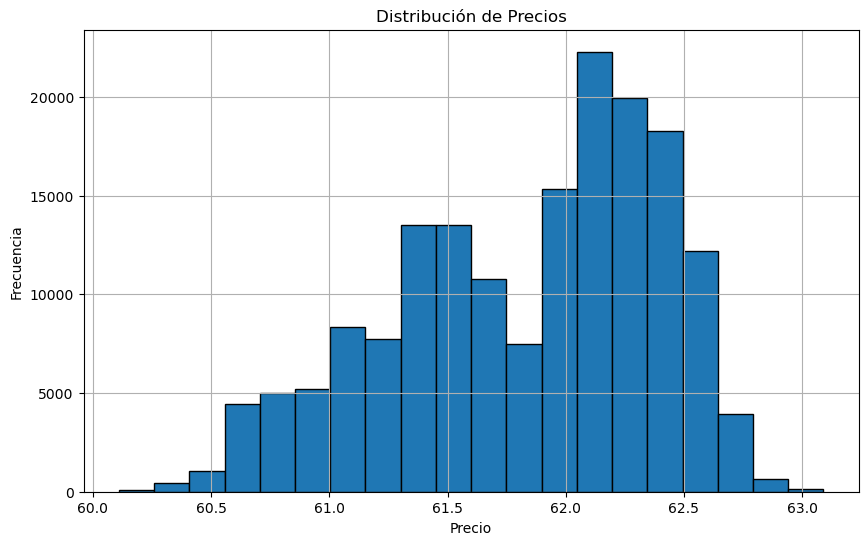

In [32]:
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import col
from pyspark.sql.functions import to_date

# Convertir la columna trade_time a tipo timestamp en PySpark
df_a = df_a.withColumn('trade_time', to_timestamp('trade_time'))

# Convertir la columna 'price' a tipo double (si aún no lo es)
df_a = df_a.withColumn('price', col('price').cast('double'))

# Extraer la fecha de 'trade_time'
df_a = df_a.withColumn('date', to_date('trade_time'))

# Convertir el DataFrame de PySpark a pandas
df_pandas = df_a.select('price').toPandas()

# Graficamos la distribución de precios diarios
plt.figure(figsize=(10,6))
plt.hist(df_pandas['price'], bins=20, edgecolor='black')
plt.title('Distribución de Precios')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()


In [33]:
from pyspark.sql import functions as F
from pyspark.sql.functions import format_number

# Agrupamos los datos por 'buyer_name' y calculamos las agregaciones usando PySpark, aplicamos format_number a las columnas numéricas

buyer_analysis = df_a.groupBy('buyer_name').agg(
    format_number(F.sum('volume'), 0).alias('total_volume'),
    format_number(F.avg('price'), 2).alias('average_price'),
    format_number(F.sum('amount'), 2).alias('total_amount'),
    F.count('match_number').alias('total_transactions')
)

# Mostrar el análisis de compradores
buyer_analysis.show()

+----------+------------+-------------+----------------+------------------+
|buyer_name|total_volume|average_price|    total_amount|total_transactions|
+----------+------------+-------------+----------------+------------------+
|       JPM|  31,712,592|        61.95|1,970,094,249.78|             33493|
|      CITI|   4,858,357|        62.17|  300,836,174.66|              4559|
|      SANT|   1,602,934|        61.89|   99,170,889.84|              1197|
|      NULL|     917,422|        61.70|   56,934,481.90|                 5|
|     BURSA|      61,726|        61.13|    3,770,799.97|                80|
|      BTGP|   1,809,221|        61.70|  111,712,806.20|              6954|
|     HSBCB|     238,259|        61.93|   14,796,770.07|               349|
|      CICB|   2,520,950|        61.76|  155,738,621.44|              3260|
|       FMX|  44,257,504|        61.90|2,739,555,250.95|             37718|
|     BANOR|   1,810,217|        61.69|  111,422,807.29|              1534|
|        MS|

In [34]:
# Agrupamos los datos por 'buyer_name' y calculamos las agregaciones usando PySpark, aplicamos format_number a las columnas numéricas
seller_analysis = df_a.groupBy('seller_name').agg(
    format_number(F.sum('volume'), 0).alias('total_volume'),
    format_number(F.avg('price'), 2).alias('average_price'),
    format_number(F.sum('amount'), 2).alias('total_amount'),
    F.count('match_number').alias('total_transactions')
)

# Mostrar el análisis de vendedores
seller_analysis.show()

+-----------+------------+-------------+----------------+------------------+
|seller_name|total_volume|average_price|    total_amount|total_transactions|
+-----------+------------+-------------+----------------+------------------+
|        JPM|  26,546,600|        61.95|1,649,051,712.87|             28914|
|       SANT|   4,703,859|        61.50|  290,176,756.05|              4343|
|       CITI|   6,019,845|        61.74|  371,860,151.85|              9056|
|       NULL|     917,422|        61.70|   56,934,481.90|                 5|
|      BURSA|      81,997|        61.88|    5,073,615.90|                99|
|       BTGP|   1,061,964|        61.85|   65,712,814.42|              2892|
|      HSBCB|   1,232,869|        61.78|   76,344,511.04|              4120|
|       CICB|   3,428,669|        61.77|  212,240,285.55|              4514|
|        FMX|  42,391,627|        61.83|2,622,571,502.23|             34000|
|      BANOR|   1,531,072|        61.86|   94,459,517.49|              1256|

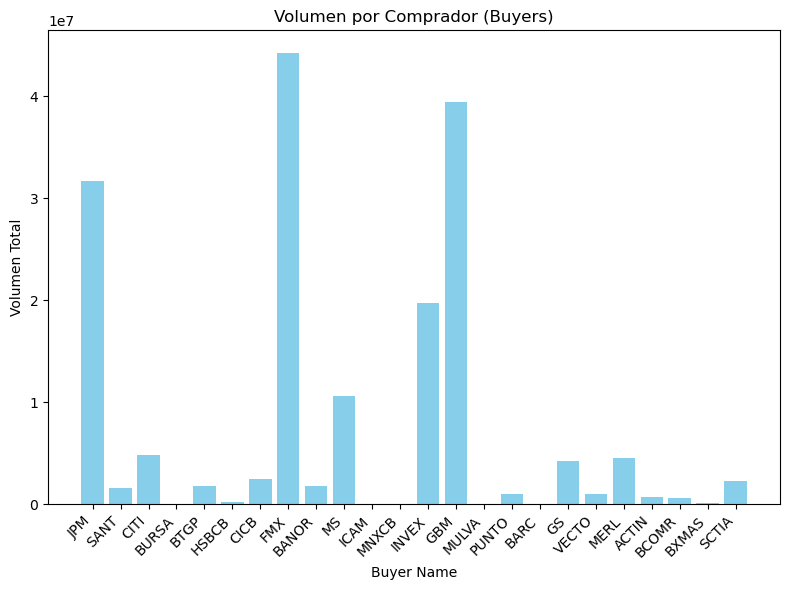

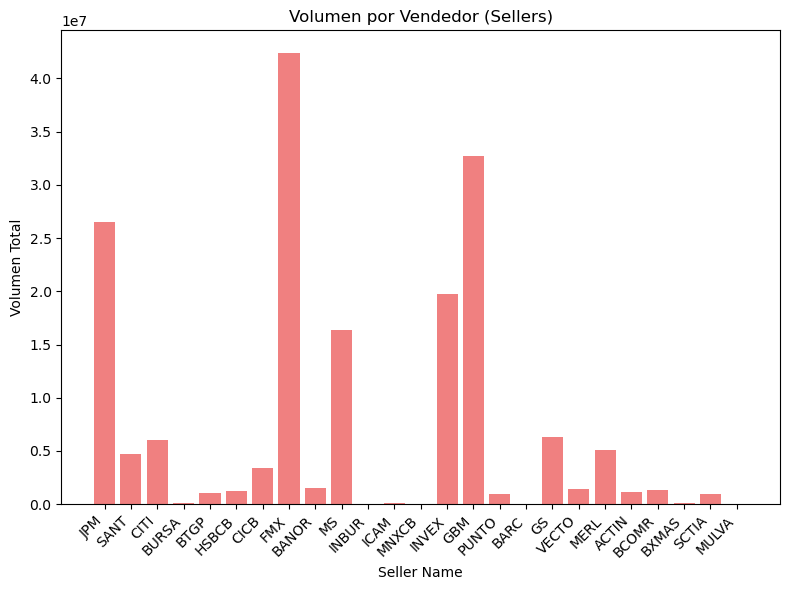

In [35]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Agrupar los datos por 'buyer_name' y 'seller_name' y sumar el volumen
buyer_volume = df_a.groupBy('buyer_name').agg(F.sum('volume').alias('volume')).filter(F.col('buyer_name').isNotNull()).toPandas()
seller_volume = df_a.groupBy('seller_name').agg(F.sum('volume').alias('volume')).filter(F.col('seller_name').isNotNull()).toPandas()

# Gráfica para el volumen por comprador (Buyers)
plt.figure(figsize=(8, 6))
plt.bar(buyer_volume['buyer_name'], buyer_volume['volume'], color='skyblue')
plt.title('Volumen por Comprador (Buyers)')
plt.xlabel('Buyer Name')
plt.ylabel('Volumen Total')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Gráfica para el volumen por vendedor (Sellers)
plt.figure(figsize=(8, 6))
plt.bar(seller_volume['seller_name'], seller_volume['volume'], color='lightcoral')
plt.title('Volumen por Vendedor (Sellers)')
plt.xlabel('Seller Name')
plt.ylabel('Volumen Total')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


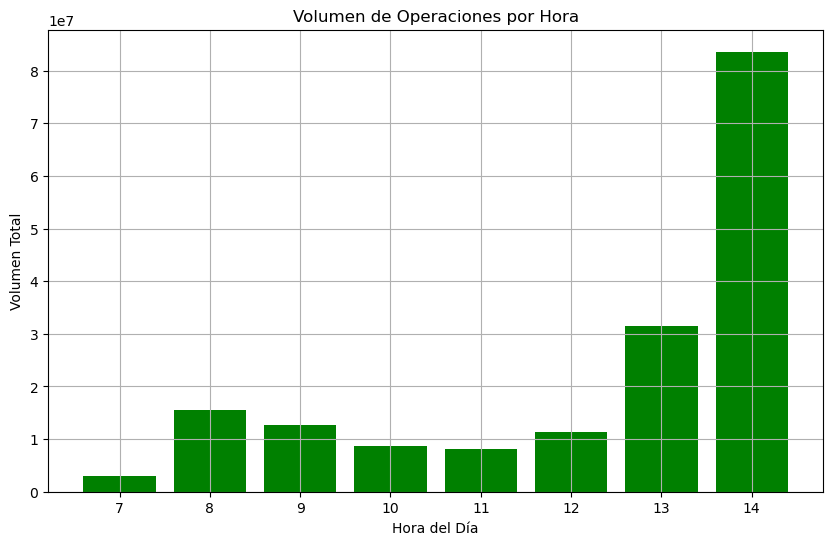

In [36]:
from pyspark.sql.functions import hour

# Crear una nueva columna 'hour' extrayendo la hora de 'trade_time'
df_a = df_a.withColumn('hour', hour('trade_time'))

# Agrupar por la columna 'hour' y sumar los volúmenes
hourly_volume = df_a.groupBy('hour').agg(F.sum('volume').alias('total_volume')).orderBy('hour').toPandas()

# Graficar el volumen por hora
plt.figure(figsize=(10,6))
plt.bar(hourly_volume['hour'], hourly_volume['total_volume'], color='green')
plt.title('Volumen de Operaciones por Hora')
plt.xlabel('Hora del Día')
plt.ylabel('Volumen Total')
plt.grid(True)
plt.show()


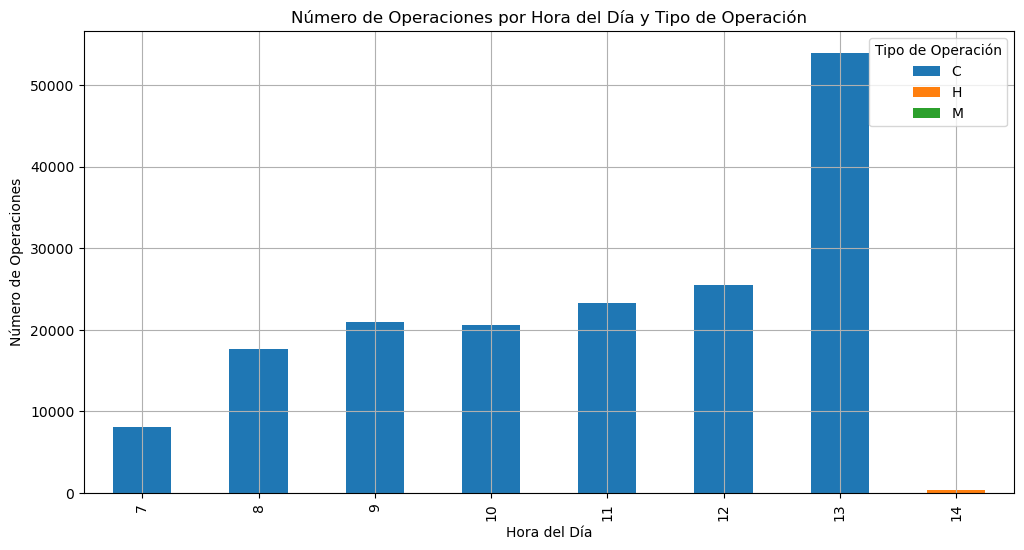

In [37]:
# Agrupar los datos por 'operation_type' y 'hour' y contar las ocurrencias
operation_hour_analysis = df_a.groupBy('operation_type', 'hour').count().orderBy('hour').toPandas()

# Crear una gráfica de barras apiladas para mostrar el número de operaciones por tipo y hora del día
operation_hour_pivot = operation_hour_analysis.pivot(index='hour', columns='operation_type', values='count').fillna(0)

# Graficar el análisis por hora del día y tipo de operación
operation_hour_pivot.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title('Número de Operaciones por Hora del Día y Tipo de Operación')
plt.xlabel('Hora del Día')
plt.ylabel('Número de Operaciones')
plt.legend(title='Tipo de Operación')
plt.grid(True)
plt.show()


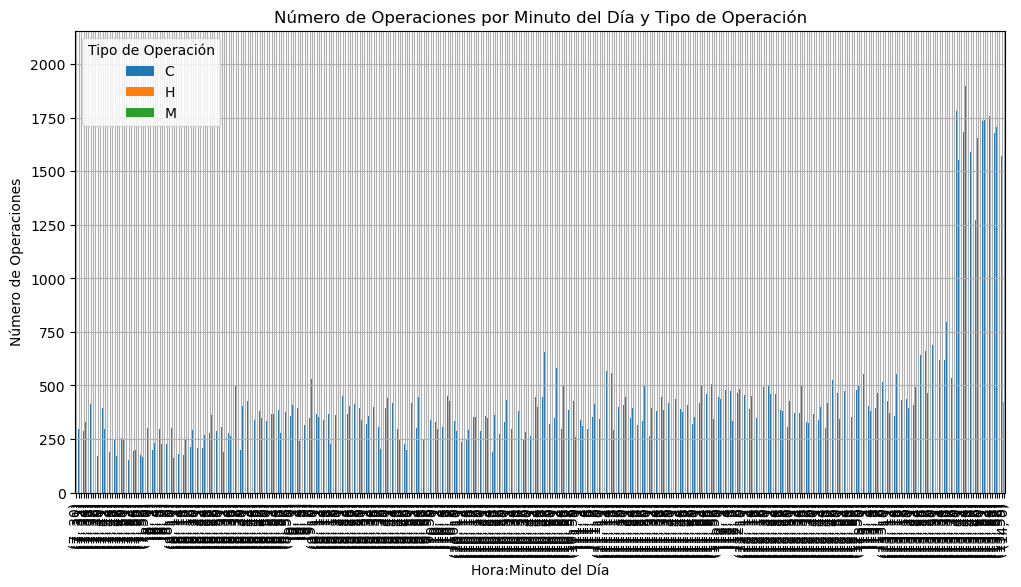

In [38]:
from pyspark.sql.functions import minute

# Crear una nueva columna 'minute' extrayendo el minuto de 'trade_time'
df_a = df_a.withColumn('minute', minute('trade_time'))

# Agrupar los datos por 'operation_type' y 'minute' y contar las ocurrencias
operation_minute_analysis = df_a.groupBy('operation_type', 'hour', 'minute').count().orderBy('hour', 'minute').toPandas()

# Crear una tabla pivote para organizar los datos para el gráfico
operation_minute_pivot = operation_minute_analysis.pivot(index=['hour', 'minute'], columns='operation_type', values='count').fillna(0)

# Graficar el análisis por minuto del día y tipo de operación
operation_minute_pivot.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title('Número de Operaciones por Minuto del Día y Tipo de Operación')
plt.xlabel('Hora:Minuto del Día')
plt.ylabel('Número de Operaciones')
plt.legend(title='Tipo de Operación')
plt.grid(True)
plt.show()


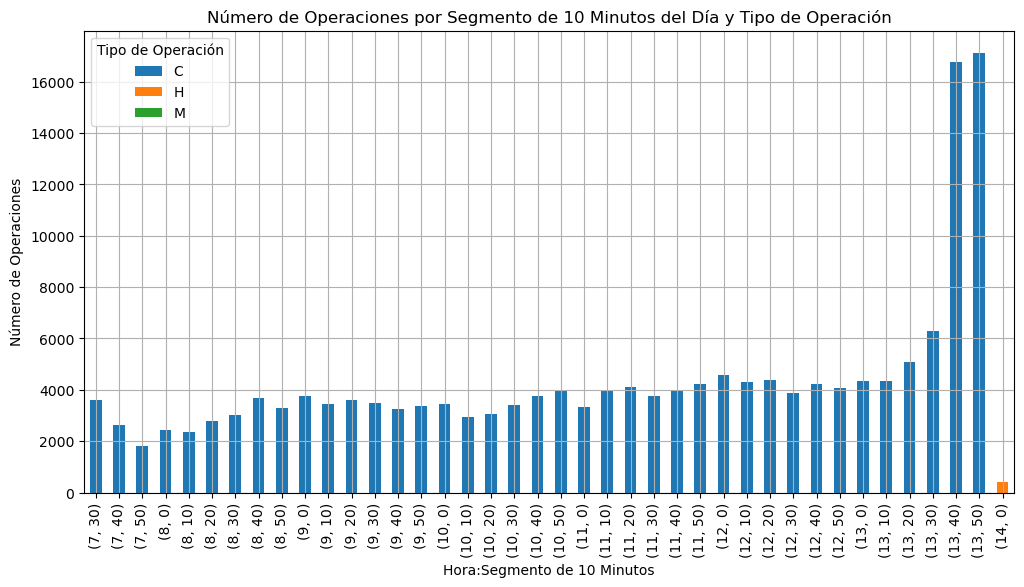

In [39]:
from pyspark.sql.functions import minute, floor

# Crear una nueva columna 'minute_segment' para agrupar por intervalos de 10 minutos
df_a = df_a.withColumn('minute_segment', (floor(minute('trade_time') / 10) * 10))

# Agrupar los datos por 'operation_type', 'hour' y el segmento de minutos
operation_minute_segment_analysis = df_a.groupBy('operation_type', 'hour', 'minute_segment').count().orderBy('hour', 'minute_segment').toPandas()

# Crear una tabla pivote para organizar los datos para el gráfico
operation_minute_segment_pivot = operation_minute_segment_analysis.pivot(index=['hour', 'minute_segment'], columns='operation_type', values='count').fillna(0)

# Graficar el análisis por segmento de 10 minutos del día y tipo de operación
operation_minute_segment_pivot.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title('Número de Operaciones por Segmento de 10 Minutos del Día y Tipo de Operación')
plt.xlabel('Hora:Segmento de 10 Minutos')
plt.ylabel('Número de Operaciones')
plt.legend(title='Tipo de Operación')
plt.grid(True)
plt.show()


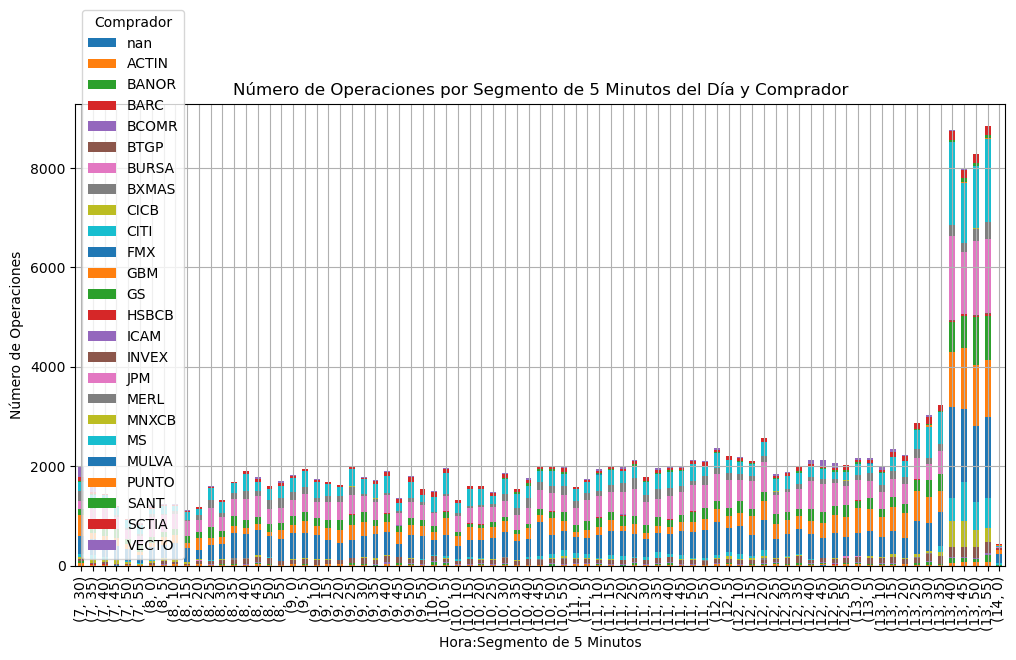

In [40]:
from pyspark.sql.functions import minute, floor

# Crear una nueva columna 'minute_segment' para agrupar en intervalos de 5 minutos
df_a = df_a.withColumn('minute_segment', (floor(minute('trade_time') / 5) * 5))

# Agrupar los datos por 'buyer_name', 'hour', y el segmento de 5 minutos
buyer_minute_segment_analysis = df_a.groupBy('buyer_name', 'hour', 'minute_segment').count().orderBy('hour', 'minute_segment').toPandas()

# Crear una tabla pivote para organizar los datos para el gráfico
buyer_minute_segment_pivot = buyer_minute_segment_analysis.pivot(index=['hour', 'minute_segment'], columns='buyer_name', values='count').fillna(0)

# Graficar el análisis por segmento de 5 minutos del día y comprador
buyer_minute_segment_pivot.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title('Número de Operaciones por Segmento de 5 Minutos del Día y Comprador')
plt.xlabel('Hora:Segmento de 5 Minutos')
plt.ylabel('Número de Operaciones')
plt.legend(title='Comprador')
plt.grid(True)
plt.show()


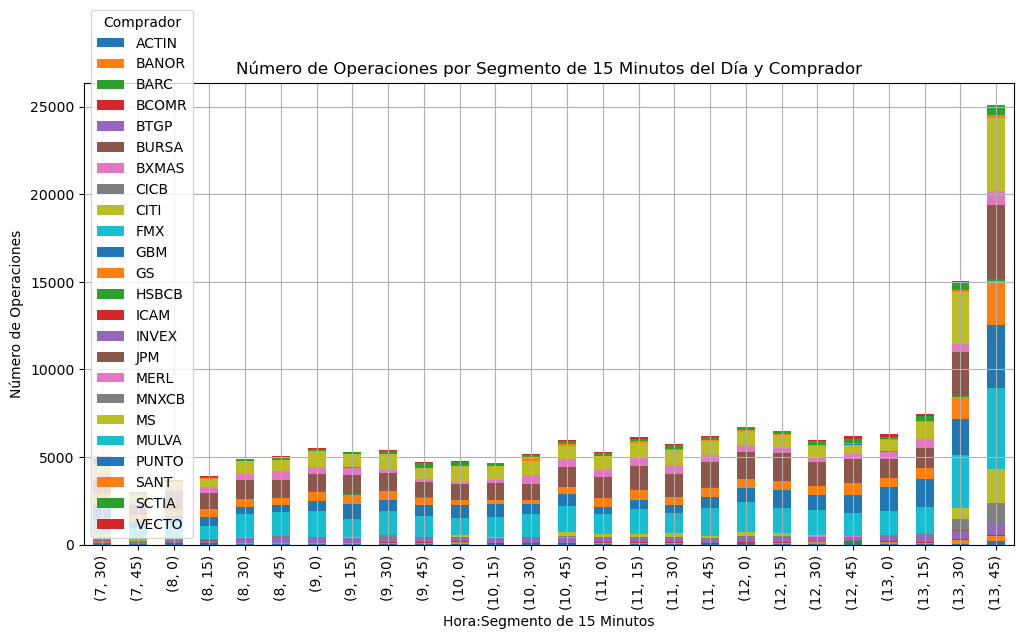

In [41]:
from pyspark.sql.functions import minute, floor, col

# Filtrar los datos para incluir solo registros donde 'operation_type' sea "C"
filtered_df = df_a.filter(col('operation_type') == 'C')

# Crear una nueva columna 'minute_segment' para agrupar en intervalos de 15 minutos
filtered_df = filtered_df.withColumn('minute_segment', (floor(minute('trade_time') / 15) * 15))

# Agrupar los datos por 'buyer_name', 'hour', y el segmento de 15 minutos y sumar las transacciones
buyer_minute_segment_analysis = filtered_df.groupBy('buyer_name', 'hour', 'minute_segment') \
    .agg(F.count('buyer_name').alias('transaction_count')).orderBy('hour', 'minute_segment').toPandas()

# Crear una tabla pivote para organizar los datos para el gráfico de compradores
buyer_minute_segment_pivot = buyer_minute_segment_analysis.pivot_table(index=['hour', 'minute_segment'], columns='buyer_name', values='transaction_count', aggfunc='sum').fillna(0)

# Graficar el análisis por segmento de 15 minutos del día y comprador
buyer_minute_segment_pivot.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title('Número de Operaciones por Segmento de 15 Minutos del Día y Comprador')
plt.xlabel('Hora:Segmento de 15 Minutos')
plt.ylabel('Número de Operaciones')
plt.legend(title='Comprador')
plt.grid(True)
plt.show()


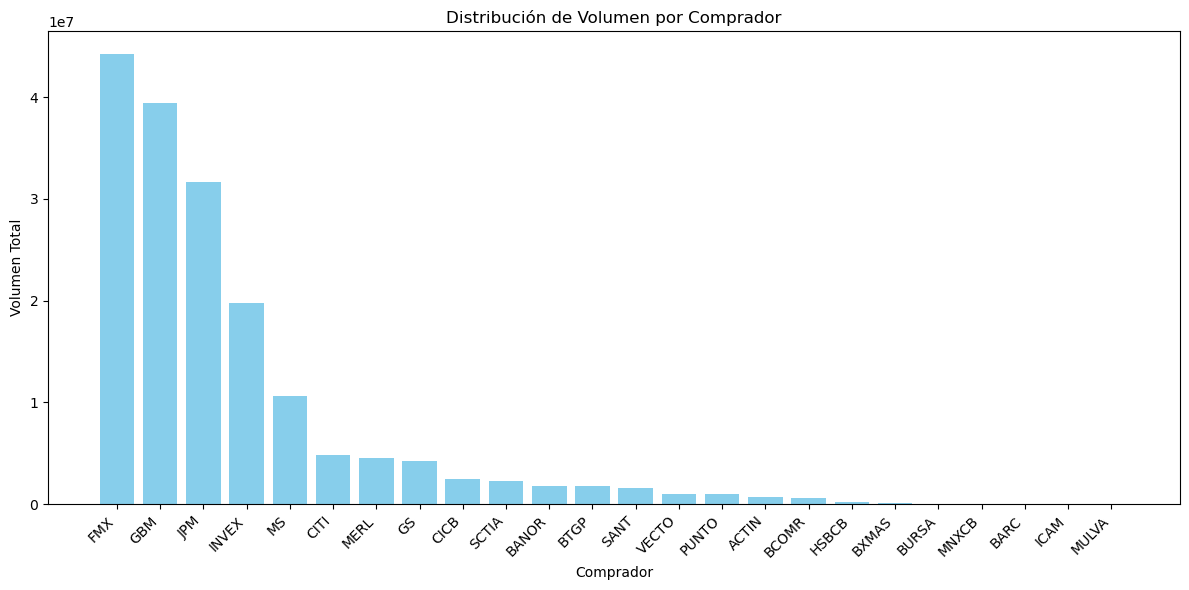

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import functions as F

# Agrupar por 'buyer_name' y sumar el volumen, filtrando valores nulos en 'buyer_name'
buyer_volume_df = df_a.filter(F.col('buyer_name').isNotNull()).groupBy('buyer_name').agg(F.sum('volume').alias('total_volume'))

# Convertir a Pandas para facilitar la visualización
buyer_volume_pd = buyer_volume_df.orderBy(F.desc('total_volume')).toPandas()

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(buyer_volume_pd['buyer_name'], buyer_volume_pd['total_volume'], color='skyblue')
plt.title('Distribución de Volumen por Comprador')
plt.xlabel('Comprador')
plt.ylabel('Volumen Total')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [43]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# 1. Registro de transacciones (por casa de bolsa)
# Agrupar transacciones por 'buyer_name', 'seller_name', 'symbol', y fecha, sumando el volumen
transactions_df = df_a.groupBy('buyer_name', 'seller_name', 'symbol', F.to_date('trade_time').alias('trade_date')) \
    .agg(F.sum('volume').alias('total_volume'),
         F.avg('price').alias('avg_price'),
         F.sum(F.col('price') * F.col('volume')).alias('total_amount'))

# 2. Calcular precio de cierre por día
# Definir una ventana para obtener el precio de cierre (última transacción del día)
day_window = Window.partitionBy('symbol', F.to_date('trade_time')).orderBy(F.col('trade_time').desc())

# Obtener el precio de cierre del día para cada transacción
df_a = df_a.withColumn('closing_price', F.first('price').over(day_window))

# 3. Comparar con el precio de cierre y calcular ganancias/pérdidas
# Calcular ganancia/pérdida por transacción comparando el precio de compra/venta con el precio de cierre
df_a = df_a.withColumn('gain_loss', F.when(F.col('buyer_name').isNotNull(),
                                           (F.col('closing_price') - F.col('price')) * F.col('volume')) \
                                   .otherwise((F.col('price') - F.col('closing_price')) * F.col('volume')))

# 4. Control diario por casa de bolsa
# Resumir ganancias/pérdidas y calcular la precisión respecto al precio de cierre
daily_summary = df_a.groupBy('buyer_name', F.to_date('trade_time').alias('trade_date')) \
    .agg(F.sum('gain_loss').alias('total_gain_loss'),
         F.avg(F.abs(F.col('price') - F.col('closing_price'))).alias('avg_price_diff'))

# Mostrar el resumen diario de las casas de bolsa
# daily_summary.show()

In [44]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Crear una ventana para obtener el precio de cierre (última transacción del día)
day_window = Window.partitionBy('symbol', F.to_date('trade_time')).orderBy(F.col('trade_time').desc())

# Obtener el precio de cierre del día
df_a = df_a.withColumn('closing_price', F.first('price').over(day_window))

# Calcular las ganancias/pérdidas por transacción
# Para compradores: (precio de cierre - precio de compra) * volumen
# Para vendedores: (precio de venta - precio de cierre) * volumen
df_a = df_a.withColumn('gain_loss', 
    F.when(F.col('buyer_name').isNotNull(), 
           (F.col('closing_price') - F.col('price')) * F.col('volume')) \
    .otherwise((F.col('price') - F.col('closing_price')) * F.col('volume'))
)

In [45]:
# Ganancias netas diarias por casa de bolsa
daily_net_gain = df_a.groupBy('buyer_name', F.to_date('trade_time').alias('trade_date')) \
    .agg(F.sum('gain_loss').alias('net_gain_loss'))

# Mostrar resultados diarios
# daily_net_gain.show()

In [46]:
# Agregar semana de transacción
df_a = df_a.withColumn('week_of_year', F.weekofyear('trade_time'))

# Ganancias netas semanales por casa de bolsa
weekly_net_gain = df_a.groupBy('buyer_name', 'week_of_year') \
    .agg(F.sum('gain_loss').alias('net_gain_loss'))

# Mostrar resultados semanales
# weekly_net_gain.show()

In [47]:
# Agregar mes de transacción
df_a = df_a.withColumn('month_of_year', F.month('trade_time'))

# Ganancias netas mensuales por casa de bolsa
monthly_net_gain = df_a.groupBy('buyer_name', 'month_of_year') \
    .agg(F.sum('gain_loss').alias('net_gain_loss'))

# Mostrar resultados mensuales
# monthly_net_gain.show()

In [48]:
df_a.head(3)

[Row(trade_time=datetime.datetime(2024, 6, 24, 14, 0, 5), match_number=17219, instrument_id=5, timestamp=datetime.datetime(2024, 6, 24, 14, 0, 5, 223000), volume=7000, price=60.64, amount=424480.0, buyer_id=54, buyer_name='MERL', seller_id=28, seller_name='INVEX', operation_type='H', concertation_type='H', price_setter=0, lot=0, symbol='WALMEX*', last_day_close=60.71, last_day_close_date=datetime.datetime(2024, 6, 24, 12, 53, 28), unitary_daily_variation=-0.07000000000000028, percentage_daily_variation=-0.11530225662988022, last_week_close=60.71, last_week_close_date=datetime.datetime(2024, 6, 24, 12, 53, 28), unitary_weekly_variation=-0.07000000000000028, percentage_weekly_variation=-0.11530225662988022, last_month_close=60.71, last_month_close_date=datetime.datetime(2024, 6, 24, 12, 53, 28), unitary_monthly_variation=-0.07000000000000028, percentage_monthly_variation=-0.11530225662988022, date=datetime.date(2024, 6, 24), hour=14, minute=0, minute_segment=0, closing_price=60.64, gain_

In [49]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import functions as F

# Añadir nuevas columnas basadas en la fecha, hora y día de la semana (en formato numérico)
df_a = df_a.withColumn('trade_date', F.to_date('trade_time')) \
           .withColumn('hour', F.hour('trade_time')) \
           .withColumn('minute', F.minute('trade_time')) \
           .withColumn('day_of_week_num', (F.dayofweek('trade_time') - 1))  # Ajustamos para que lunes sea 0

# Seleccionar las columnas numéricas relevantes para el análisis, incluyendo el día de la semana numérico
relevant_columns = ['price', 'volume', 'amount', 'hour', 'minute', 'day_of_week_num']

# Crear una matriz de covarianza vacía
covariance_matrix = {}

# Calcular la covarianza entre cada par de columnas numéricas
for col1 in relevant_columns:
    covariance_matrix[col1] = {}
    for col2 in relevant_columns:
        covariance = df_a.stat.cov(col1, col2)
        covariance_matrix[col1][col2] = covariance

# Convertir la matriz de covarianza a un DataFrame de pandas para mostrarla
covariance_df = pd.DataFrame(covariance_matrix)

# Mostrar la matriz de covarianza
print("Matriz de Covarianza:")
print(covariance_df)


Matriz de Covarianza:
                       price        volume        amount          hour  \
price               0.313906  6.359797e+01  4.241208e+03     -0.010626   
volume             63.597972  1.056766e+09  6.553177e+10   1442.317562   
amount           4241.208219  6.553177e+10  4.063971e+12  89167.551529   
hour               -0.010626  1.442318e+03  8.916755e+04      3.731503   
minute              0.531167 -1.648548e+04 -1.019430e+06      2.941392   
day_of_week_num     0.228840 -5.115830e+01 -3.099533e+03     -0.117767   

                       minute  day_of_week_num  
price            5.311667e-01         0.228840  
volume          -1.648548e+04       -51.158304  
amount          -1.019430e+06     -3099.532806  
hour             2.941392e+00        -0.117767  
minute           2.992616e+02         0.357828  
day_of_week_num  3.578283e-01         1.824068  


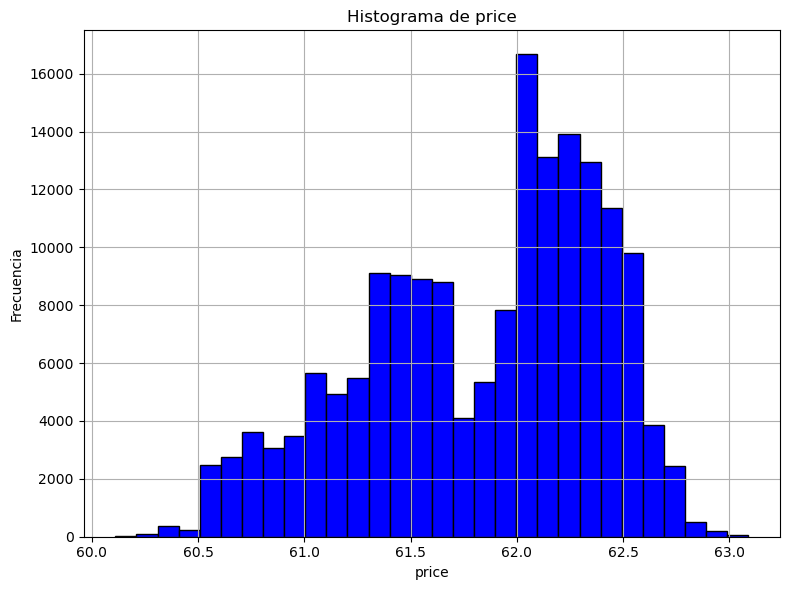

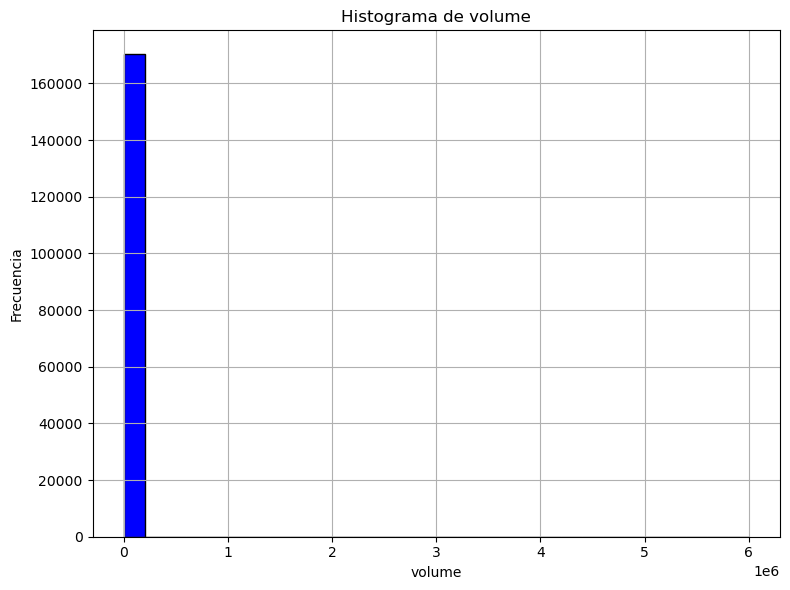

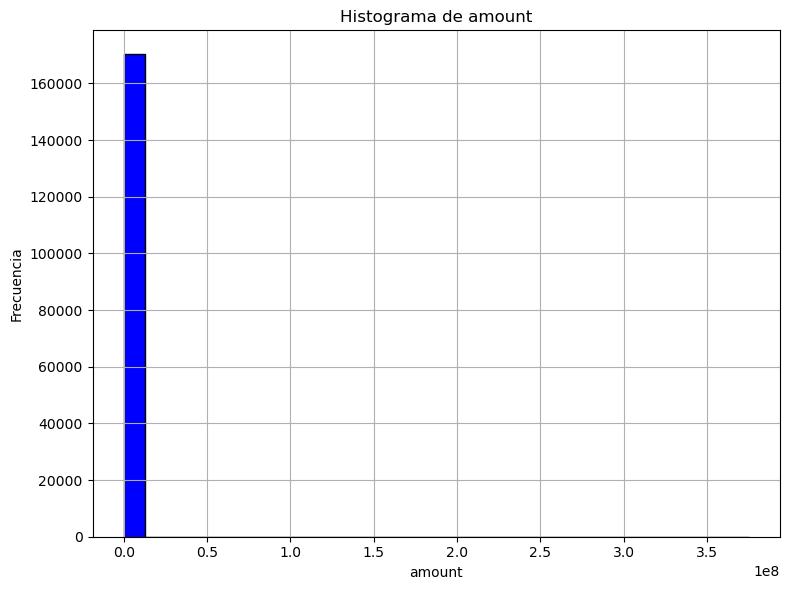

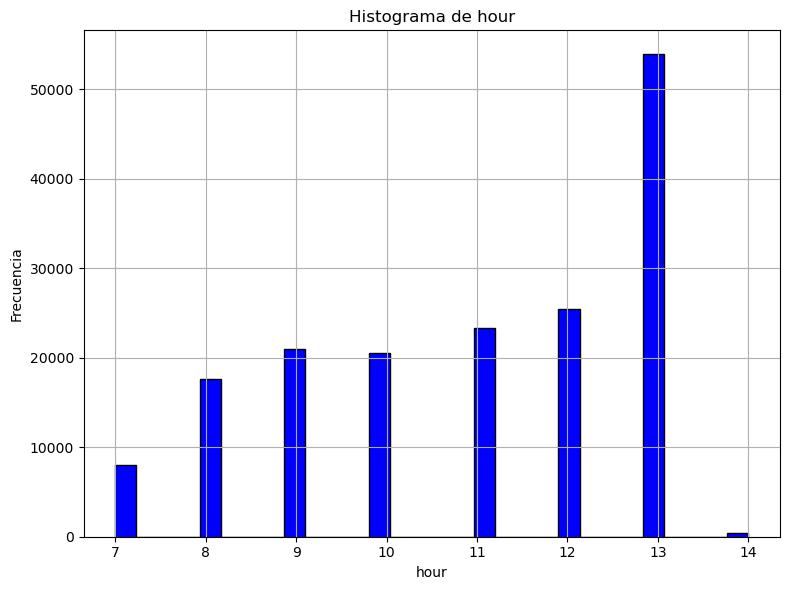

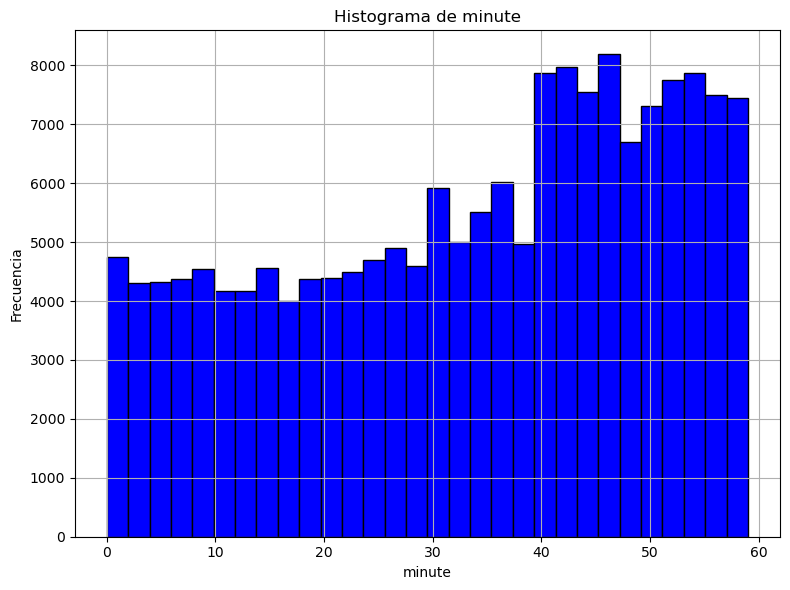

In [50]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# Añadir nuevas columnas basadas en la fecha y hora
df_a = df_a.withColumn('trade_date', F.to_date('trade_time')) \
           .withColumn('day_of_week', F.date_format('trade_time', 'E')) \
           .withColumn('hour', F.hour('trade_time')) \
           .withColumn('minute', F.minute('trade_time'))

# Seleccionar las columnas relevantes para el análisis
relevant_columns = ['price', 'volume', 'amount', 'trade_date', 'day_of_week', 'hour', 'minute']

# Convertir el DataFrame de PySpark a un DataFrame de pandas
df_pandas = df_a.select(relevant_columns).toPandas()

# Crear histogramas para las variables cuantitativas
quantitative_columns = ['price', 'volume', 'amount', 'hour', 'minute']
for column in quantitative_columns:
    plt.figure(figsize=(8, 6))
    plt.hist(df_pandas[column].dropna(), bins=30, color='blue', edgecolor='black')
    plt.title(f'Histograma de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

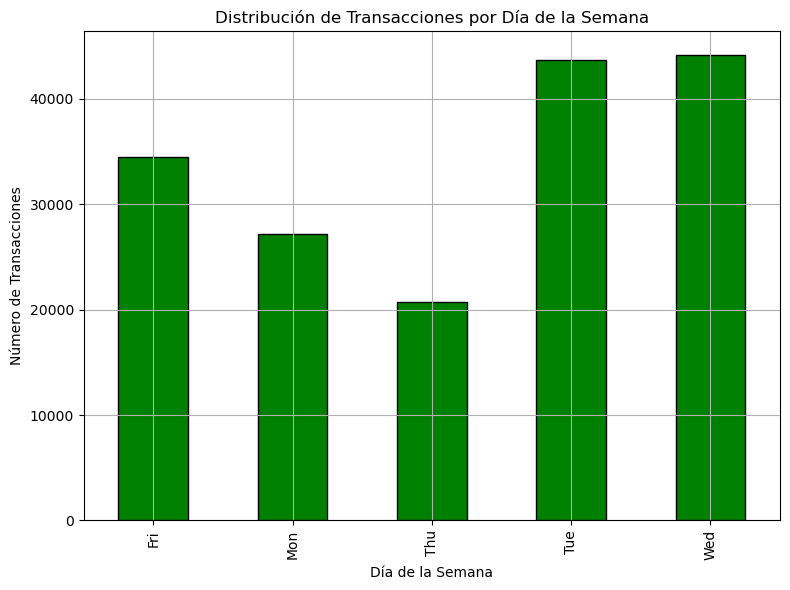

In [51]:
# Crear gráfico de barras para la distribución por día de la semana
plt.figure(figsize=(8, 6))
df_pandas['day_of_week'].value_counts().sort_index().plot(kind='bar', color='green', edgecolor='black')
plt.title('Distribución de Transacciones por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Número de Transacciones')
plt.grid(True)
plt.tight_layout()
plt.show()

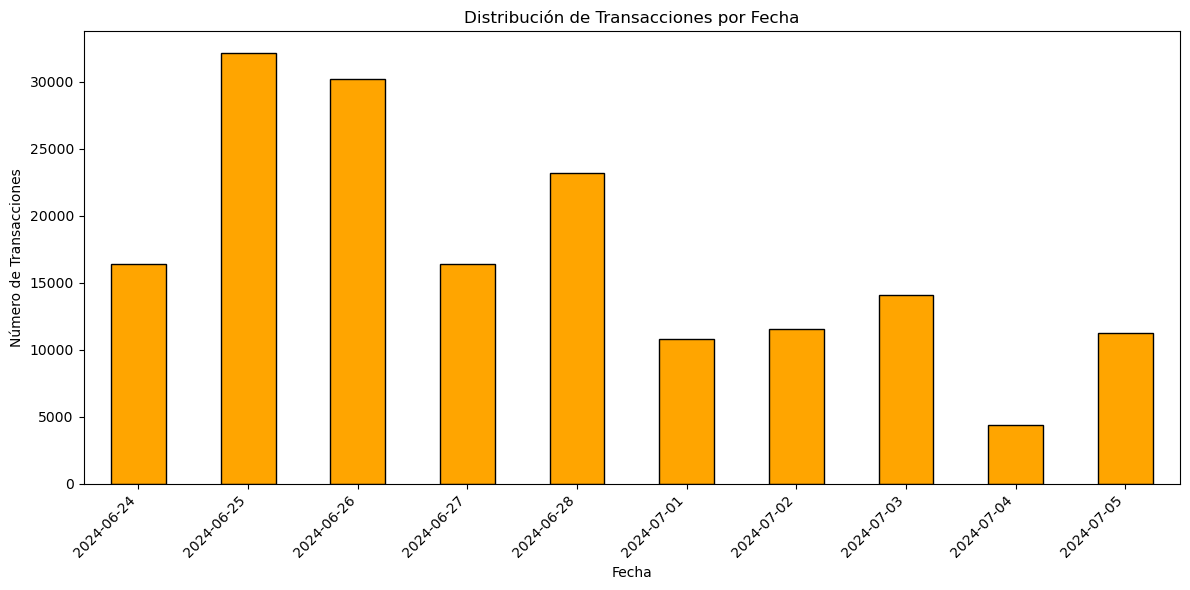

In [52]:
# Crear gráfico de barras para la distribución por fecha
plt.figure(figsize=(12, 6))
df_pandas['trade_date'].value_counts().sort_index().plot(kind='bar', color='orange', edgecolor='black')
plt.title('Distribución de Transacciones por Fecha')
plt.xlabel('Fecha')
plt.ylabel('Número de Transacciones')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

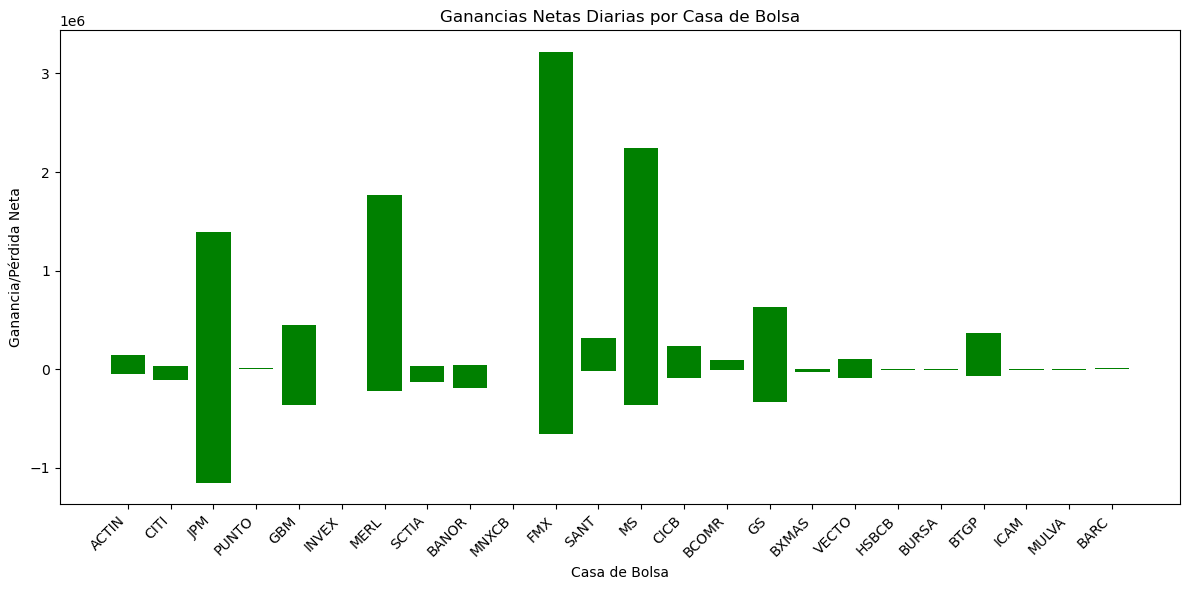

In [53]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# Filtrar los valores nulos en 'buyer_name' y calcular las ganancias netas diarias por casa de bolsa
daily_net_gain = df_a.filter(F.col('buyer_name').isNotNull()) \
    .groupBy('buyer_name', F.to_date('trade_time').alias('trade_date')) \
    .agg(F.sum('gain_loss').alias('net_gain_loss'))

# Convertir a Pandas para graficar
daily_net_gain_pd = daily_net_gain.toPandas()

# Verificar si hay datos para graficar
if not daily_net_gain_pd.empty:
    # Graficar las ganancias netas diarias por casa de bolsa
    plt.figure(figsize=(12, 6))
    plt.bar(daily_net_gain_pd['buyer_name'], daily_net_gain_pd['net_gain_loss'], color='green')
    plt.title('Ganancias Netas Diarias por Casa de Bolsa')
    plt.xlabel('Casa de Bolsa')
    plt.ylabel('Ganancia/Pérdida Neta')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("No hay datos para graficar.")


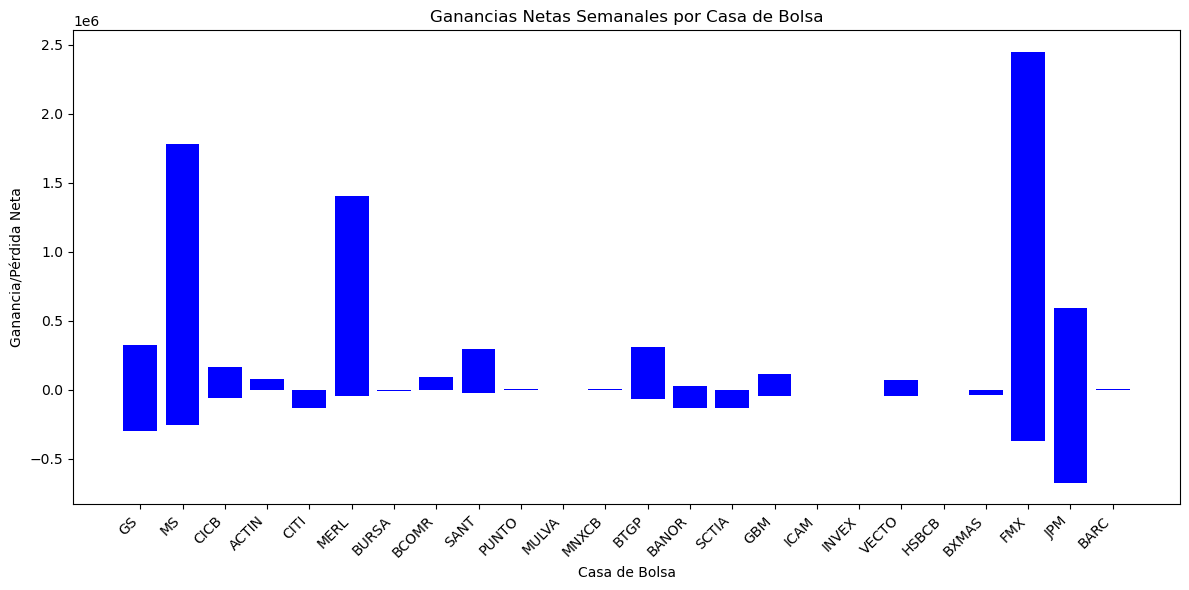

In [54]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# Agregar semana de transacción
df_a = df_a.withColumn('week_of_year', F.weekofyear('trade_time'))

# Filtrar valores nulos en 'buyer_name' y calcular las ganancias netas semanales por casa de bolsa
weekly_net_gain = df_a.filter(F.col('buyer_name').isNotNull()) \
    .groupBy('buyer_name', 'week_of_year') \
    .agg(F.sum('gain_loss').alias('net_gain_loss'))

# Convertir a Pandas para graficar
weekly_net_gain_pd = weekly_net_gain.toPandas()

# Verificar si hay datos válidos para graficar
if not weekly_net_gain_pd.empty:
    # Graficar las ganancias netas semanales por casa de bolsa
    plt.figure(figsize=(12, 6))
    plt.bar(weekly_net_gain_pd['buyer_name'], weekly_net_gain_pd['net_gain_loss'], color='blue')
    plt.title('Ganancias Netas Semanales por Casa de Bolsa')
    plt.xlabel('Casa de Bolsa')
    plt.ylabel('Ganancia/Pérdida Neta')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("No hay datos para graficar.")


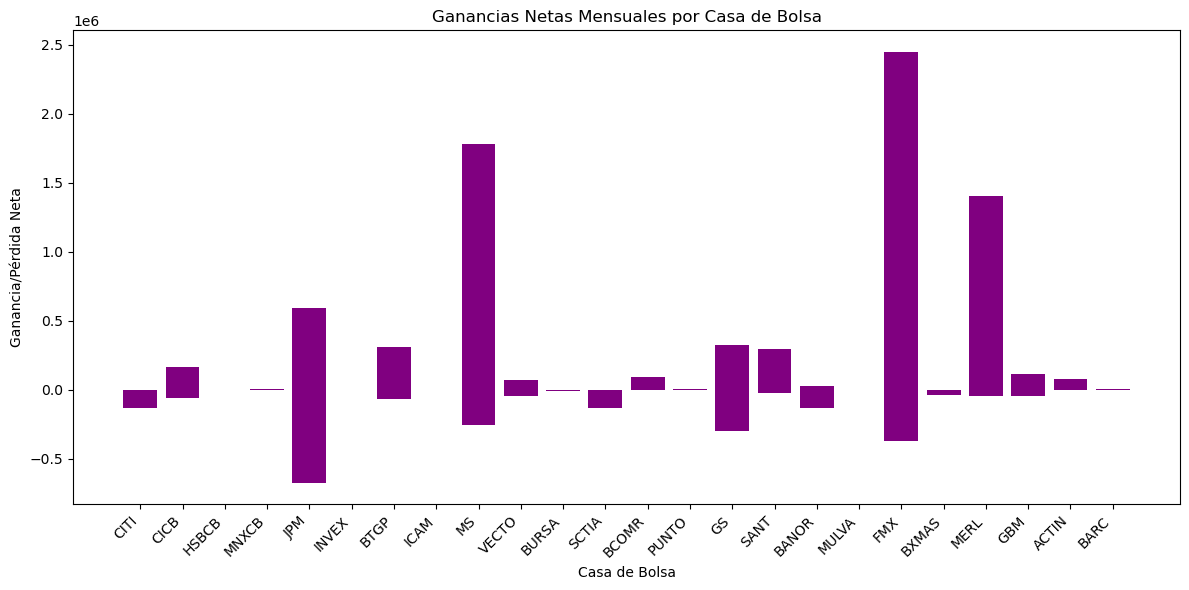

In [55]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# Agregar mes de transacción
df_a = df_a.withColumn('month_of_year', F.month('trade_time'))

# Filtrar valores nulos en 'buyer_name' y calcular las ganancias netas mensuales por casa de bolsa
monthly_net_gain = df_a.filter(F.col('buyer_name').isNotNull()) \
    .groupBy('buyer_name', 'month_of_year') \
    .agg(F.sum('gain_loss').alias('net_gain_loss'))

# Convertir a Pandas para graficar
monthly_net_gain_pd = monthly_net_gain.toPandas()

# Verificar si hay datos válidos para graficar
if not monthly_net_gain_pd.empty:
    # Graficar las ganancias netas mensuales por casa de bolsa
    plt.figure(figsize=(12, 6))
    plt.bar(monthly_net_gain_pd['buyer_name'], monthly_net_gain_pd['net_gain_loss'], color='purple')
    plt.title('Ganancias Netas Mensuales por Casa de Bolsa')
    plt.xlabel('Casa de Bolsa')
    plt.ylabel('Ganancia/Pérdida Neta')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("No hay datos para graficar.")


In [56]:
# 2. Medición de Rendimiento por Casas de Bolsa
#    a. Análisis de Performance
#    b. Volatilidad por Casa de Bolsa
#    c. Proporción de Ganancias

1. Análisis de Performance (Ganancia/Pérdida Neta Acumulada)
Un gráfico de barras es útil para mostrar las ganancias/pérdidas netas acumuladas por cada casa de bolsa. Esto facilita la comparación entre compradores y vendedores.

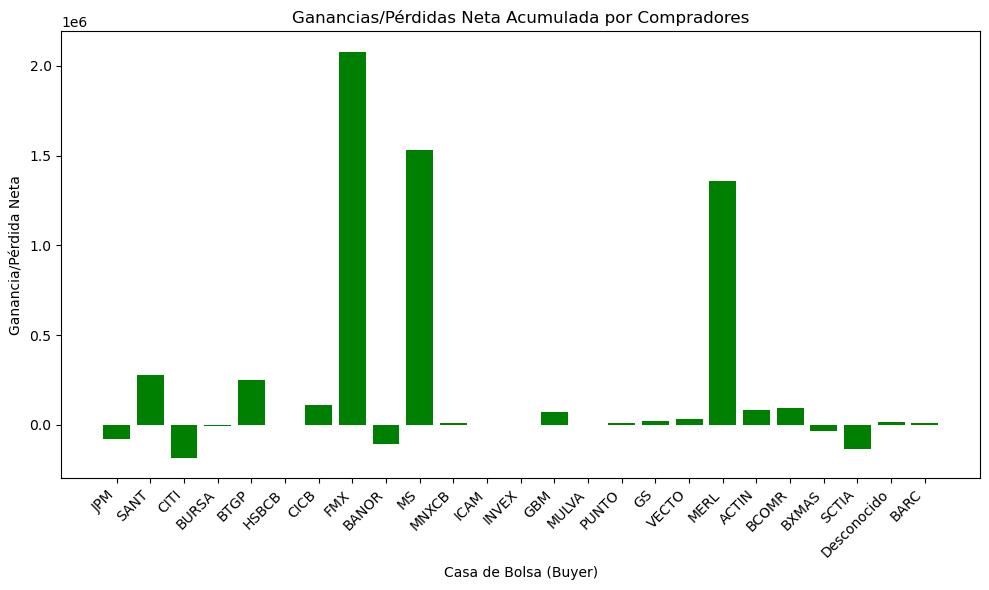

In [57]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# Agrupar por comprador y sumar las ganancias/pérdidas
performance_by_buyer = df_a.groupBy('buyer_name').agg(F.sum('gain_loss').alias('total_gain_loss'))
performance_by_seller = df_a.groupBy('seller_name').agg(F.sum('gain_loss').alias('total_gain_loss'))

# Convertir a Pandas para manipular y graficar
performance_by_buyer_pd = performance_by_buyer.toPandas()
performance_by_seller_pd = performance_by_seller.toPandas()

# Reemplazar valores nulos en buyer_name con 'Desconocido'
performance_by_buyer_pd['buyer_name'] = performance_by_buyer_pd['buyer_name'].fillna('Desconocido')

# Filtrar filas donde 'buyer_name' o 'total_gain_loss' no sean nulos
performance_by_buyer_pd = performance_by_buyer_pd.dropna(subset=['buyer_name', 'total_gain_loss'])

# Graficar Ganancias/Pérdidas Acumuladas por Compradores
plt.figure(figsize=(10, 6))
plt.bar(performance_by_buyer_pd['buyer_name'], performance_by_buyer_pd['total_gain_loss'], color='green')
plt.title('Ganancias/Pérdidas Neta Acumulada por Compradores')
plt.xlabel('Casa de Bolsa (Buyer)')
plt.ylabel('Ganancia/Pérdida Neta')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


2. Volatilidad por Casa de Bolsa
Un gráfico de barras también es útil para visualizar la volatilidad de los precios de compra y venta por casa de bolsa. En este caso, la desviación estándar de los precios refleja la volatilidad.

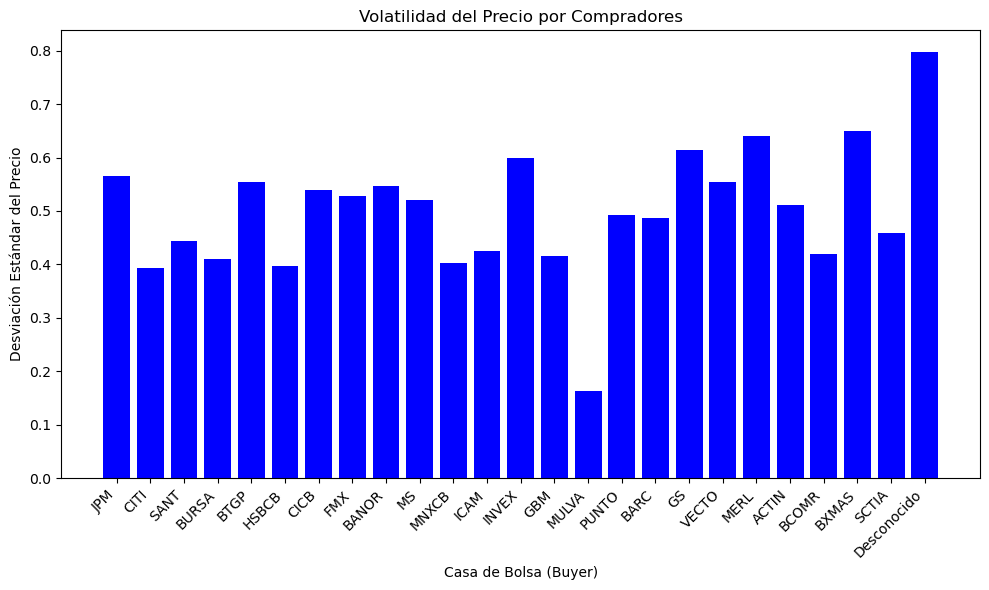

In [58]:
volatility_by_buyer = df_a.groupBy('buyer_name').agg(F.stddev('price').alias('price_volatility'))
volatility_by_seller = df_a.groupBy('seller_name').agg(F.stddev('price').alias('price_volatility'))


# Convertir los resultados de Spark a Pandas
volatility_by_buyer_pd = volatility_by_buyer.toPandas()
volatility_by_seller_pd = volatility_by_seller.toPandas()

import matplotlib.pyplot as plt

# Reemplazar valores nulos en 'buyer_name' con 'Desconocido'
volatility_by_buyer_pd['buyer_name'] = volatility_by_buyer_pd['buyer_name'].fillna('Desconocido')

# Filtrar filas donde 'buyer_name' o 'price_volatility' no sean nulos
volatility_by_buyer_pd = volatility_by_buyer_pd.dropna(subset=['buyer_name', 'price_volatility'])

# Graficar Volatilidad por Compradores
plt.figure(figsize=(10, 6))
plt.bar(volatility_by_buyer_pd['buyer_name'], volatility_by_buyer_pd['price_volatility'], color='blue')
plt.title('Volatilidad del Precio por Compradores')
plt.xlabel('Casa de Bolsa (Buyer)')
plt.ylabel('Desviación Estándar del Precio')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


3. Proporción de Transacciones Rentables
Este gráfico puede ser representado como un gráfico de barras apiladas, donde se visualiza la proporción de transacciones rentables en comparación con el total de transacciones.

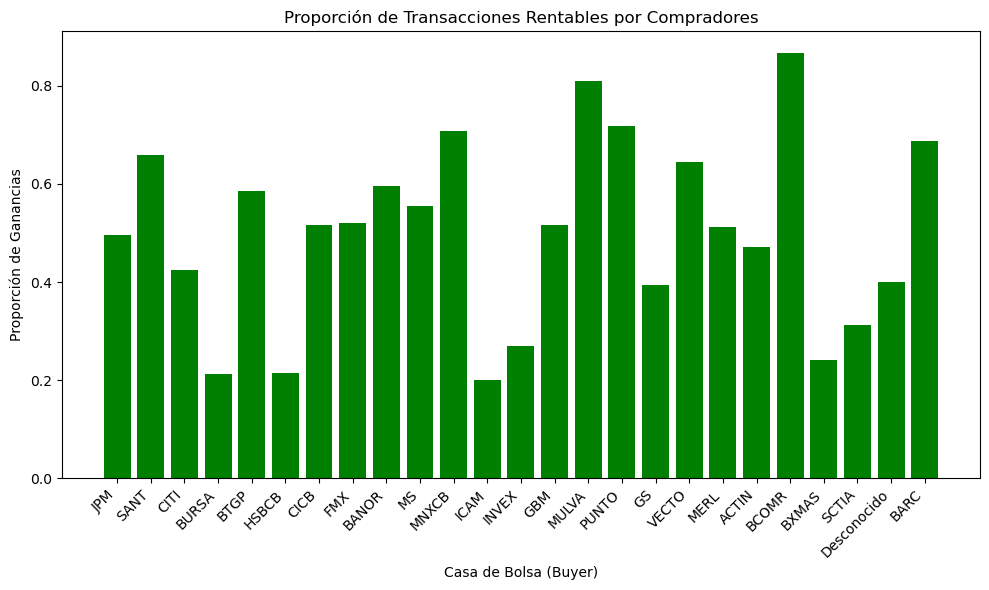

In [59]:
profit_ratio_by_buyer = df_a.groupBy('buyer_name').agg(
    (F.sum(F.when(F.col('gain_loss') > 0, 1).otherwise(0)) / F.count('*')).alias('profit_ratio')
)

profit_ratio_by_seller = df_a.groupBy('seller_name').agg(
    (F.sum(F.when(F.col('gain_loss') > 0, 1).otherwise(0)) / F.count('*')).alias('profit_ratio')
)

# Convertir los resultados de Spark a Pandas
profit_ratio_by_buyer_pd = profit_ratio_by_buyer.toPandas()
profit_ratio_by_seller_pd = profit_ratio_by_seller.toPandas()

volume_by_buyer = df_a.groupBy('buyer_name').agg(F.sum('volume').alias('total_volume'))
volume_by_seller = df_a.groupBy('seller_name').agg(F.sum('volume').alias('total_volume'))

import matplotlib.pyplot as plt

# Reemplazar valores nulos en 'buyer_name' con 'Desconocido'
profit_ratio_by_buyer_pd['buyer_name'] = profit_ratio_by_buyer_pd['buyer_name'].fillna('Desconocido')

# Filtrar filas donde 'buyer_name' o 'profit_ratio' no sean nulos
profit_ratio_by_buyer_pd = profit_ratio_by_buyer_pd.dropna(subset=['buyer_name', 'profit_ratio'])

# Graficar Proporción de Transacciones Rentables por Compradores
plt.figure(figsize=(10, 6))
plt.bar(profit_ratio_by_buyer_pd['buyer_name'], profit_ratio_by_buyer_pd['profit_ratio'], color='green')
plt.title('Proporción de Transacciones Rentables por Compradores')
plt.xlabel('Casa de Bolsa (Buyer)')
plt.ylabel('Proporción de Ganancias')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


4. Volumen Total Transaccionado por Casa de Bolsa
Este gráfico muestra el volumen total transaccionado por cada casa de bolsa. Es útil para identificar qué casas de bolsa dominan en términos de volumen.

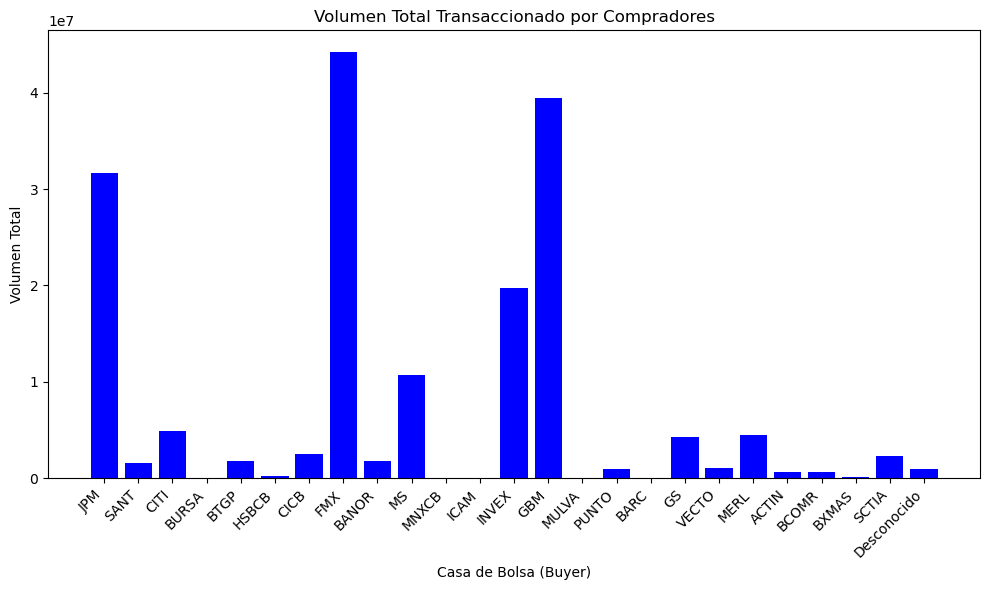

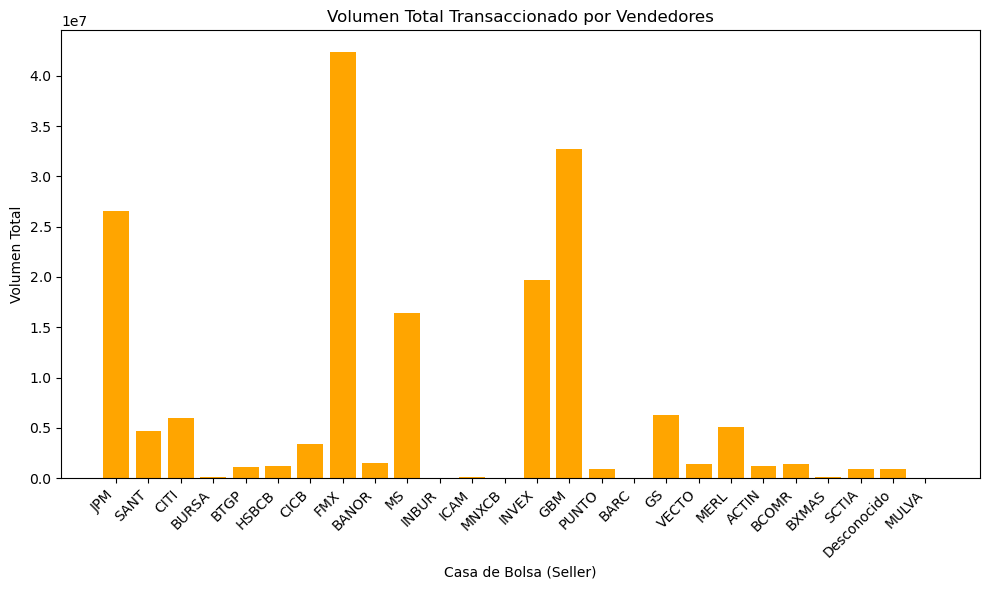

In [60]:
transactions_by_time_buyer = df_a.groupBy('buyer_name', 'hour').count()
transactions_by_time_seller = df_a.groupBy('seller_name', 'hour').count()

transactions_by_day_buyer = df_a.groupBy('buyer_name', 'day_of_week_num').count()
transactions_by_day_seller = df_a.groupBy('seller_name', 'day_of_week_num').count()

# Convertir los resultados de Spark a Pandas
volume_by_buyer_pd = volume_by_buyer.toPandas()
volume_by_seller_pd = volume_by_seller.toPandas()

import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import functions as F

# Manejar valores nulos en 'buyer_name' y 'seller_name'
df_a = df_a.fillna({'buyer_name': 'Desconocido', 'seller_name': 'Desconocido'})

# Agrupar por comprador (buyer_name) y sumar los volúmenes
volume_by_buyer = df_a.groupBy('buyer_name').agg(F.sum('volume').alias('total_volume'))

# Agrupar por vendedor (seller_name) y sumar los volúmenes
volume_by_seller = df_a.groupBy('seller_name').agg(F.sum('volume').alias('total_volume'))

# Convertir a Pandas para graficar
volume_by_buyer_pd = volume_by_buyer.toPandas()
volume_by_seller_pd = volume_by_seller.toPandas()

# Graficar Volumen Total por Compradores
plt.figure(figsize=(10, 6))
plt.bar(volume_by_buyer_pd['buyer_name'], volume_by_buyer_pd['total_volume'], color='blue')
plt.title('Volumen Total Transaccionado por Compradores')
plt.xlabel('Casa de Bolsa (Buyer)')
plt.ylabel('Volumen Total')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Graficar Volumen Total por Vendedores
plt.figure(figsize=(10, 6))
plt.bar(volume_by_seller_pd['seller_name'], volume_by_seller_pd['total_volume'], color='orange')
plt.title('Volumen Total Transaccionado por Vendedores')
plt.xlabel('Casa de Bolsa (Seller)')
plt.ylabel('Volumen Total')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


5. Diferencia Respecto al Precio de Cierre
Este gráfico muestra la diferencia entre los precios de transacción y el precio de cierre para cada casa de bolsa, lo que permite visualizar qué tan cerca estuvieron las transacciones del precio final del día.

In [61]:
print(df_pandas.columns)

Index(['price', 'volume', 'amount', 'trade_date', 'day_of_week', 'hour',
       'minute'],
      dtype='object')


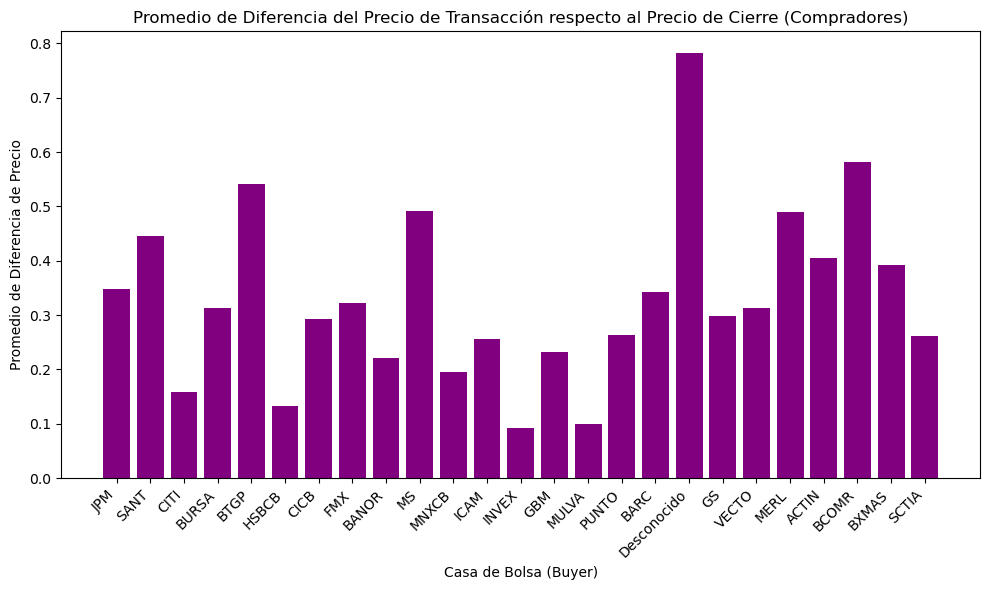

In [62]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import functions as F

# Calcular la diferencia de precio con el precio de cierre
df_a = df_a.withColumn('price_diff_from_closing', F.abs(F.col('price') - F.col('closing_price')))

# Agrupar por comprador y calcular la diferencia promedio respecto al precio de cierre
avg_price_diff_by_buyer = df_a.groupBy('buyer_name').agg(F.mean('price_diff_from_closing').alias('avg_price_diff_from_closing'))

# Convertir a Pandas para graficar
avg_price_diff_by_buyer_pd = avg_price_diff_by_buyer.toPandas()

# Reemplazar valores nulos en buyer_name con 'Desconocido'
avg_price_diff_by_buyer_pd['buyer_name'] = avg_price_diff_by_buyer_pd['buyer_name'].fillna('Desconocido')

# Graficar la diferencia promedio respecto al precio de cierre
plt.figure(figsize=(10, 6))
plt.bar(avg_price_diff_by_buyer_pd['buyer_name'], avg_price_diff_by_buyer_pd['avg_price_diff_from_closing'], color='purple')
plt.title('Promedio de Diferencia del Precio de Transacción respecto al Precio de Cierre (Compradores)')
plt.xlabel('Casa de Bolsa (Buyer)')
plt.ylabel('Promedio de Diferencia de Precio')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [63]:
df_a.printSchema()

root
 |-- trade_time: timestamp (nullable = true)
 |-- match_number: integer (nullable = true)
 |-- instrument_id: integer (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- volume: integer (nullable = true)
 |-- price: double (nullable = true)
 |-- amount: double (nullable = true)
 |-- buyer_id: integer (nullable = true)
 |-- buyer_name: string (nullable = false)
 |-- seller_id: integer (nullable = true)
 |-- seller_name: string (nullable = false)
 |-- operation_type: string (nullable = true)
 |-- concertation_type: string (nullable = true)
 |-- price_setter: integer (nullable = true)
 |-- lot: integer (nullable = true)
 |-- symbol: string (nullable = true)
 |-- last_day_close: double (nullable = true)
 |-- last_day_close_date: timestamp (nullable = true)
 |-- unitary_daily_variation: double (nullable = true)
 |-- percentage_daily_variation: double (nullable = true)
 |-- last_week_close: double (nullable = true)
 |-- last_week_close_date: timestamp (nullable = true)
 |

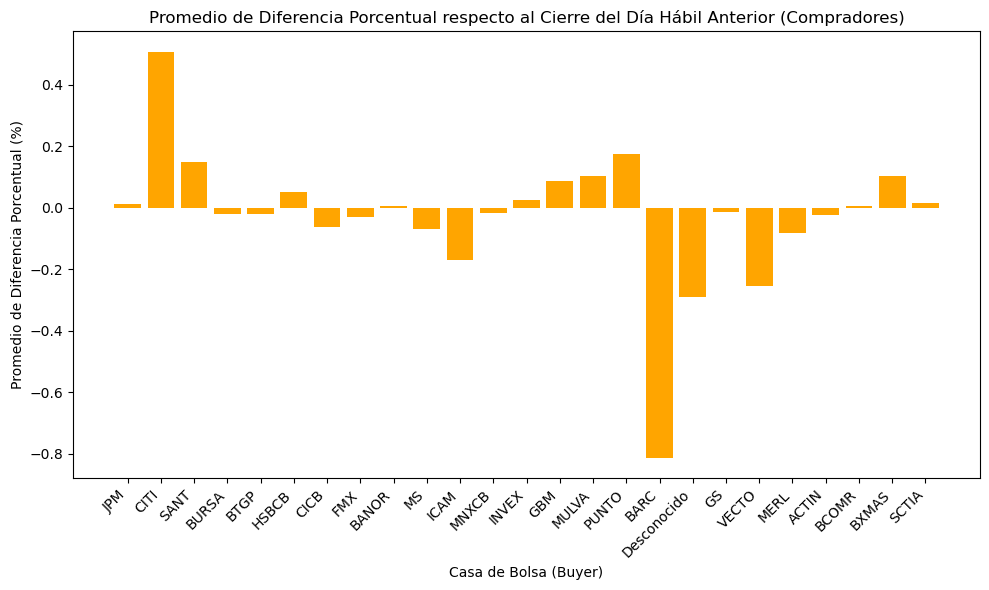

In [64]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import functions as F

# Calcular la diferencia porcentual respecto al cierre del día hábil anterior
df_a = df_a.withColumn(
    'percentage_diff_from_prev_close', 
    (F.col('price') - F.col('last_day_close')) / F.col('last_day_close') * 100
)

# Agrupar por comprador (buyer_name) y calcular la diferencia porcentual promedio
avg_percentage_diff_by_buyer = df_a.groupBy('buyer_name').agg(F.mean('percentage_diff_from_prev_close').alias('avg_percentage_diff_from_prev_close'))

# Convertir a Pandas para graficar
avg_percentage_diff_by_buyer_pd = avg_percentage_diff_by_buyer.toPandas()

# Reemplazar valores nulos en buyer_name con 'Desconocido'
avg_percentage_diff_by_buyer_pd['buyer_name'] = avg_percentage_diff_by_buyer_pd['buyer_name'].fillna('Desconocido')

# Graficar la diferencia porcentual promedio respecto al cierre del día hábil anterior
plt.figure(figsize=(10, 6))
plt.bar(avg_percentage_diff_by_buyer_pd['buyer_name'], avg_percentage_diff_by_buyer_pd['avg_percentage_diff_from_prev_close'], color='orange')
plt.title('Promedio de Diferencia Porcentual respecto al Cierre del Día Hábil Anterior (Compradores)')
plt.xlabel('Casa de Bolsa (Buyer)')
plt.ylabel('Promedio de Diferencia Porcentual (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [65]:
from pyspark.sql import Window
from pyspark.sql import functions as F

# Definir una ventana de partición por día, ordenada por el tiempo de transacción
day_window = Window.partitionBy('date').orderBy(F.desc('trade_time'))

# Obtener el precio de cierre del día actual (último precio del día)
df_a = df_a.withColumn('current_closing_price', F.first('price').over(day_window))

# Definir una ventana de partición para calcular el cierre del día anterior (lag de un día)
previous_day_window = Window.partitionBy('symbol').orderBy('date')

# Obtener el cierre del día anterior (cierre del día anterior)
df_a = df_a.withColumn('prev_closing_price', F.lag('current_closing_price', 1).over(previous_day_window))

# Calcular la variación porcentual respecto al cierre del día anterior
df_a = df_a.withColumn(
    'percentage_variation_prev_close', 
    F.when(F.col('prev_closing_price').isNotNull(),
           (F.col('current_closing_price') - F.col('prev_closing_price')) / F.col('prev_closing_price') * 100
          ).otherwise(None)
)

# Calcular la variación porcentual respecto al precio de cierre del día en curso
df_a = df_a.withColumn(
    'percentage_variation_current_close', 
    F.when(F.col('current_closing_price').isNotNull(),
           (F.col('price') - F.col('current_closing_price')) / F.col('current_closing_price') * 100
          ).otherwise(None)
)

# Mostrar algunas columnas relevantes
df_a.select('date', 'trade_time', 'price', 'prev_closing_price', 'current_closing_price', 'percentage_variation_prev_close', 'percentage_variation_current_close').show(2)

+----------+-------------------+-----+------------------+---------------------+-------------------------------+----------------------------------+
|      date|         trade_time|price|prev_closing_price|current_closing_price|percentage_variation_prev_close|percentage_variation_current_close|
+----------+-------------------+-----+------------------+---------------------+-------------------------------+----------------------------------+
|2024-06-24|2024-06-24 14:00:05|60.64|              NULL|                60.64|                           NULL|                               0.0|
|2024-06-24|2024-06-24 14:00:05|60.64|             60.64|                60.64|                            0.0|                               0.0|
+----------+-------------------+-----+------------------+---------------------+-------------------------------+----------------------------------+
only showing top 2 rows



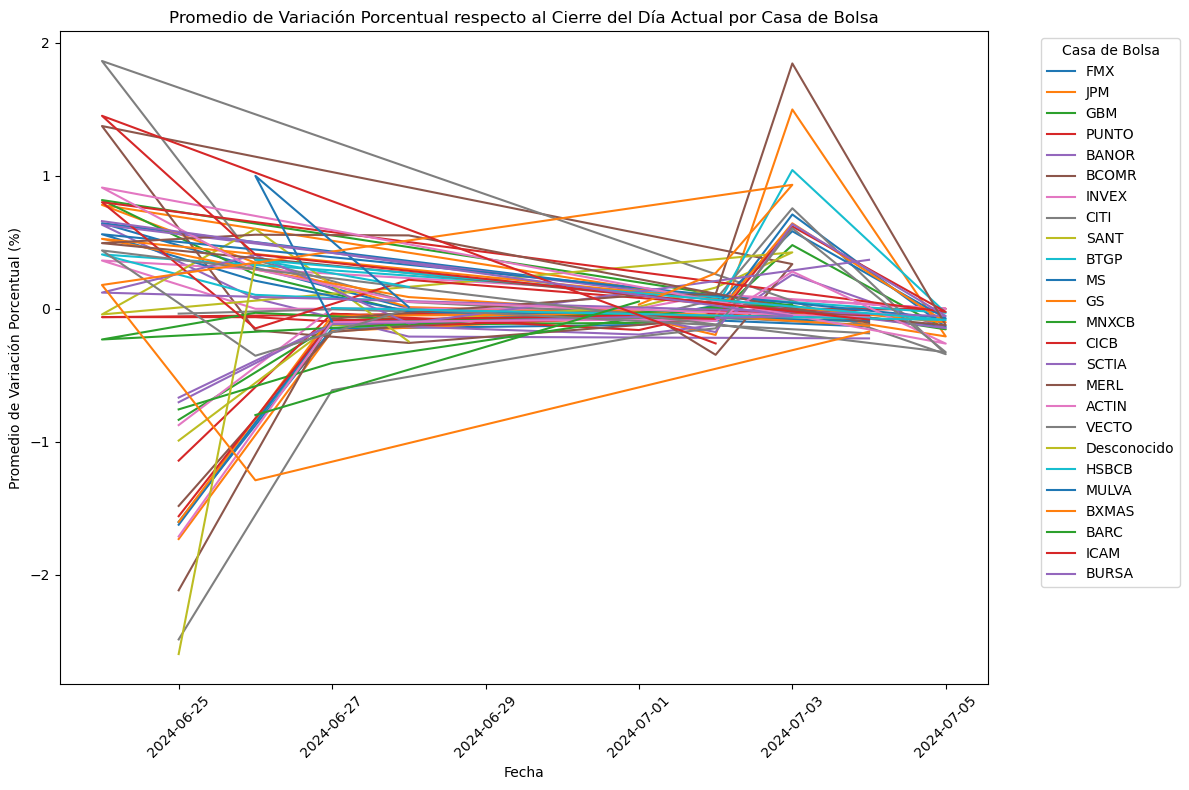

In [66]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import functions as F
from pyspark.sql import Window

# Definir una ventana de partición por día, ordenada por el tiempo de transacción
day_window = Window.partitionBy('date').orderBy(F.desc('trade_time'))

# Obtener el precio de cierre del día actual (último precio del día)
df_a = df_a.withColumn('current_closing_price', F.first('price').over(day_window))

# Calcular la variación porcentual respecto al precio de cierre del día en curso
df_a = df_a.withColumn(
    'percentage_variation_current_close', 
    F.when(F.col('current_closing_price').isNotNull(),
           (F.col('price') - F.col('current_closing_price')) / F.col('current_closing_price') * 100
          ).otherwise(None)
)

# Agrupar por casa de bolsa (buyer_name) y fecha, calcular el promedio de la diferencia porcentual
avg_percentage_diff_by_buyer = df_a.groupBy('buyer_name', 'date').agg(
    F.mean('percentage_variation_current_close').alias('avg_percentage_diff')
)

# Convertir a Pandas para graficar
avg_percentage_diff_by_buyer_pd = avg_percentage_diff_by_buyer.toPandas()

# Reemplazar valores nulos en buyer_name con 'Desconocido'
avg_percentage_diff_by_buyer_pd['buyer_name'] = avg_percentage_diff_by_buyer_pd['buyer_name'].fillna('Desconocido')

# Graficar la variación porcentual promedio para cada casa de bolsa en todas las fechas
plt.figure(figsize=(12, 8))

# Crear un gráfico de líneas, uno por cada comprador
for buyer in avg_percentage_diff_by_buyer_pd['buyer_name'].unique():
    buyer_data = avg_percentage_diff_by_buyer_pd[avg_percentage_diff_by_buyer_pd['buyer_name'] == buyer]
    plt.plot(buyer_data['date'], buyer_data['avg_percentage_diff'], label=buyer)

plt.title('Promedio de Variación Porcentual respecto al Cierre del Día Actual por Casa de Bolsa')
plt.xlabel('Fecha')
plt.ylabel('Promedio de Variación Porcentual (%)')
plt.xticks(rotation=45)
plt.legend(title='Casa de Bolsa', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

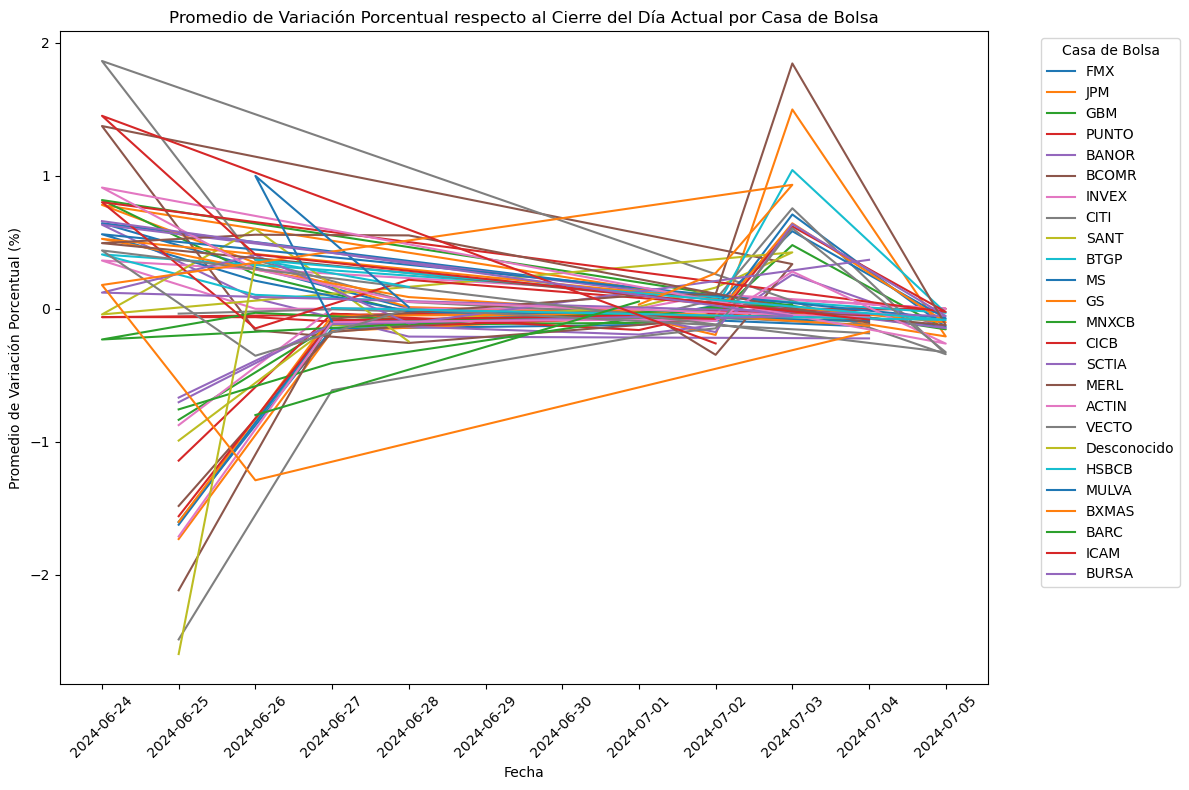

In [67]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
from pyspark.sql import functions as F
from pyspark.sql import Window

# Crear ventana de partición para obtener el precio de cierre diario
day_window = Window.partitionBy('date').orderBy(F.desc('trade_time'))
df_a = df_a.withColumn('current_closing_price', F.first('price').over(day_window))

# Calcular la variación porcentual respecto al precio de cierre del día
df_a = df_a.withColumn(
    'percentage_variation_current_close', 
    (F.col('price') - F.col('current_closing_price')) / F.col('current_closing_price') * 100
)

# Agrupar por comprador y fecha
avg_percentage_diff_by_buyer = df_a.groupBy('buyer_name', 'date').agg(
    F.mean('percentage_variation_current_close').alias('avg_percentage_diff')
)

# Convertir a Pandas y ajustar datos
avg_percentage_diff_by_buyer_pd = avg_percentage_diff_by_buyer.toPandas()
avg_percentage_diff_by_buyer_pd['buyer_name'] = avg_percentage_diff_by_buyer_pd['buyer_name'].fillna('Desconocido')

# Graficar
plt.figure(figsize=(12, 8))

# Gráfico de líneas para cada comprador
for buyer in avg_percentage_diff_by_buyer_pd['buyer_name'].unique():
    buyer_data = avg_percentage_diff_by_buyer_pd[avg_percentage_diff_by_buyer_pd['buyer_name'] == buyer]
    plt.plot(buyer_data['date'], buyer_data['avg_percentage_diff'], label=buyer)

plt.title('Promedio de Variación Porcentual respecto al Cierre del Día Actual por Casa de Bolsa')
plt.xlabel('Fecha')
plt.ylabel('Promedio de Variación Porcentual (%)')
plt.xticks(rotation=45)

# Formato de fecha en el eje X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Mostrar solo fechas con datos
plt.legend(title='Casa de Bolsa', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [68]:
df_a.show(2)

+-------------------+------------+-------------+--------------------+------+-----+----------+--------+----------+---------+-----------+--------------+-----------------+------------+---+-------+--------------+-------------------+-----------------------+--------------------------+---------------+--------------------+------------------------+---------------------------+----------------+---------------------+-------------------------+----------------------------+----------+----+------+--------------+-------------+---------+------------+-------------+----------+---------------+-----------+-----------------------+-------------------------------+---------------------+------------------+-------------------------------+----------------------------------+
|         trade_time|match_number|instrument_id|           timestamp|volume|price|    amount|buyer_id|buyer_name|seller_id|seller_name|operation_type|concertation_type|price_setter|lot| symbol|last_day_close|last_day_close_date|unitary_daily_va

In [69]:
combined_df.show(2)

+-------------------+------------+-------------+--------------------+------+------+--------+--------+----------+---------+-----------+--------------+-----------------+------------+---+--------+
|         trade_time|match_number|instrument_id|           timestamp|volume| price|  amount|buyer_id|buyer_name|seller_id|seller_name|operation_type|concertation_type|price_setter|lot|  symbol|
+-------------------+------------+-------------+--------------------+------+------+--------+--------+----------+---------+-----------+--------------+-----------------+------------+---+--------+
|2024-06-24 13:01:01|       11488|            5|2024-06-24 13:01:...|   426| 60.73|25870.98|      54|      MERL|        0|         GS|             C|                O|           1|  1| WALMEX*|
|2024-06-24 13:08:20|        7702|            3|2024-06-24 13:08:...|     7|193.83| 1356.81|     141|      BTGP|        0|        FMX|             C|                O|           0|  0|FEMSAUBD|
+-------------------+---------

# Tarea 6

## Modelos de Machine Learning en PySpark usando el conjunto de datos de precios intradía de una emisora de BMV y otras emisoras

# Cambio de granularidad a un minuto, para efectos prácticos y/o factibles.

1. Preparación de Datos
Convertimos variables relevantes y llenamos valores faltantes.

In [70]:
from pyspark.sql import functions as F

# Obtener una lista de símbolos únicos en el DataFrame
unique_symbols = [row["symbol"] for row in combined_df.select("symbol").distinct().collect()]

# Crear un diccionario para almacenar DataFrames por símbolo
df_symbols = {}
# df_symbols_excluded = {'BIMBOA'}
df_symbols_excluded = {''}

# Iterar sobre cada símbolo y crear un DataFrame filtrado
for symbol in unique_symbols:
    if symbol not in df_symbols_excluded:
        df_symbols[symbol] = combined_df.filter(F.col("symbol") == symbol)
    
# Opcional: Mostrar los primeros registros de cada DataFrame para verificar
for symbol, df in df_symbols.items():
    print(f"Primeros registros para el símbolo {symbol}:")
    # Ordenar cronológicamente
    df.orderBy("trade_time").show(2)

Primeros registros para el símbolo SORIANAB:
+-------------------+------------+-------------+--------------------+------+-----+------+--------+----------+---------+-----------+--------------+-----------------+------------+---+--------+
|         trade_time|match_number|instrument_id|           timestamp|volume|price|amount|buyer_id|buyer_name|seller_id|seller_name|operation_type|concertation_type|price_setter|lot|  symbol|
+-------------------+------------+-------------+--------------------+------+-----+------+--------+----------+---------+-----------+--------------+-----------------+------------+---+--------+
|2024-06-24 07:30:00|          11|           80|2024-06-24 07:30:...|     1|29.34| 29.34|     119|     ACTIN|       14|        GBM|             C|                O|           0|  0|SORIANAB|
|2024-06-24 07:30:00|           1|           80|2024-06-24 07:30:...|     1|29.34| 29.34|      14|       GBM|       14|        GBM|             C|                C|           0|  0|SORIANAB|


In [71]:
from pyspark.sql import functions as F
from pyspark.sql import Window
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

# Crear un nuevo diccionario para almacenar los DataFrames procesados por símbolo
df_symbols_5min = {}

# Iterar sobre cada símbolo en el diccionario original `df_symbols`
for symbol, df_a in df_symbols.items():
    
    # Crear columna de tiempo a nivel de 5 minutos usando el inicio del intervalo
    df_5min = df_a.withColumn("datetime_5min", F.window("trade_time", "5 minutes").start)

    # Agrupar por intervalos de 5 minutos, obteniendo el último precio y volumen acumulado
    df_5min_summary = df_5min.groupBy("datetime_5min") \
        .agg(
            F.last("price").alias("close"),            # Precio de cierre (último registro del intervalo de 5 minutos)
            F.sum("volume").alias("volume")            # Volumen acumulado en el intervalo de 5 minutos
        )

    # Agregar columna de inicio y fin del intervalo de 5 minutos para mayor claridad
    df_5min_summary = df_5min_summary.withColumn("minute_start", F.col("datetime_5min")) \
                                     .withColumn("minute_end", F.expr("datetime_5min + interval 5 minute"))

    # Definir una ventana para desplazar (lag) los datos un intervalo hacia atrás
    window_spec = Window.orderBy("datetime_5min")

    # Agregar las columnas de "close" y "volume" desplazadas en un intervalo de 5 minutos hacia atrás
    df_5min_lagged = df_5min_summary.withColumn("lagged_close", F.lag("close", 1).over(window_spec)) \
                                    .withColumn("lagged_volume", F.lag("volume", 1).over(window_spec))

    # Filtrar las filas donde los valores desplazados (lagged) sean nulos
    df_5min_lagged = df_5min_lagged.filter(F.col("lagged_close").isNotNull())

    # Ordenar cronológicamente por el inicio del intervalo de 5 minutos
    df_5min_lagged = df_5min_lagged.orderBy("minute_start")
    
    # Almacenar el DataFrame procesado en el diccionario de resultados
    df_symbols_5min[symbol] = df_5min_lagged

# Ejemplo: mostrar los primeros registros para cada símbolo procesado
for symbol, df in df_symbols_5min.items():
    print(f"Primeros registros procesados para el símbolo {symbol}:")
    df.orderBy("minute_start").show(2)

Primeros registros procesados para el símbolo SORIANAB:
+-------------------+-----+------+-------------------+-------------------+------------+-------------+
|      datetime_5min|close|volume|       minute_start|         minute_end|lagged_close|lagged_volume|
+-------------------+-----+------+-------------------+-------------------+------------+-------------+
|2024-06-24 07:35:00| 29.7|    10|2024-06-24 07:35:00|2024-06-24 07:40:00|       29.34|           46|
|2024-06-24 08:05:00|30.09|     3|2024-06-24 08:05:00|2024-06-24 08:10:00|        29.7|           10|
+-------------------+-----+------+-------------------+-------------------+------------+-------------+
only showing top 2 rows

Primeros registros procesados para el símbolo BIMBOA:
+-------------------+-----+------+-------------------+-------------------+------------+-------------+
|      datetime_5min|close|volume|       minute_start|         minute_end|lagged_close|lagged_volume|
+-------------------+-----+------+---------------

In [72]:
from pyspark.sql import functions as F
from pyspark.sql import Window

# Crear un nuevo diccionario para almacenar los DataFrames agrupados a 5 minutos por símbolo
df_symbols_5min_ohlc = {}

# Iterar sobre cada símbolo en el diccionario original `df_symbols`
for symbol, df_a in df_symbols.items():
    
    # Crear columna de tiempo a nivel de 5 minutos usando el inicio del intervalo
    df_5min = df_a.withColumn("datetime_5min", F.window("trade_time", "5 minutes").start)

    # Agrupar por intervalos de 5 minutos y calcular los valores de OHLC y volumen
    df_5min_summary = df_5min.groupBy("datetime_5min") \
        .agg(
            F.first("price").alias("open"),          # Precio de apertura (primer registro del intervalo de 5 minutos)
            F.max("price").alias("high"),            # Precio más alto
            F.min("price").alias("low"),             # Precio más bajo
            F.last("price").alias("close"),          # Precio de cierre
            F.sum("volume").alias("volume")          # Volumen acumulado en el intervalo de 5 minutos
        )

    # Agregar columna de inicio y fin del intervalo de 5 minutos para mayor claridad
    df_5min_summary = df_5min_summary.withColumn("minute_start", F.col("datetime_5min")) \
                                     .withColumn("minute_end", F.expr("datetime_5min + interval 5 minute"))
    

    # Almacenar el DataFrame procesado en el diccionario de resultados
    df_symbols_5min_ohlc[symbol] = df_5min_summary

# Ejemplo: mostrar los primeros registros para cada símbolo procesado en la agregación OHLC
for symbol, df in df_symbols_5min.items():
    print(f"Primeros registros para el símbolo {symbol} (OHLC):")
    df.orderBy("datetime_5min").show(2)

Primeros registros para el símbolo SORIANAB (OHLC):
+-------------------+-----+------+-------------------+-------------------+------------+-------------+
|      datetime_5min|close|volume|       minute_start|         minute_end|lagged_close|lagged_volume|
+-------------------+-----+------+-------------------+-------------------+------------+-------------+
|2024-06-24 07:35:00| 29.7|    10|2024-06-24 07:35:00|2024-06-24 07:40:00|       29.34|           46|
|2024-06-24 08:05:00|30.09|     3|2024-06-24 08:05:00|2024-06-24 08:10:00|        29.7|           10|
+-------------------+-----+------+-------------------+-------------------+------------+-------------+
only showing top 2 rows

Primeros registros para el símbolo BIMBOA (OHLC):
+-------------------+-----+------+-------------------+-------------------+------------+-------------+
|      datetime_5min|close|volume|       minute_start|         minute_end|lagged_close|lagged_volume|
+-------------------+-----+------+-------------------+---

In [73]:
# Crear un nuevo diccionario para almacenar los DataFrames con lagging por símbolo
df_symbols_5min_ohlc_lagged = {}

# Iterar sobre cada símbolo en el diccionario de DataFrames `df_symbols_5min`
for symbol, df_5min_ohlc_summary in df_symbols_5min_ohlc.items():
    
    # Definir una ventana para desplazar (lag) los datos un intervalo hacia atrás
    window_spec = Window.orderBy("datetime_5min")

    # Agregar las columnas de "close" y "volume" desplazadas en un intervalo de 5 minutos hacia atrás
    df_5min_ohlc_lagged = df_5min_ohlc_summary.withColumn("lagged_close", F.lag("close", 1).over(window_spec)) \
                                              .withColumn("lagged_volume", F.lag("volume", 1).over(window_spec))

    # Filtrar las filas donde los valores desplazados (lagged) sean nulos
    df_5min_ohlc_lagged = df_5min_ohlc_lagged.filter(F.col("lagged_close").isNotNull())

    # Ordenar cronológicamente por el inicio del intervalo de 5 minutos y almacenar el DataFrame
    df_symbols_5min_ohlc_lagged[symbol] = df_5min_ohlc_lagged.orderBy("datetime_5min")

# Ejemplo: mostrar los primeros registros para cada símbolo procesado con lagging
for symbol, df in df_symbols_5min_ohlc_lagged.items():
    print(f"Primeros registros procesados para el símbolo {symbol} con lag:")
    df.orderBy("datetime_5min").show(2)


Primeros registros procesados para el símbolo SORIANAB con lag:
+-------------------+-----+-----+-----+-----+------+-------------------+-------------------+------------+-------------+
|      datetime_5min| open| high|  low|close|volume|       minute_start|         minute_end|lagged_close|lagged_volume|
+-------------------+-----+-----+-----+-----+------+-------------------+-------------------+------------+-------------+
|2024-06-24 07:35:00|30.34|30.34| 29.7| 29.7|    10|2024-06-24 07:35:00|2024-06-24 07:40:00|       29.34|           46|
|2024-06-24 08:05:00|30.09|30.09|30.09|30.09|     3|2024-06-24 08:05:00|2024-06-24 08:10:00|        29.7|           10|
+-------------------+-----+-----+-----+-----+------+-------------------+-------------------+------------+-------------+
only showing top 2 rows

Primeros registros procesados para el símbolo BIMBOA con lag:
+-------------------+-----+-----+-----+-----+------+-------------------+-------------------+------------+-------------+
|      da

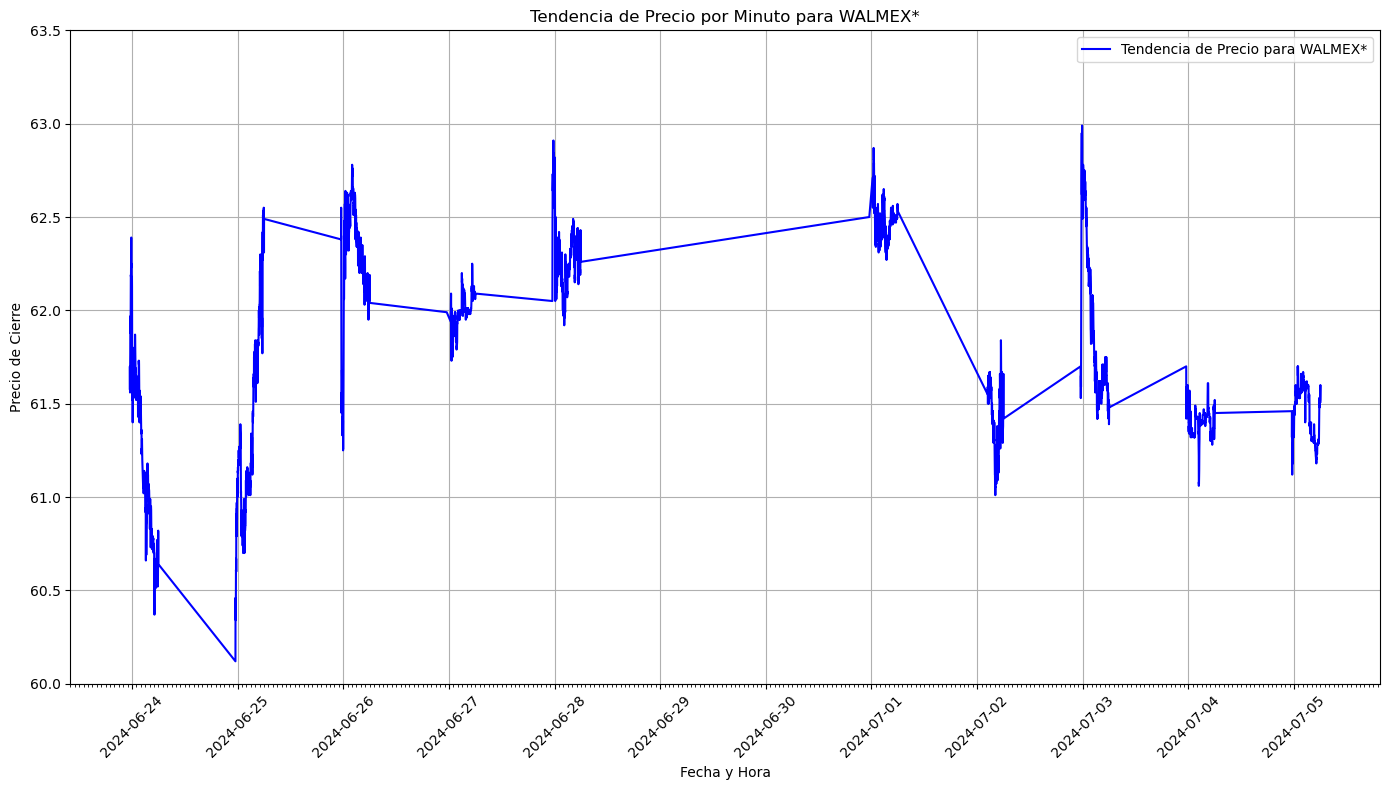

In [74]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import functions as F

# Filtrar el DataFrame solo para el símbolo "WALMEX*"
df_walmex = df_symbols["WALMEX*"]

# Crear columna de tiempo a nivel de minuto usando el inicio del intervalo
df_minute = df_walmex.withColumn("datetime_minute", F.window("trade_time", "1 minute").start)

# Agrupar por minuto y obtener el último precio (close) en cada minuto
df_minute_close = df_minute.groupBy("datetime_minute") \
    .agg(
        F.last("price").alias("close")         # Precio de cierre del minuto
    ).orderBy("datetime_minute")

# Convertir el DataFrame de Spark a Pandas
pandas_df = df_minute_close.toPandas()

# Asegurar que la columna de tiempo está en formato datetime y ordenada
pandas_df["datetime_minute"] = pd.to_datetime(pandas_df["datetime_minute"])
pandas_df = pandas_df.sort_values("datetime_minute")

# Graficar la tendencia del precio de cierre para "WALMEX*"
plt.figure(figsize=(14, 8))
plt.plot(pandas_df["datetime_minute"], pandas_df["close"], label="Tendencia de Precio para WALMEX*", color="blue")

# Configurar el formato del eje X para mostrar solo el día y la hora en intervalos de n horas
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%Y-%m-%d"))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.HourLocator(interval=24))  # Etiqueta cada n horas
plt.gca().xaxis.set_minor_locator(plt.matplotlib.dates.HourLocator(interval=1))  # Divisiones menores cada hora
plt.xticks(rotation=45)

# Configuración del eje Y
plt.ylim(60, 63.5)  # Escala del eje Y

# Etiquetas y título
plt.xlabel("Fecha y Hora")
plt.ylabel("Precio de Cierre")
plt.title("Tendencia de Precio por Minuto para WALMEX*")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


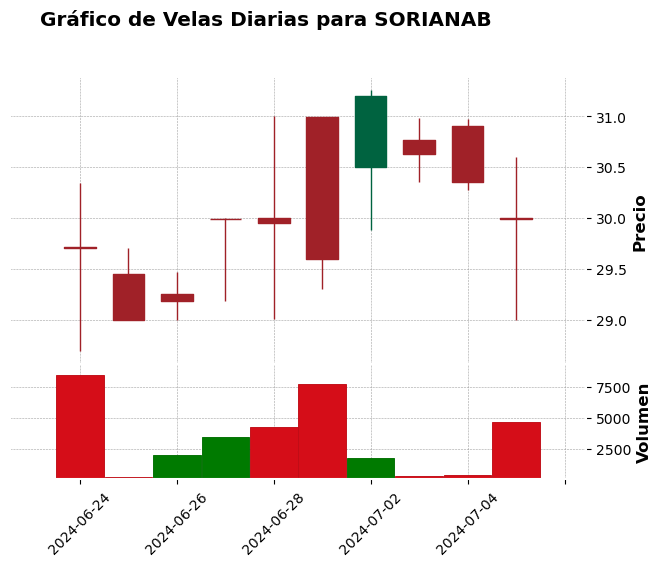

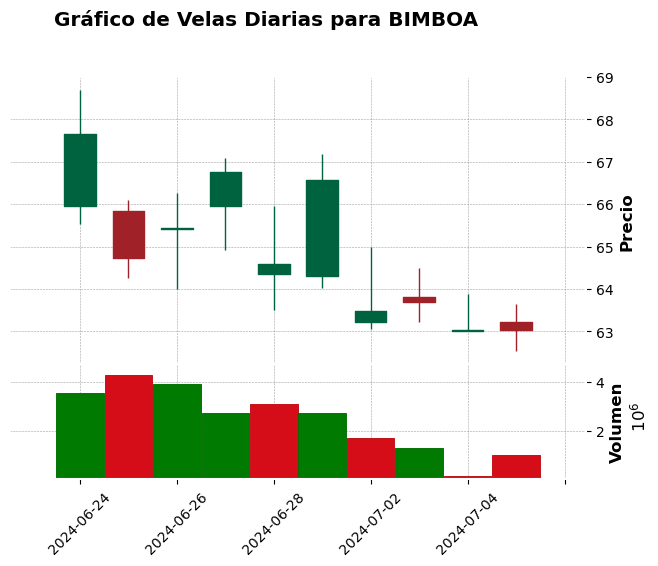

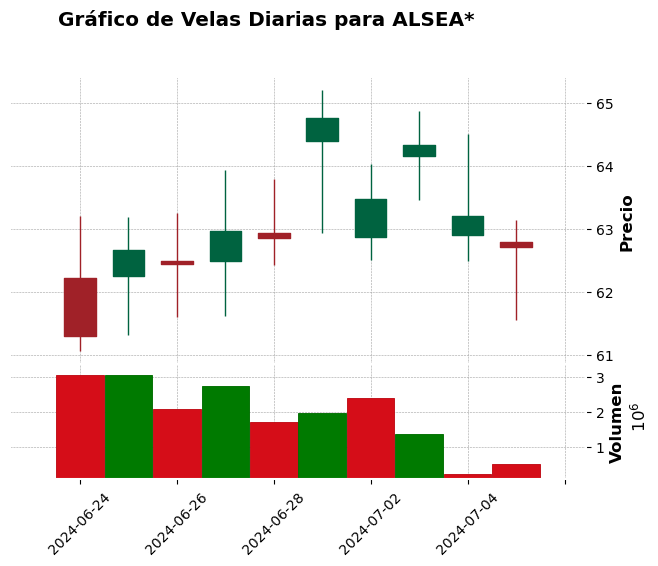

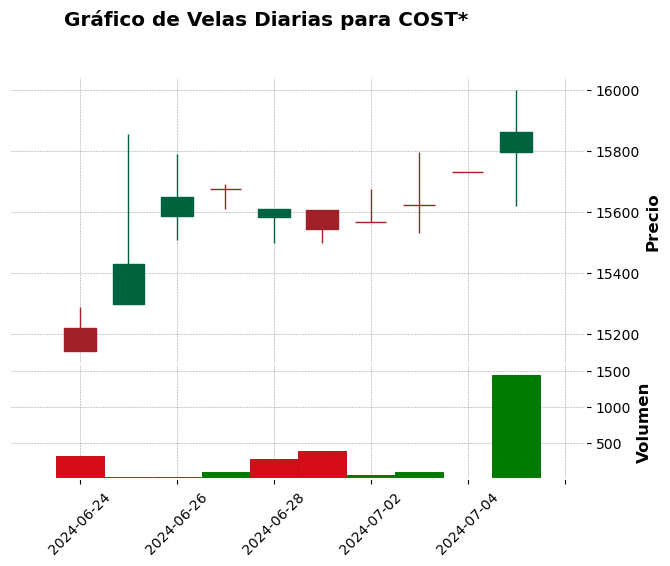

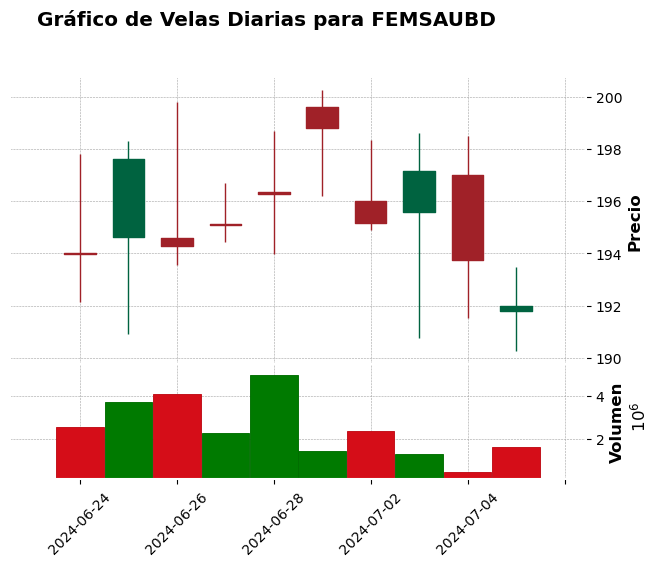

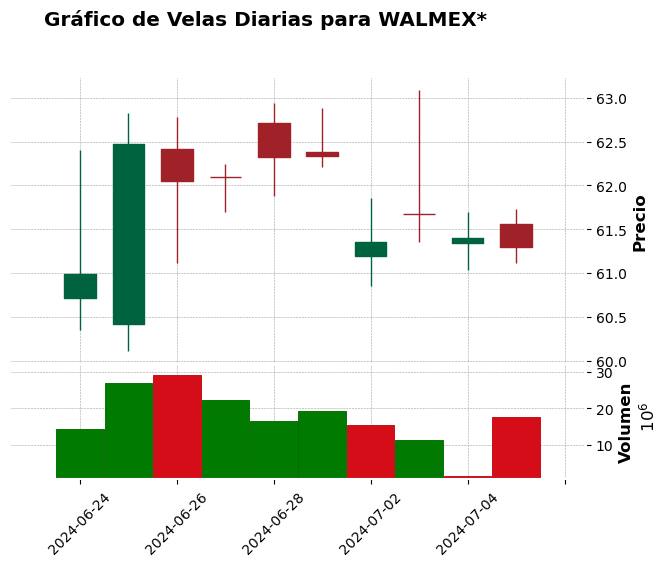

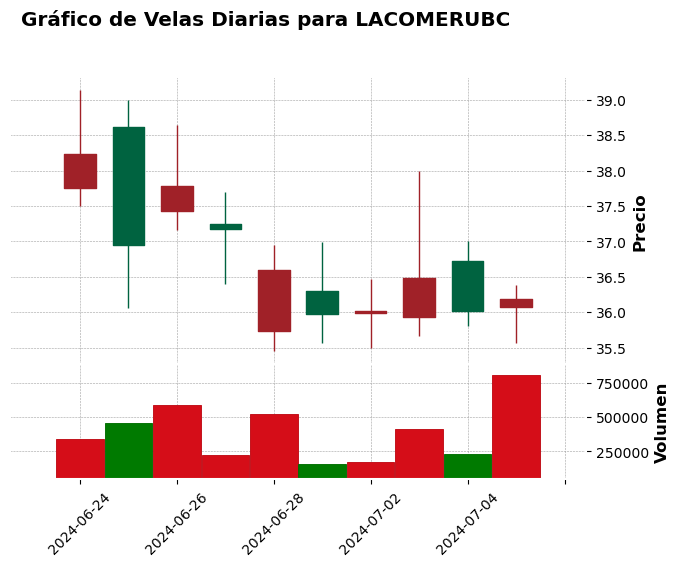

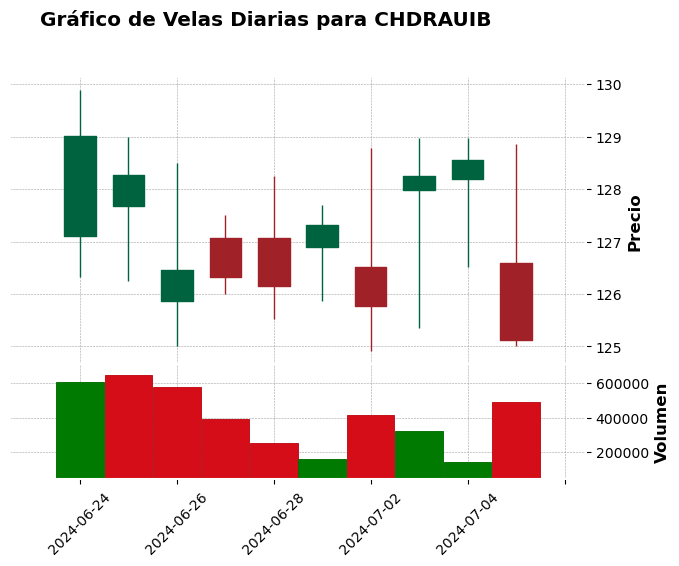

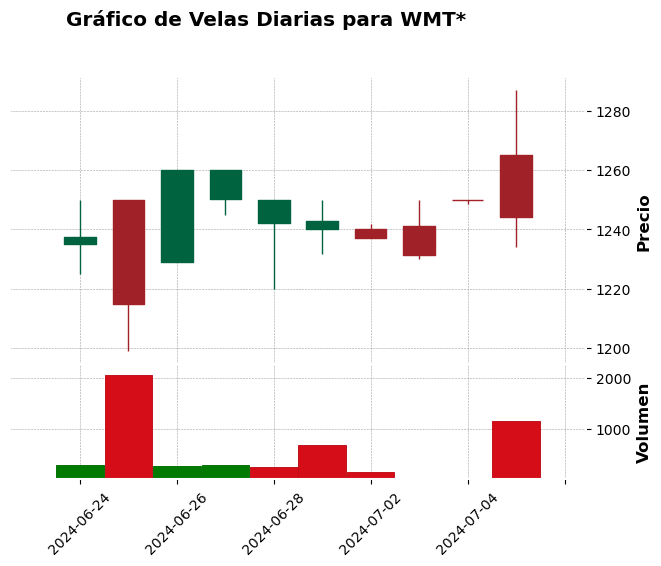

In [75]:
from pyspark.sql import functions as F
from pyspark.sql import Window
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf

# Crear un nuevo diccionario para almacenar los DataFrames agrupados por día por símbolo
df_symbols_daily_ohlc = {}

# Iterar sobre cada símbolo en el diccionario original `df_symbols`
for symbol, df_a in df_symbols.items():
    
    # Crear columna de tiempo a nivel de día usando el inicio del intervalo
    df_daily = df_a.withColumn("datetime_day", F.to_date("trade_time"))

    # Agrupar por día y calcular los valores de OHLC y volumen
    df_daily_summary = df_daily.groupBy("datetime_day") \
        .agg(
            F.first("price").alias("open"),         # Precio de apertura (primer registro del día)
            F.max("price").alias("high"),           # Precio más alto del día
            F.min("price").alias("low"),            # Precio más bajo del día
            F.last("price").alias("close"),         # Precio de cierre del día
            F.sum("volume").alias("volume")         # Volumen acumulado del día
        ).orderBy("datetime_day")

    # Almacenar el DataFrame procesado en el diccionario de resultados
    df_symbols_daily_ohlc[symbol] = df_daily_summary

# Generar gráficos de velas para cada símbolo
for symbol, df in df_symbols_daily_ohlc.items():
    # Convertir el DataFrame de Spark a Pandas
    pandas_df = df.toPandas()

    # Convertir la columna de fecha a formato datetime para mplfinance
    pandas_df["datetime_day"] = pd.to_datetime(pandas_df["datetime_day"])
    pandas_df.set_index("datetime_day", inplace=True)

    # Graficar con mplfinance
    mpf.plot(
        pandas_df,
        type='candle',
        style='charles',
        title=f"Gráfico de Velas Diarias para {symbol}",
        ylabel='Precio',
        volume=True,
        ylabel_lower='Volumen',
        datetime_format='%Y-%m-%d'
    )


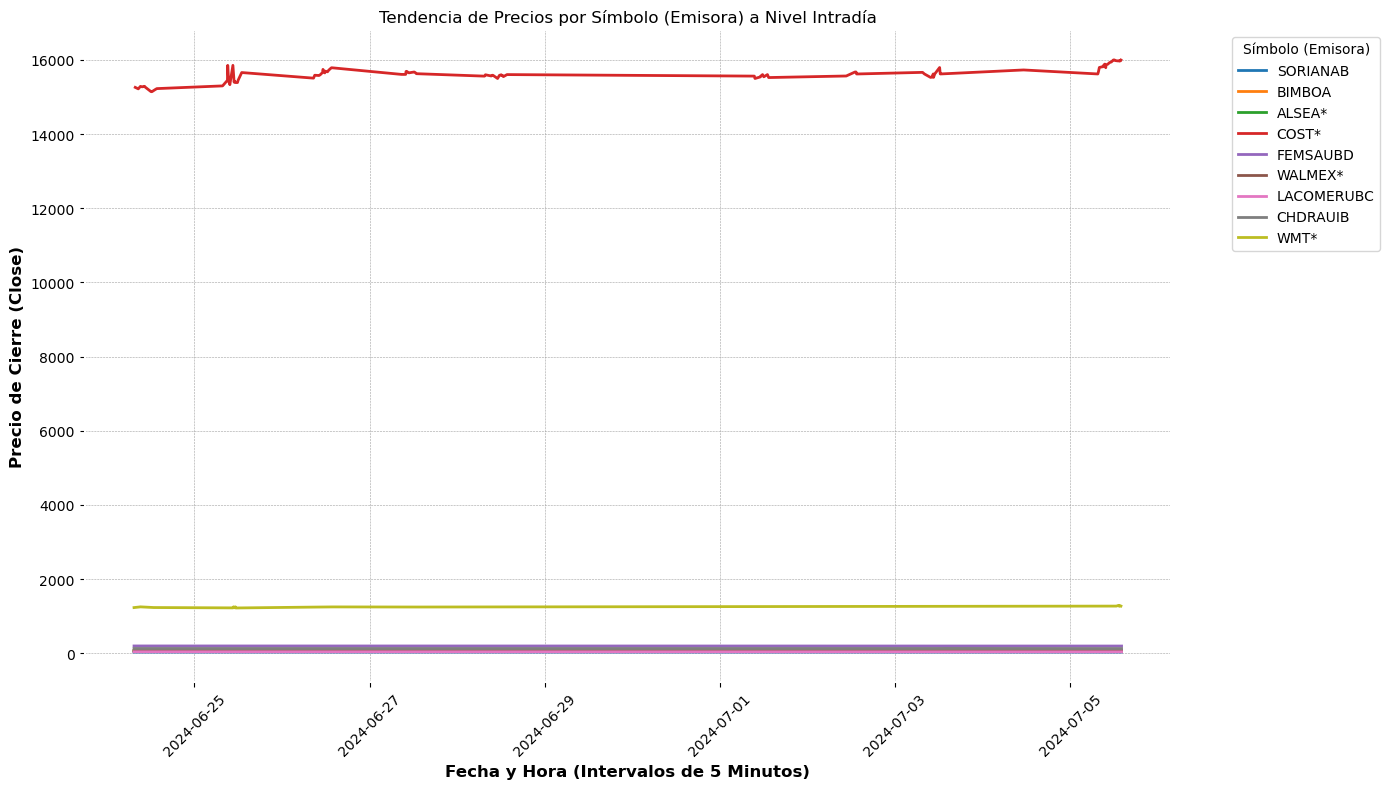

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))

# Convertir cada DataFrame de PySpark a Pandas y graficar la tendencia de precios
for symbol, df in df_symbols_5min_ohlc.items():
    # Convertir el DataFrame de PySpark a Pandas
    pandas_df = df.select("datetime_5min", "close").orderBy("datetime_5min").toPandas()
    
    # Graficar la tendencia de precios usando lineplot
    sns.lineplot(data=pandas_df, x="datetime_5min", y="close", label=symbol)

# Configuración de la gráfica
plt.title("Tendencia de Precios por Símbolo (Emisora) a Nivel Intradía")
plt.xlabel("Fecha y Hora (Intervalos de 5 Minutos)")
plt.ylabel("Precio de Cierre (Close)")
plt.legend(title="Símbolo (Emisora)", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar la gráfica
plt.show()


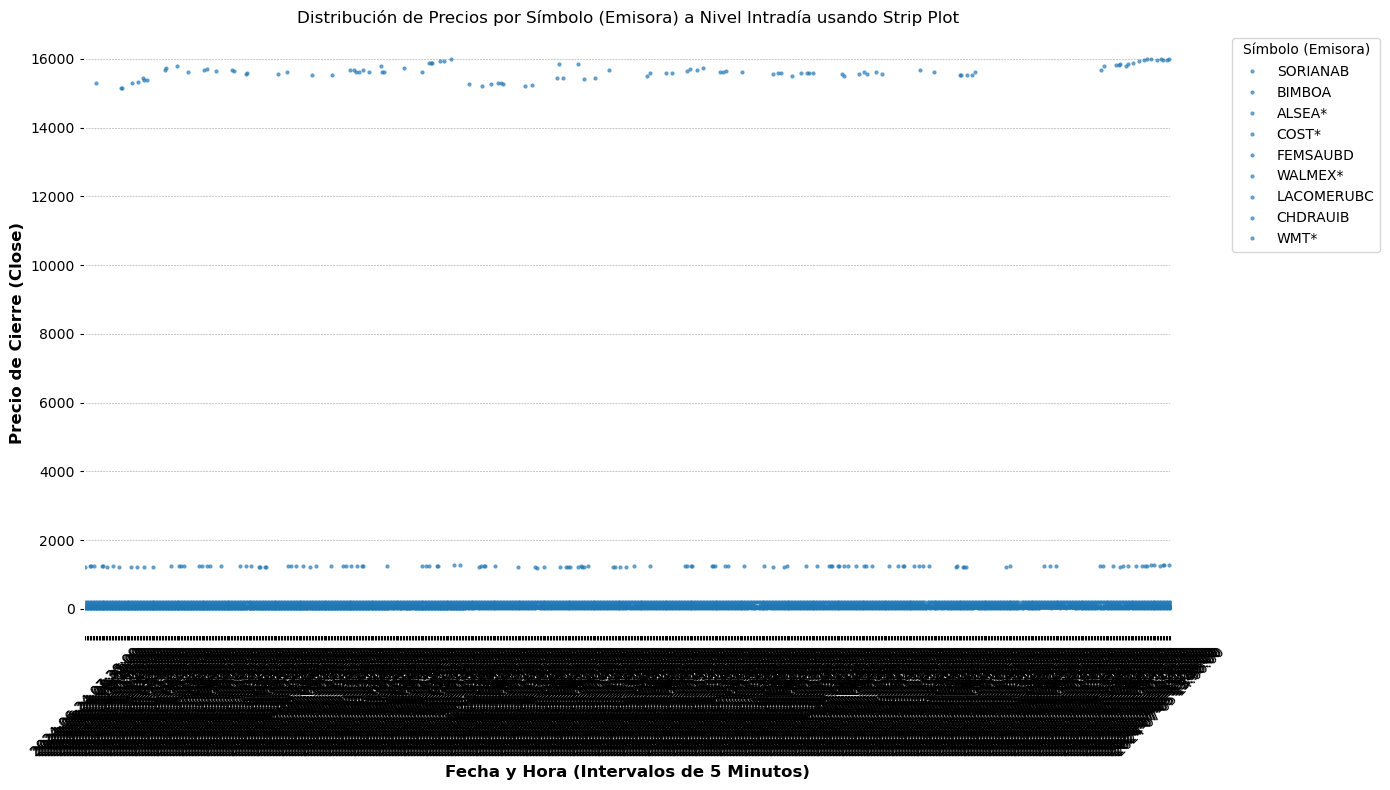

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura grande para acomodar las gráficas de todos los símbolos
plt.figure(figsize=(14, 8))

# Convertir cada DataFrame de PySpark a Pandas y graficar la tendencia de precios
for symbol, df in df_symbols_5min_ohlc.items():
    # Convertir el DataFrame de PySpark a Pandas
    pandas_df = df.select("datetime_5min", "close").orderBy("datetime_5min").toPandas()
    pandas_df['symbol'] = symbol  # Agregar el símbolo como columna para etiquetarlo en el gráfico
    
    # Usar sns.stripplot para visualizar la distribución de precios por símbolo a lo largo del tiempo
    sns.stripplot(data=pandas_df, x="datetime_5min", y="close", hue="symbol", jitter=0.3, dodge=True, size=3, alpha=0.7)

# Configuración de la gráfica
plt.title("Distribución de Precios por Símbolo (Emisora) a Nivel Intradía usando Strip Plot")
plt.xlabel("Fecha y Hora (Intervalos de 5 Minutos)")
plt.ylabel("Precio de Cierre (Close)")
plt.legend(title="Símbolo (Emisora)", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar la gráfica
plt.show()


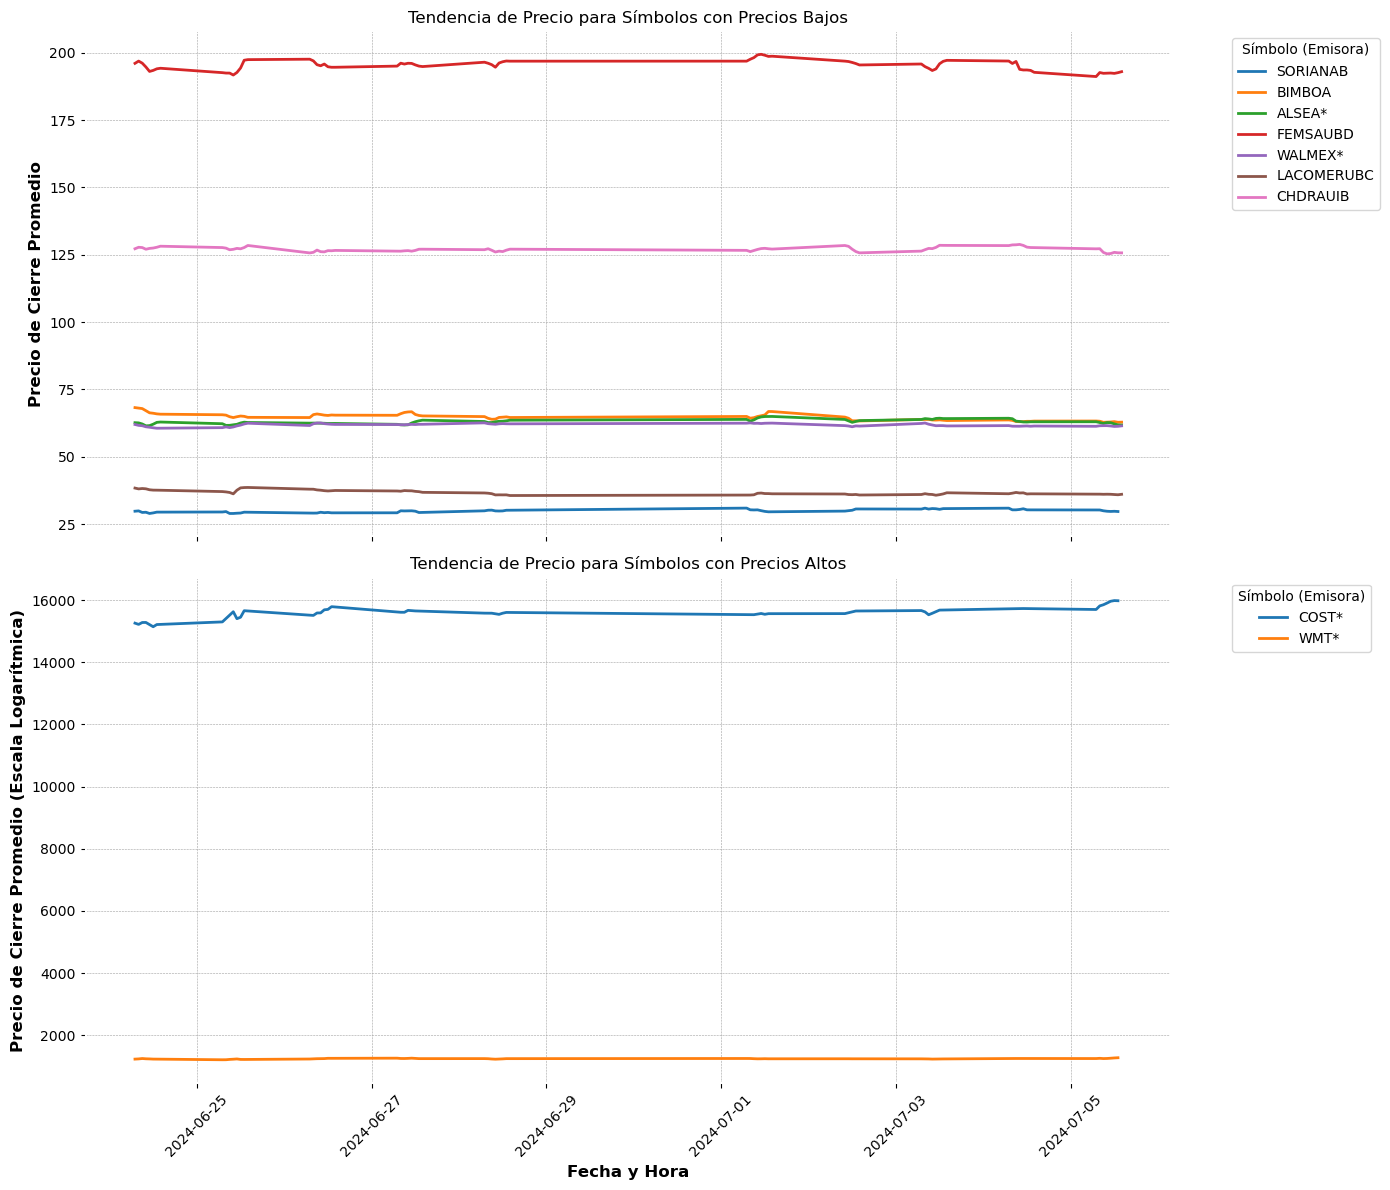

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import functions as F

# Definir límites para separar símbolos de precios altos y bajos
high_price_threshold = 500  # Ajusta este umbral según sea necesario

# Convertir cada DataFrame de PySpark a Pandas, reducir datos y agrupar por precio
high_price_symbols = []
low_price_symbols = []

for symbol, df in df_symbols_5min_ohlc.items():
    # Agrupar los datos en intervalos de 1 hora para reducir puntos
    df_hourly = df.groupBy(F.window("datetime_5min", "1 hour").alias("hour_window")) \
                  .agg(F.mean("close").alias("average_close")) \
                  .select(F.col("hour_window.start").alias("datetime"), "average_close") \
                  .orderBy("datetime")
    
    # Convertir a Pandas para graficar
    pandas_df = df_hourly.toPandas()
    pandas_df['symbol'] = symbol  # Agregar el símbolo para referencia
    
    # Clasificar símbolos de acuerdo al precio promedio para graficar en diferentes subplots
    if pandas_df['average_close'].mean() > high_price_threshold:
        high_price_symbols.append(pandas_df)
    else:
        low_price_symbols.append(pandas_df)

# Configurar las gráficas con subplots para símbolos de precios bajos y altos
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

# Gráfica para símbolos de precios bajos
for df in low_price_symbols:
    sns.lineplot(data=df, x="datetime", y="average_close", ax=ax1, label=df['symbol'].iloc[0])

ax1.set_title("Tendencia de Precio para Símbolos con Precios Bajos")
ax1.set_ylabel("Precio de Cierre Promedio")
ax1.legend(title="Símbolo (Emisora)", bbox_to_anchor=(1.05, 1), loc='upper left')

# Gráfica para símbolos de precios altos (escala logarítmica)
for df in high_price_symbols:
    sns.lineplot(data=df, x="datetime", y="average_close", ax=ax2, label=df['symbol'].iloc[0])

ax2.set_title("Tendencia de Precio para Símbolos con Precios Altos")
# ax2.set_yscale("log")  # Escala logarítmica para precios altos
ax2.set_ylabel("Precio de Cierre Promedio (Escala Logarítmica)")
ax2.legend(title="Símbolo (Emisora)", bbox_to_anchor=(1.05, 1), loc='upper left')

# Configuración final
plt.xlabel("Fecha y Hora")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


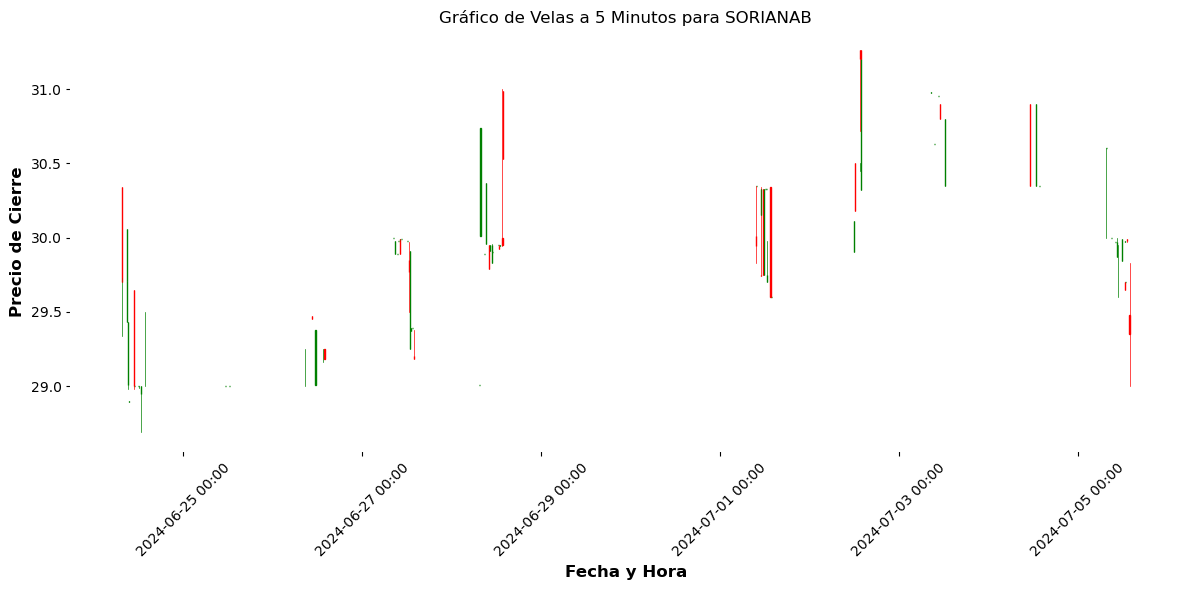

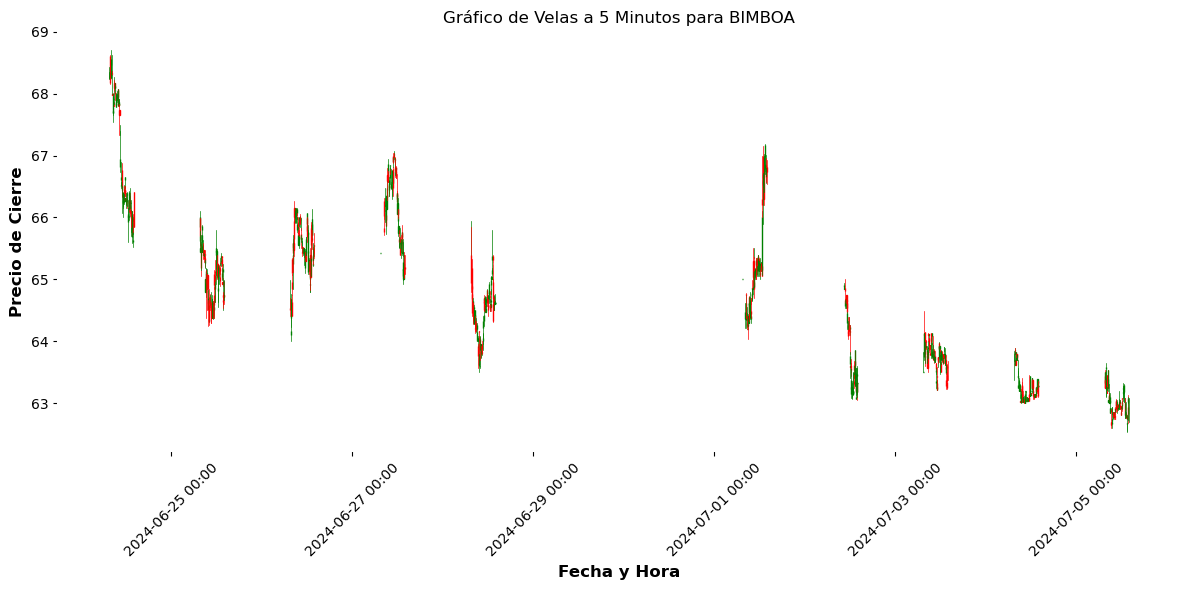

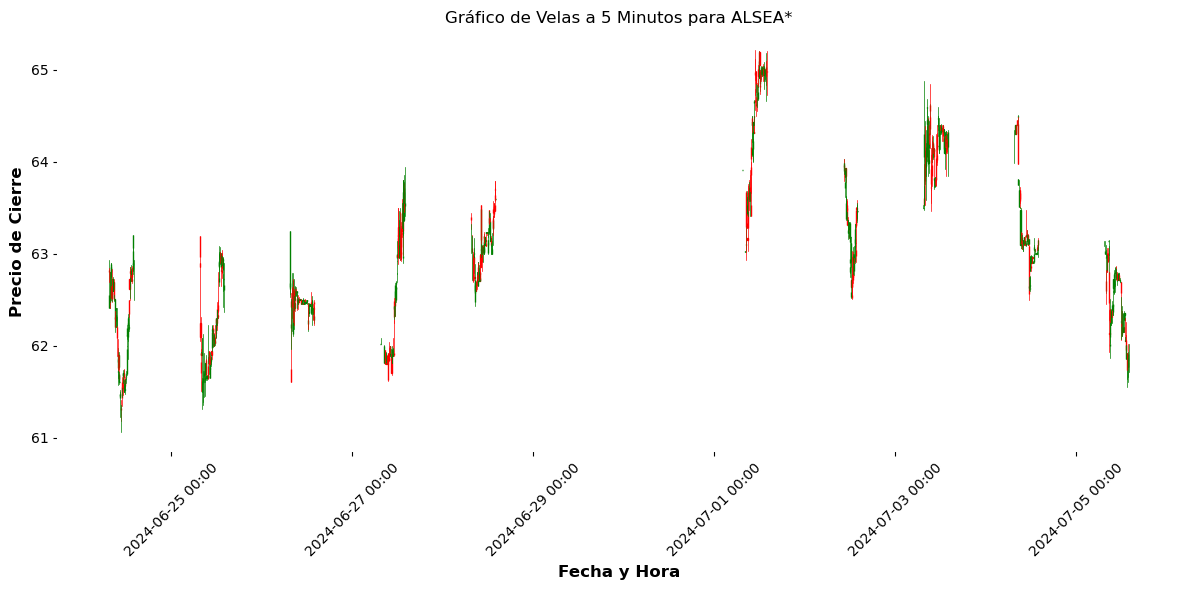

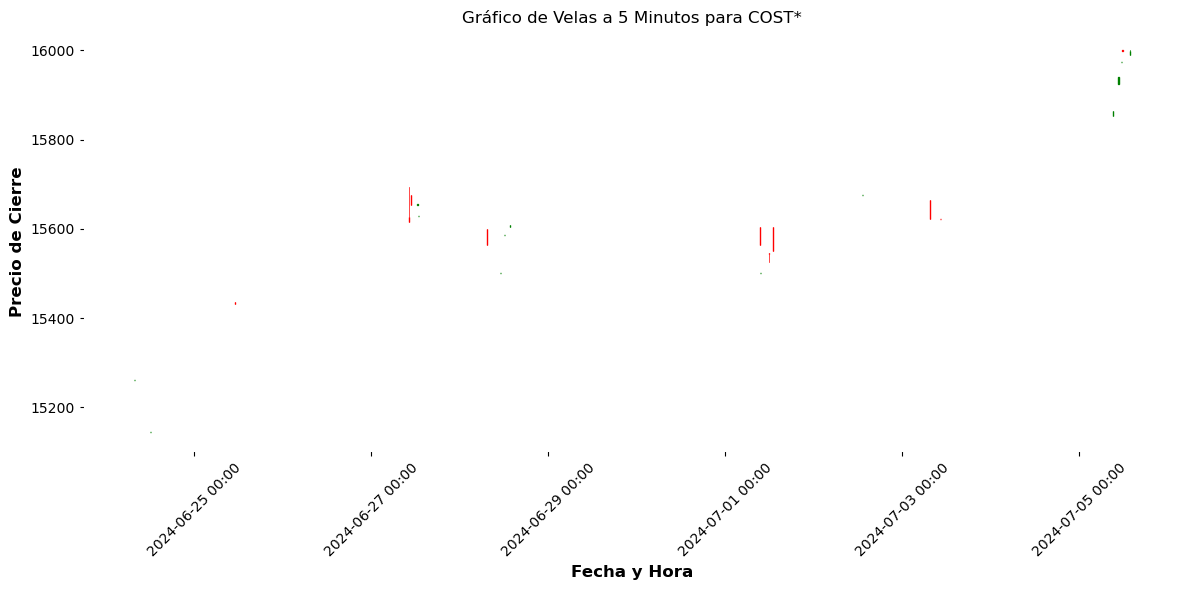

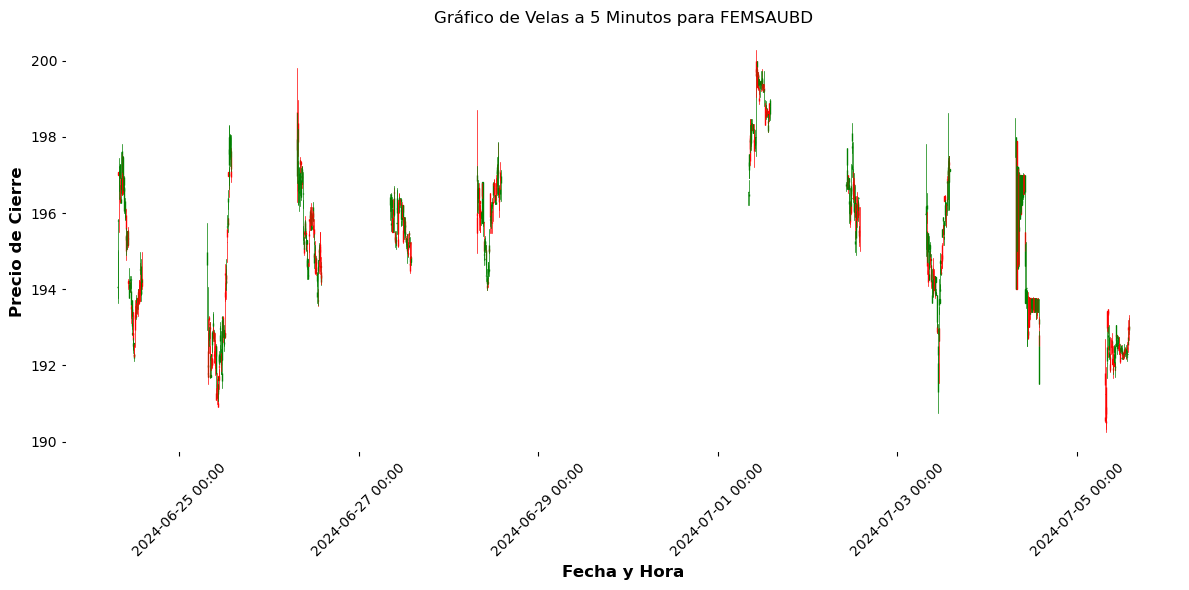

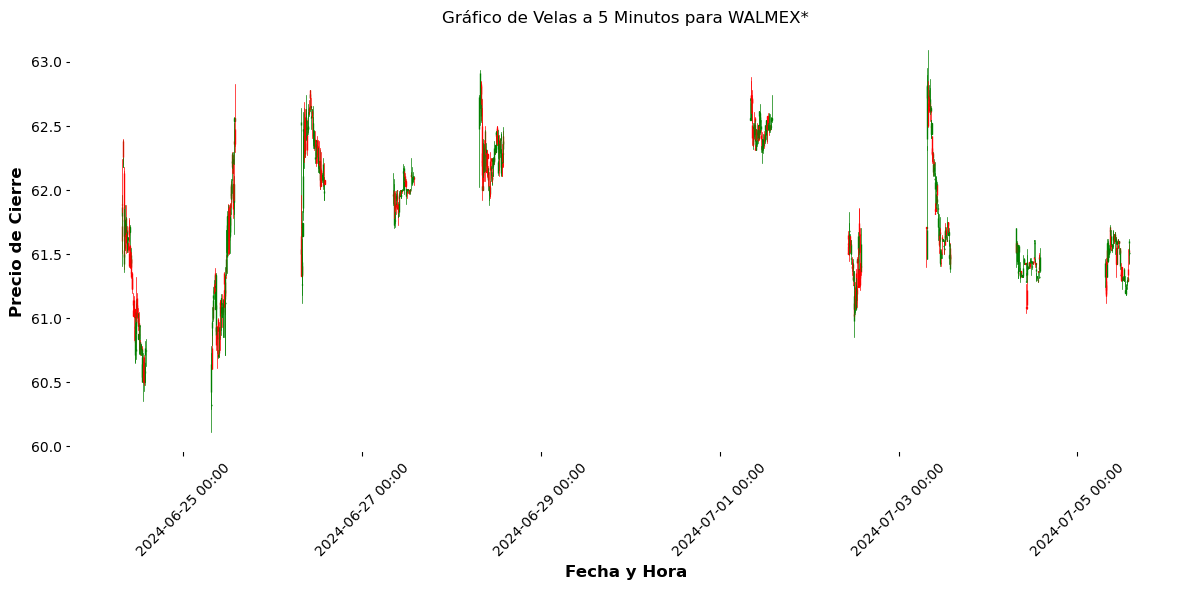

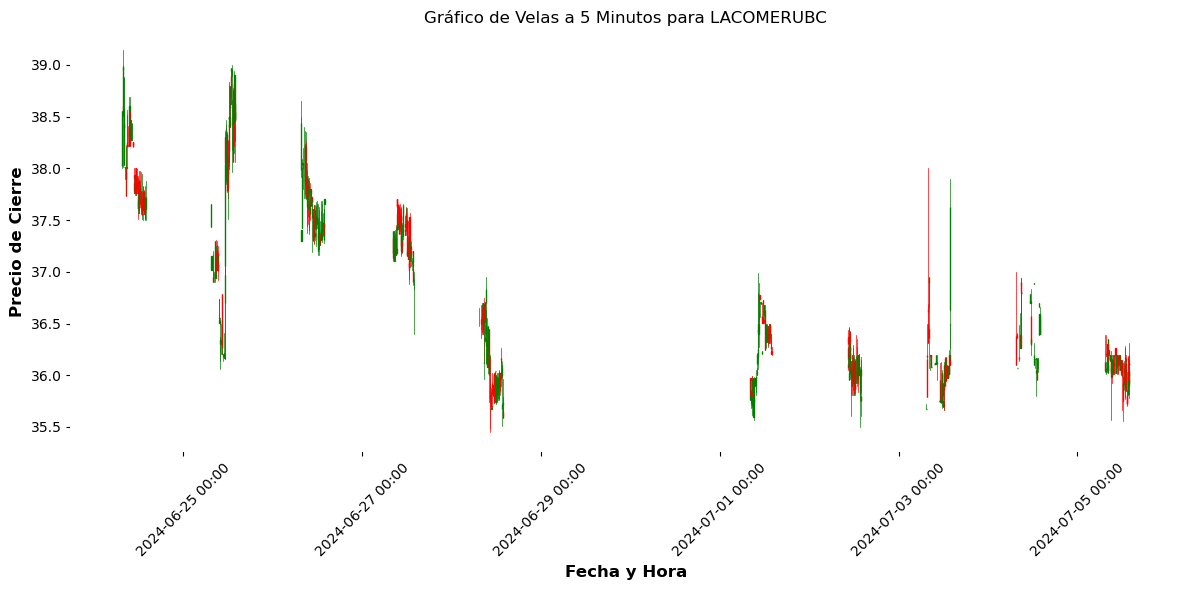

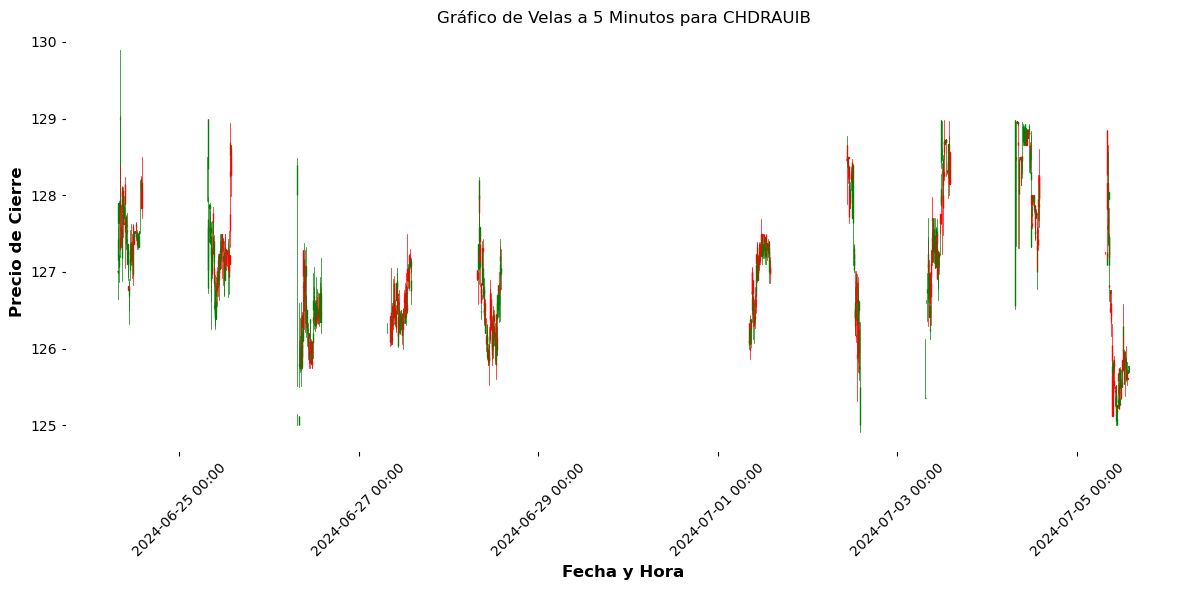

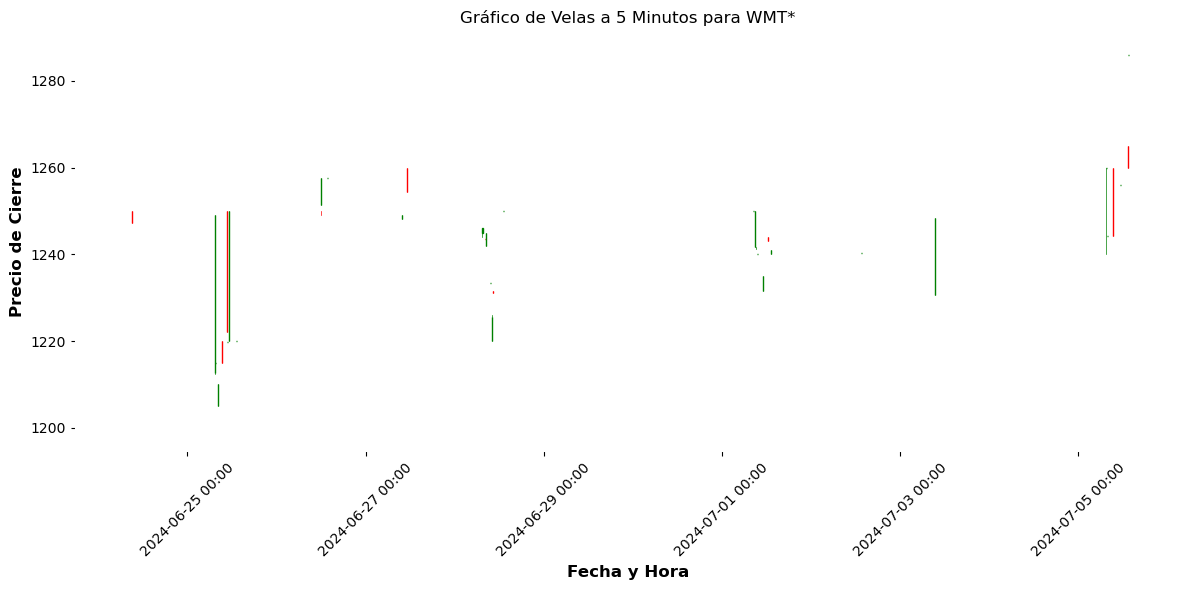

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates

# Iterar sobre cada símbolo en el diccionario df_symbols_5min
for symbol, df in df_symbols_5min_ohlc.items():
    # Convertir el DataFrame de Spark a Pandas
    pandas_df = df.select("datetime_5min", "open", "high", "low", "close", "volume").orderBy("datetime_5min").toPandas()

    # Convertir la columna de fecha y hora a formato numérico para la gráfica de velas
    pandas_df["datetime_5min"] = pd.to_datetime(pandas_df["datetime_5min"])
    pandas_df["datetime_num"] = pandas_df["datetime_5min"].map(mdates.date2num)

    # Crear el gráfico de velas
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title(f"Gráfico de Velas a 5 Minutos para {symbol}")
    ax.set_xlabel("Fecha y Hora")
    ax.set_ylabel("Precio de Cierre")

    # Formatear la fecha en el eje x
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))

    # Generar los datos OHLC para el gráfico de velas
    ohlc_data = pandas_df[["datetime_num", "open", "high", "low", "close"]].values
    candlestick_ohlc(ax, ohlc_data, width=0.0015, colorup="green", colordown="red")

    # Ajustar los ejes y mostrar el gráfico
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()


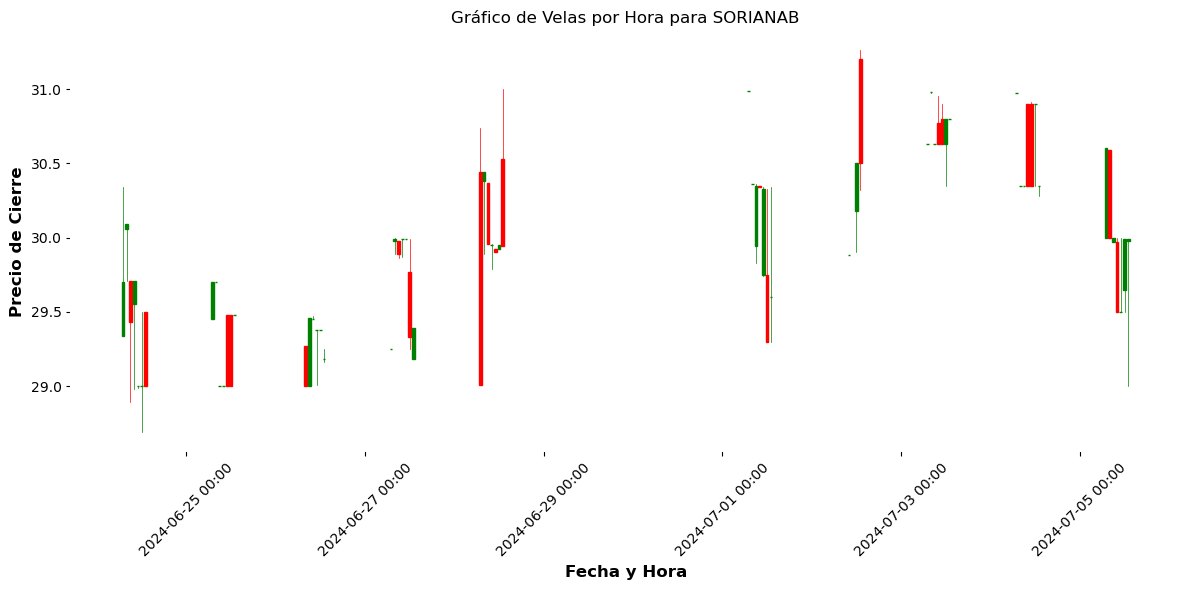

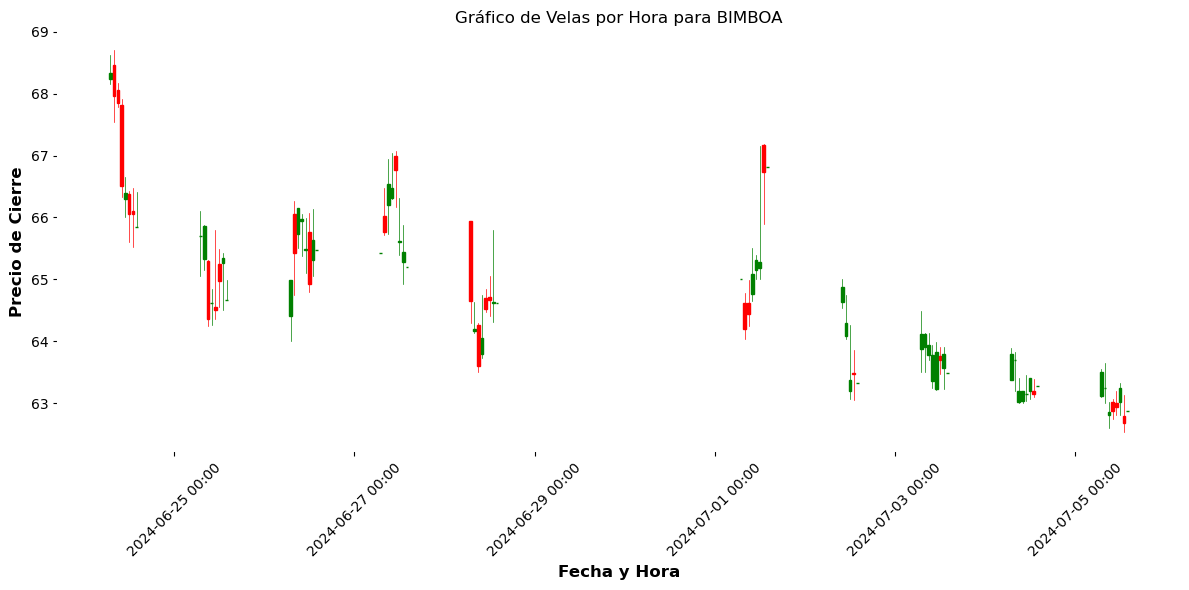

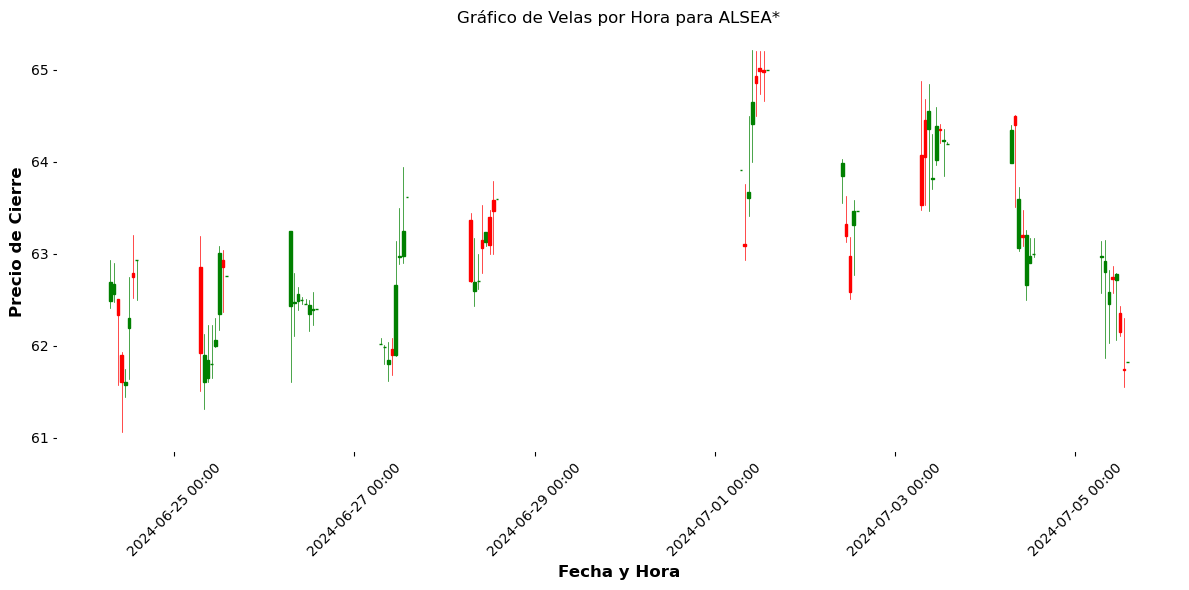

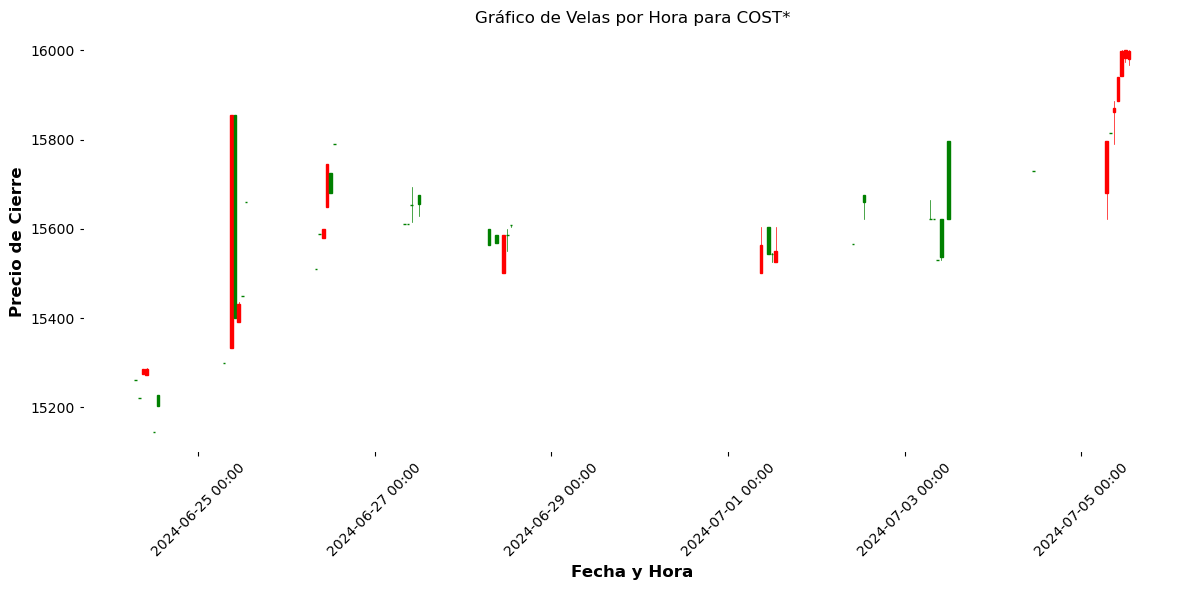

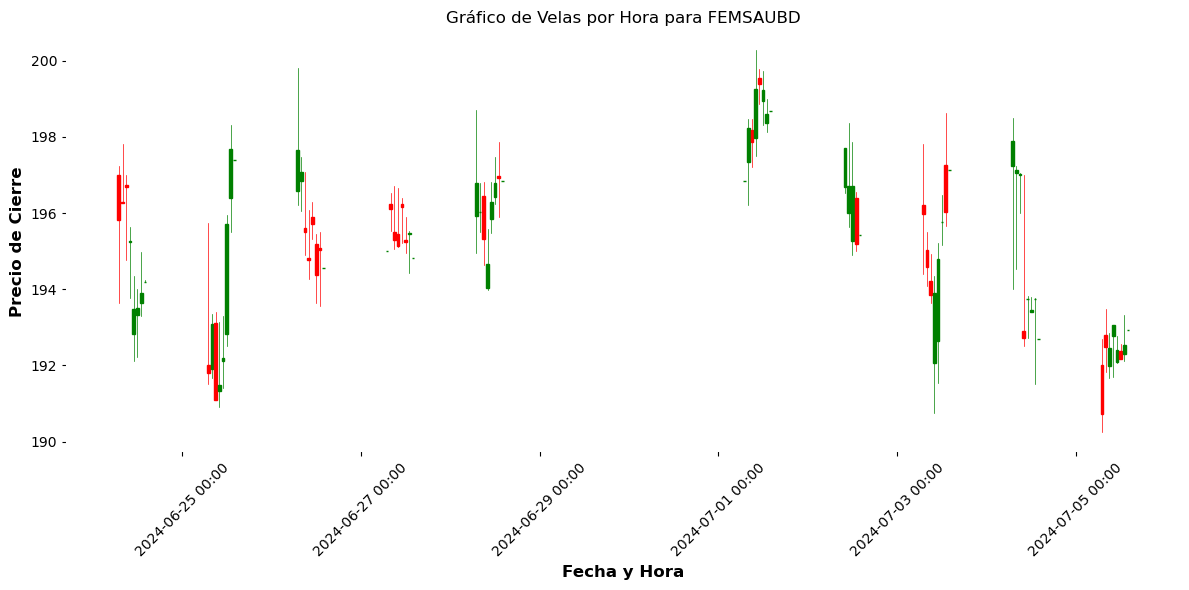

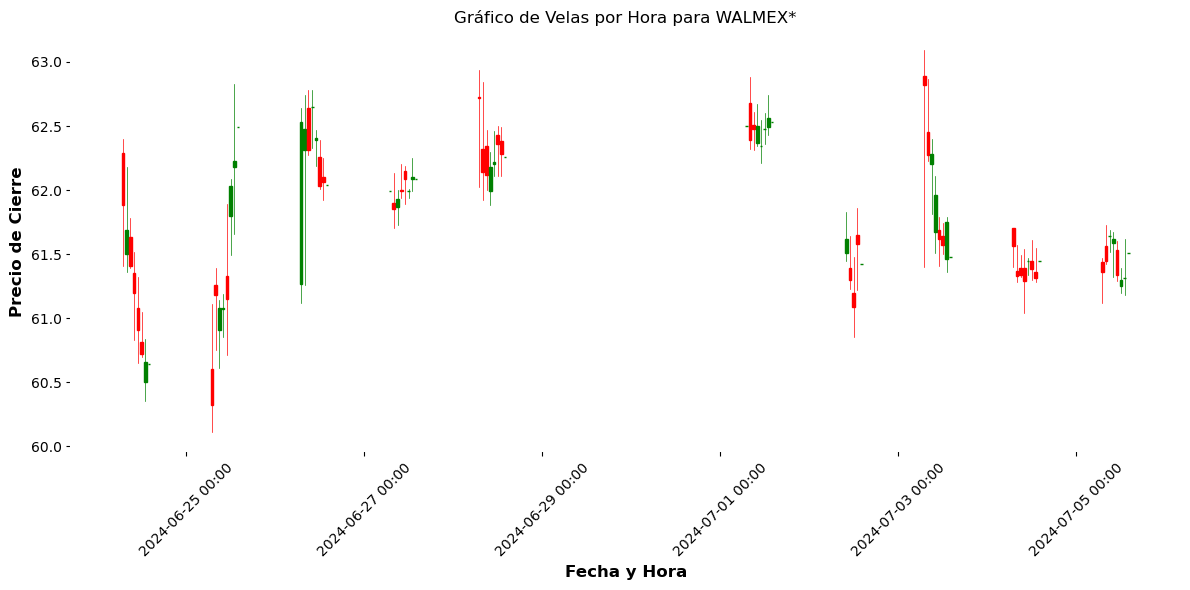

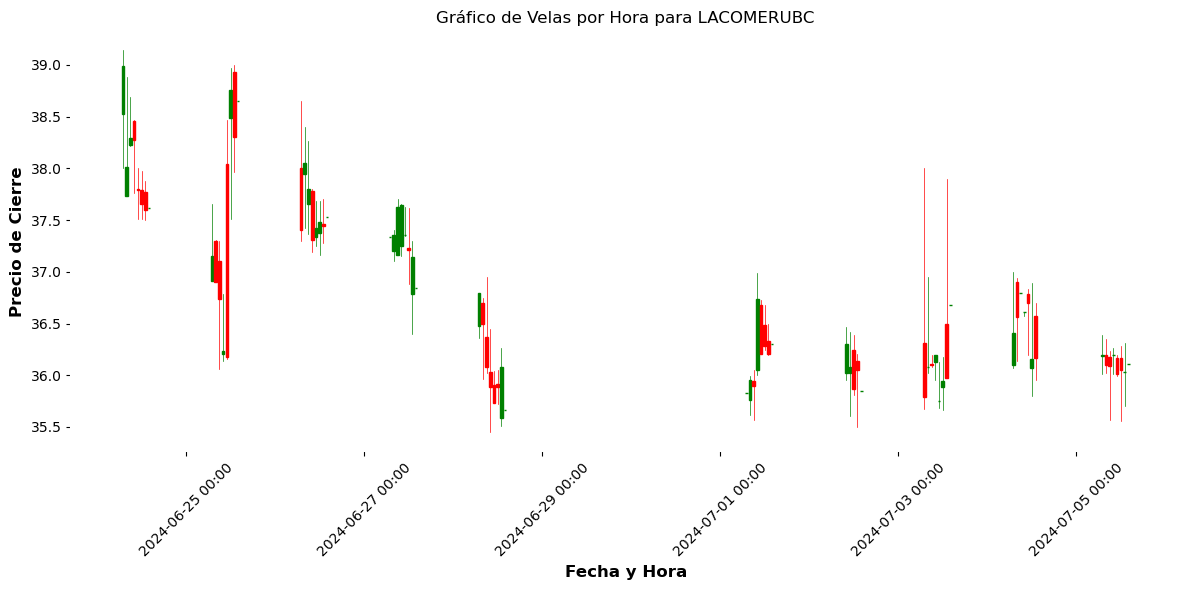

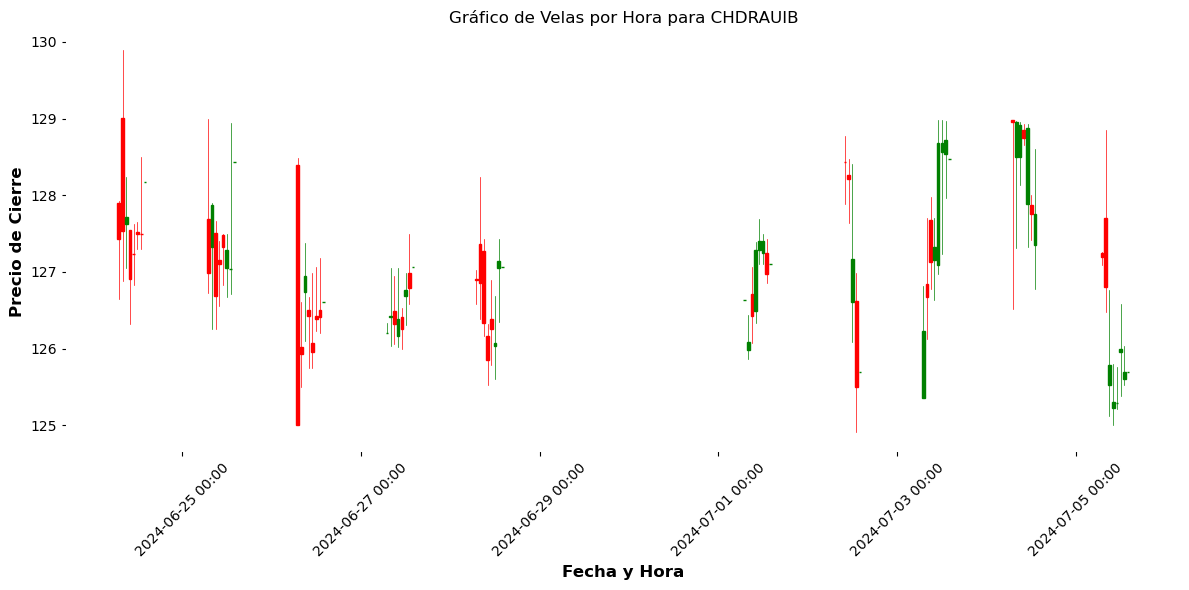

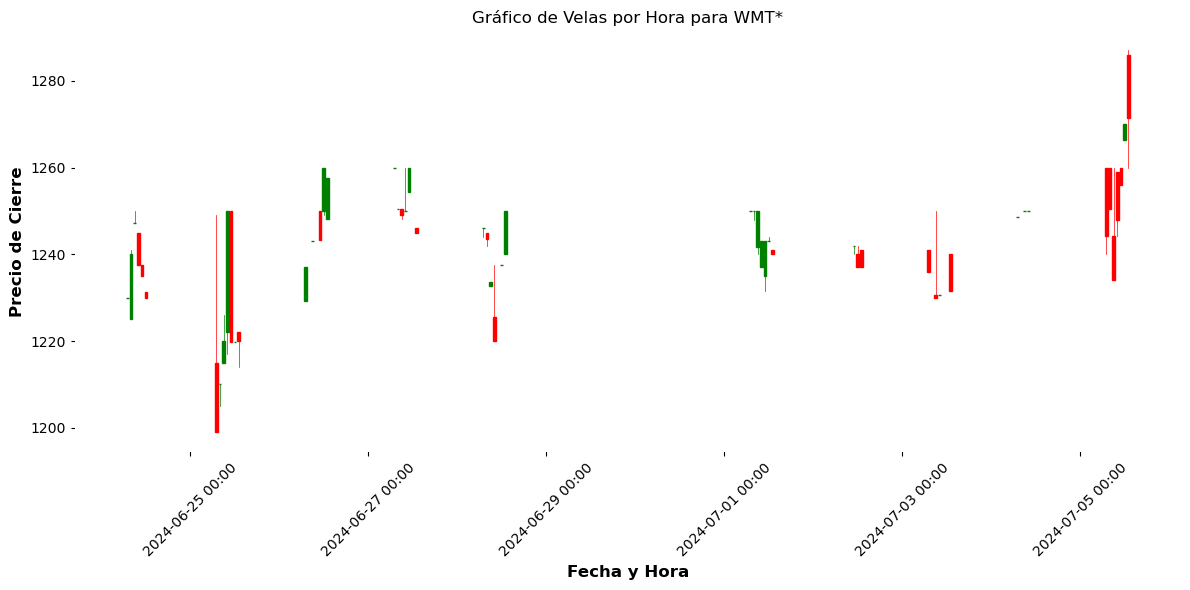

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates
from pyspark.sql import functions as F

# Iterar sobre cada símbolo en el diccionario df_symbols_5min
for symbol, df in df_symbols_5min_ohlc.items():
    # Agrupar por hora y calcular los valores OHLC y volumen
    df_hourly = df.groupBy(F.window("datetime_5min", "1 hour").alias("hour_window")) \
                  .agg(
                      F.first("close").alias("open"),
                      F.max("high").alias("high"),
                      F.min("low").alias("low"),
                      F.last("close").alias("close"),
                      F.sum("volume").alias("volume")
                  ) \
                  .select(
                      F.col("hour_window.start").alias("datetime"),
                      "open", "high", "low", "close", "volume"
                  ) \
                  .orderBy("datetime")

    # Convertir a DataFrame de Pandas
    pandas_df = df_hourly.toPandas()

    # Convertir la columna de fecha y hora a formato numérico para la gráfica de velas
    pandas_df["datetime"] = pd.to_datetime(pandas_df["datetime"])
    pandas_df["datetime"] = pandas_df["datetime"].map(mdates.date2num)

    # Crear el gráfico de velas
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title(f"Gráfico de Velas por Hora para {symbol}")
    ax.set_xlabel("Fecha y Hora")
    ax.set_ylabel("Precio de Cierre")

    # Formatear la fecha en el eje x
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))

    # Generar los datos OHLC para el gráfico de velas
    ohlc_data = pandas_df[["datetime", "open", "high", "low", "close"]].values
    candlestick_ohlc(ax, ohlc_data, width=0.03, colorup="green", colordown="red")

    # Ajustar los ejes y mostrar el gráfico
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()


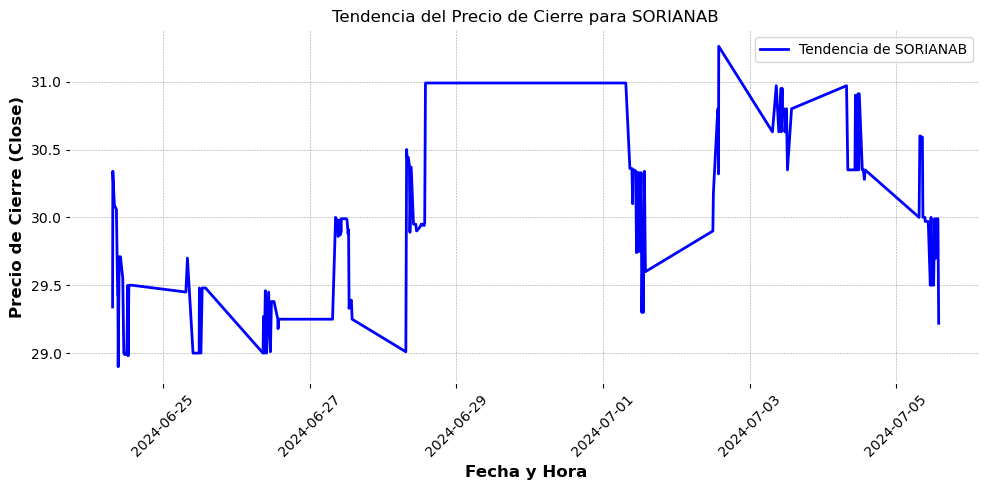

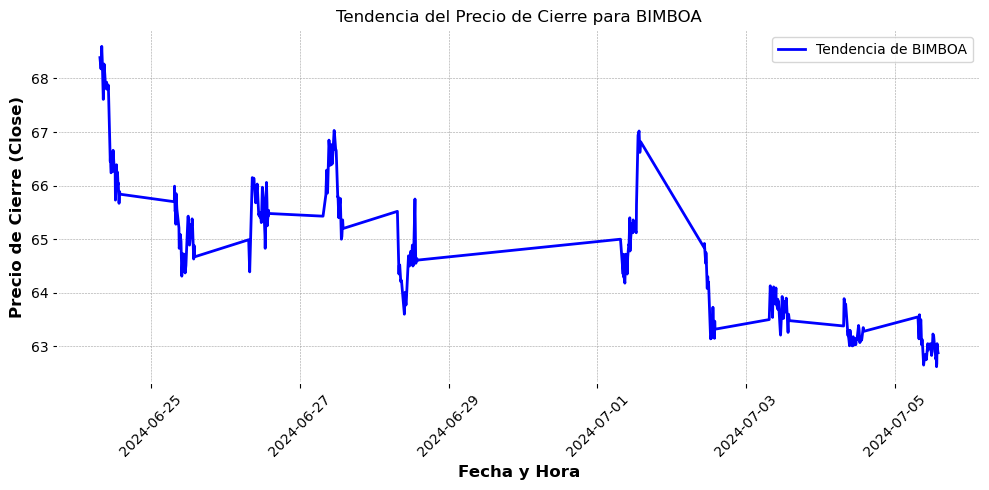

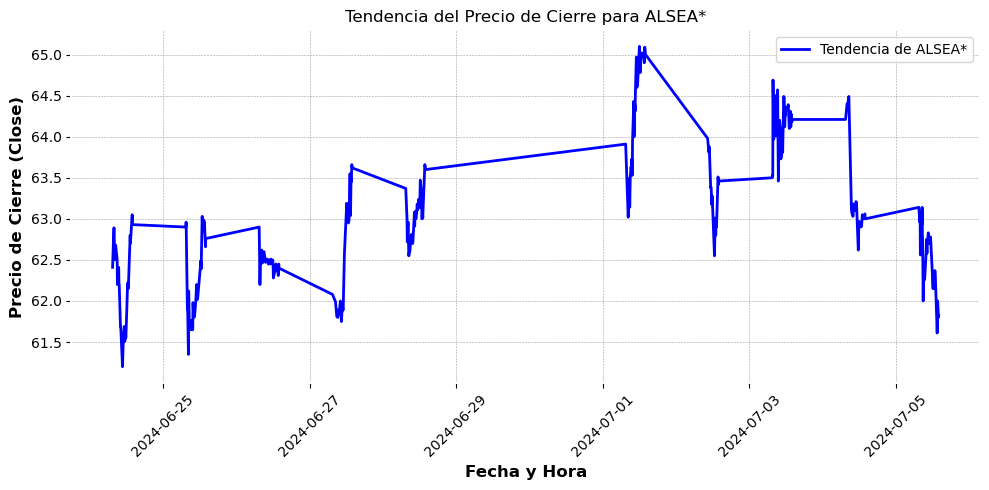

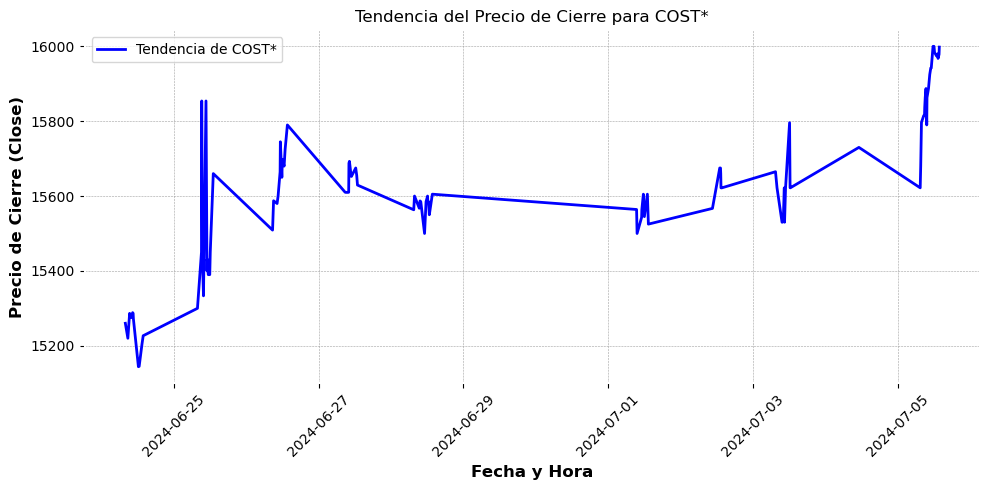

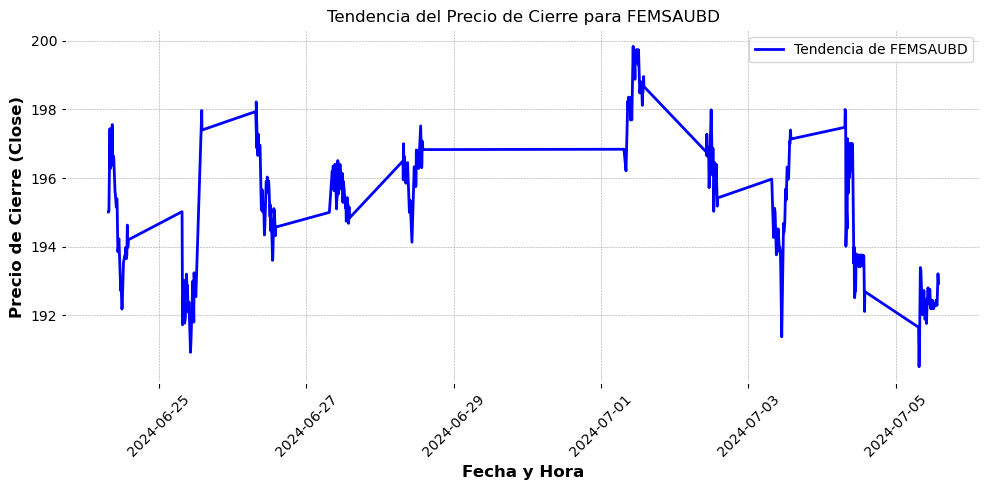

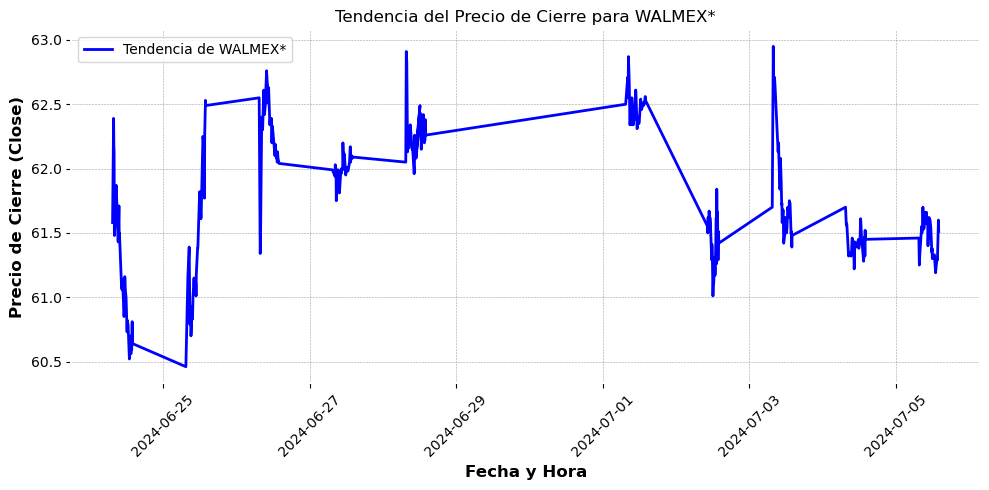

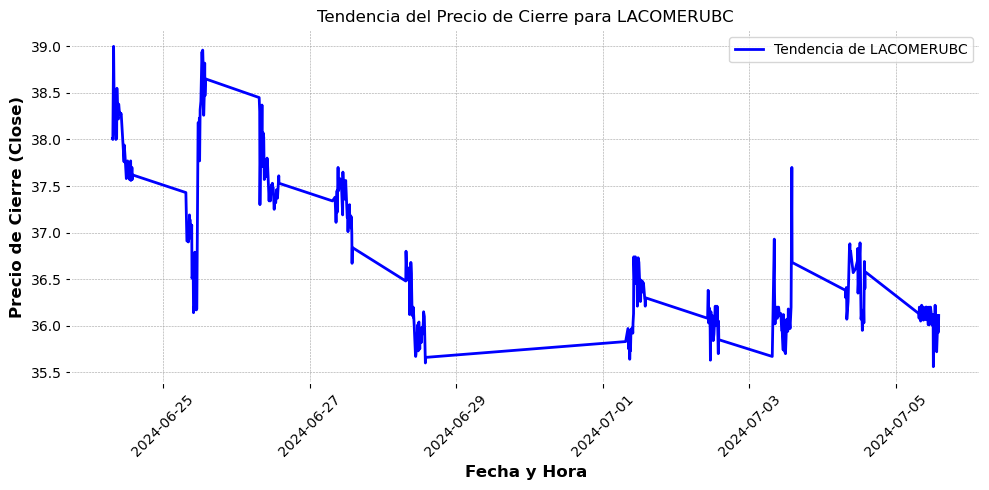

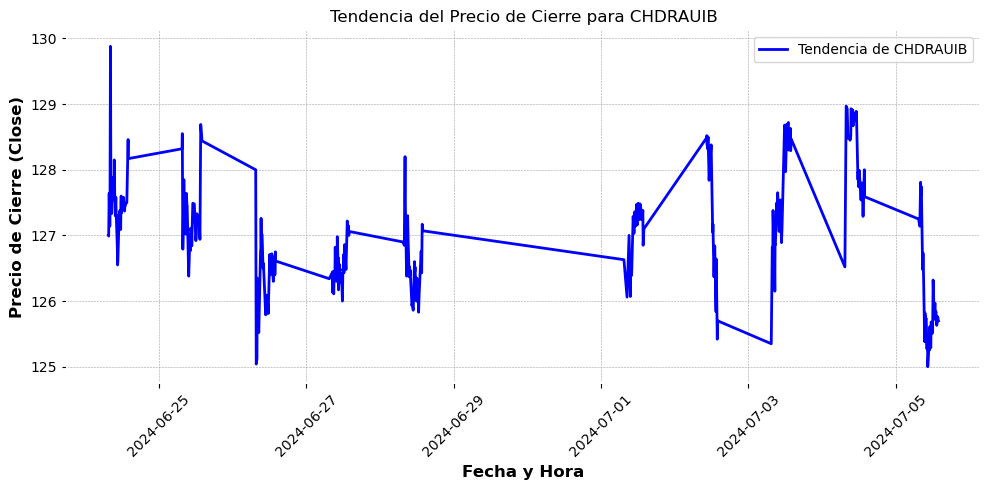

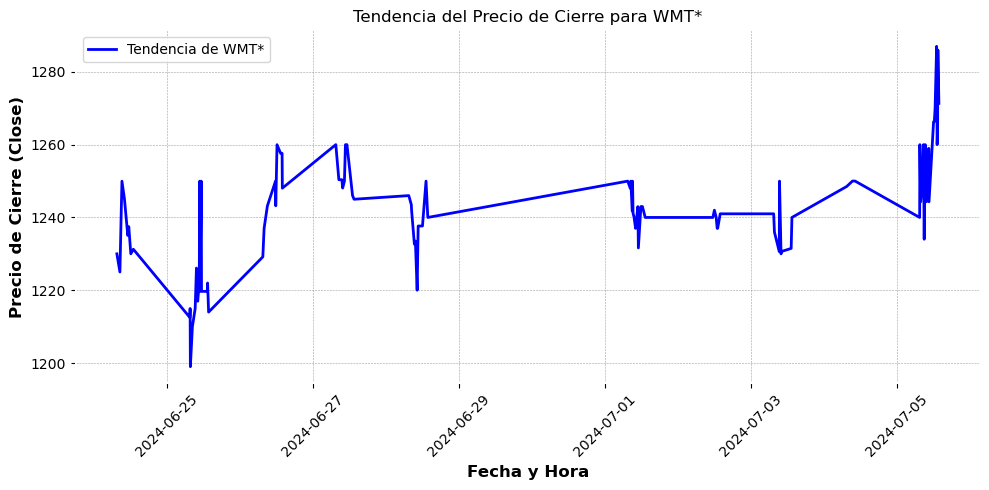

In [81]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# Convertir cada DataFrame de PySpark a Pandas y graficar la tendencia de precios
for symbol, df in df_symbols_5min_ohlc.items():
    # Convertir el DataFrame de PySpark a Pandas
    pandas_df = df.select("datetime_5min", "close").orderBy("datetime_5min").toPandas()
    
    # Crear una gráfica de línea para la tendencia del precio
    plt.figure(figsize=(10, 5))
    plt.plot(pandas_df["datetime_5min"], pandas_df["close"], label=f"Tendencia de {symbol}", color="blue")
    plt.title(f"Tendencia del Precio de Cierre para {symbol}")
    plt.xlabel("Fecha y Hora")
    plt.ylabel("Precio de Cierre (Close)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [82]:
df_symbols_5min

{'SORIANAB': DataFrame[datetime_5min: timestamp, close: double, volume: bigint, minute_start: timestamp, minute_end: timestamp, lagged_close: double, lagged_volume: bigint],
 'BIMBOA': DataFrame[datetime_5min: timestamp, close: double, volume: bigint, minute_start: timestamp, minute_end: timestamp, lagged_close: double, lagged_volume: bigint],
 'ALSEA*': DataFrame[datetime_5min: timestamp, close: double, volume: bigint, minute_start: timestamp, minute_end: timestamp, lagged_close: double, lagged_volume: bigint],
 'COST*': DataFrame[datetime_5min: timestamp, close: double, volume: bigint, minute_start: timestamp, minute_end: timestamp, lagged_close: double, lagged_volume: bigint],
 'FEMSAUBD': DataFrame[datetime_5min: timestamp, close: double, volume: bigint, minute_start: timestamp, minute_end: timestamp, lagged_close: double, lagged_volume: bigint],
 'WALMEX*': DataFrame[datetime_5min: timestamp, close: double, volume: bigint, minute_start: timestamp, minute_end: timestamp, lagged_clo

In [83]:
import pandas as pd
from datetime import datetime, timedelta
from pyspark.sql import functions as F
from pyspark.sql import Window

# Crear un DataFrame base con intervalos de 5 minutos, desde las 7:30 am hasta las 2:30 pm
start_time = "07:30:00"
end_time = "14:30:00"
trade_dates = df_symbols_5min["WALMEX*"].select("minute_start").rdd.map(lambda x: x[0].date()).distinct().collect()

# Generar el rango de tiempos usando pandas para cada fecha en `trade_dates`
base_times = []
for trade_date in trade_dates:
    start_dt = datetime.strptime(f"{trade_date} {start_time}", "%Y-%m-%d %H:%M:%S")
    end_dt = datetime.strptime(f"{trade_date} {end_time}", "%Y-%m-%d %H:%M:%S")
    current_time = start_dt
    while current_time <= end_dt:
        base_times.append(current_time)
        current_time += timedelta(minutes=5)

# Crear un DataFrame de pandas y convertirlo a PySpark
base_df_pd = pd.DataFrame(base_times, columns=["minute_start"])
base_df = spark.createDataFrame(base_df_pd)

# Procesar el DataFrame de WALMEX (sin el carácter especial *)
df_walmex = df_symbols_5min["WALMEX*"].withColumnRenamed("close", "close_WALMEX") \
                                      .withColumnRenamed("lagged_close", "lagged_close_WALMEX") \
                                      .withColumnRenamed("minute_start", "minute_start") \
                                      .withColumnRenamed("minute_end", "minute_end")

# Unir el DataFrame de WALMEX con el DataFrame base
combined_df = base_df.join(df_walmex, on="minute_start", how="left")

In [84]:
# Mostrar los primeros registros para verificar
combined_df.orderBy("minute_start").show(5)

+-------------------+-------------------+------------+------+-------------------+-------------------+-------------+
|       minute_start|      datetime_5min|close_WALMEX|volume|         minute_end|lagged_close_WALMEX|lagged_volume|
+-------------------+-------------------+------------+------+-------------------+-------------------+-------------+
|2024-06-24 07:30:00|               NULL|        NULL|  NULL|               NULL|               NULL|         NULL|
|2024-06-24 07:35:00|2024-06-24 07:35:00|       61.87|165811|2024-06-24 07:40:00|               61.6|        80481|
|2024-06-24 07:40:00|2024-06-24 07:40:00|       61.88| 72170|2024-06-24 07:45:00|              61.87|       165811|
|2024-06-24 07:45:00|2024-06-24 07:45:00|       62.29| 25755|2024-06-24 07:50:00|              61.88|        72170|
|2024-06-24 07:50:00|2024-06-24 07:50:00|       62.26| 31307|2024-06-24 07:55:00|              62.29|        25755|
+-------------------+-------------------+------------+------+-----------

In [85]:
import pandas as pd
from datetime import datetime, timedelta
from pyspark.sql import functions as F

# Crear un DataFrame base con intervalos de 5 minutos, desde las 7:30 am hasta las 2:30 pm
start_time = "07:30:00"
end_time = "14:30:00"
trade_dates = df_symbols_5min["WALMEX*"].select("minute_start").rdd.map(lambda x: x[0].date()).distinct().collect()

# Generar el rango de tiempos usando pandas para cada fecha en `trade_dates`
base_times = []
for trade_date in trade_dates:
    start_dt = datetime.strptime(f"{trade_date} {start_time}", "%Y-%m-%d %H:%M:%S")
    end_dt = datetime.strptime(f"{trade_date} {end_time}", "%Y-%m-%d %H:%M:%S")
    current_time = start_dt
    while current_time <= end_dt:
        base_times.append(current_time)
        current_time += timedelta(minutes=5)

# Crear un DataFrame de pandas y convertirlo a PySpark
base_df_pd = pd.DataFrame(base_times, columns=["minute_start"])
base_df = spark.createDataFrame(base_df_pd)

# Procesar el DataFrame de WALMEX y unirlo a la base
df_walmex = df_symbols_5min["WALMEX*"].withColumnRenamed("close", "close_WALMEX") \
                                      .withColumnRenamed("lagged_close", "lagged_close_WALMEX")
                                      # .withColumnRenamed("volume", "volume_WALMEX") \
                                      # .withColumnRenamed("lagged_volume", "lagged_volume_WALMEX")

# Unir el DataFrame de WALMEX con el DataFrame base
combined_df = base_df.join(df_walmex, on="minute_start", how="left")

# Iterar sobre los otros símbolos y unirlos al DataFrame combinado
for symbol, df_symbol in df_symbols_5min.items():
    if symbol == "WALMEX*":  # Saltar WALMEX ya que ya se ha agregado
        continue
    
    # Limpiar y renombrar las columnas del símbolo actual
    clean_symbol = symbol.replace("*", "")  # Remover caracteres especiales del nombre de la columna
    # df_symbol = df_symbol.withColumnRenamed("close", f"close_{clean_symbol}") \
    #                     .withColumnRenamed("volume", f"volume_{clean_symbol}") \
    #                     .withColumnRenamed("lagged_close", f"lagged_close_{clean_symbol}") \
    #                     .withColumnRenamed("lagged_volume", f"lagged_volume_{clean_symbol}")
    
    df_symbol = df_symbol.withColumnRenamed("lagged_close", f"lagged_close_{clean_symbol}")

    # Eliminar la columna `minute_end` antes de la unión, si no es el primer símbolo
    df_symbol = df_symbol.drop("minute_end")
    df_symbol = df_symbol.drop("close")
    df_symbol = df_symbol.drop("volume")
    df_symbol = df_symbol.drop("lagged_volume")
    df_symbol = df_symbol.drop("datetime_5min")
    
    # Unir el DataFrame del símbolo actual con el DataFrame combinado
    combined_df = combined_df.join(df_symbol, on="minute_start", how="left")

# Filtrar filas donde "close_WALMEX" es NULL o vacío
combined_df_filtered = combined_df.filter(F.col("close_WALMEX").isNotNull())

# Mostrar los primeros registros para verificar
combined_df_filtered.orderBy("minute_start").show(5)


+-------------------+-------------------+------------+------+-------------------+-------------------+-------------+---------------------+-------------------+------------------+-----------------+---------------------+-----------------------+---------------------+----------------+
|       minute_start|      datetime_5min|close_WALMEX|volume|         minute_end|lagged_close_WALMEX|lagged_volume|lagged_close_SORIANAB|lagged_close_BIMBOA|lagged_close_ALSEA|lagged_close_COST|lagged_close_FEMSAUBD|lagged_close_LACOMERUBC|lagged_close_CHDRAUIB|lagged_close_WMT|
+-------------------+-------------------+------------+------+-------------------+-------------------+-------------+---------------------+-------------------+------------------+-----------------+---------------------+-----------------------+---------------------+----------------+
|2024-06-24 07:35:00|2024-06-24 07:35:00|       61.87|165811|2024-06-24 07:40:00|               61.6|        80481|                29.34|              68.39|   

In [86]:
from pyspark.sql import functions as F

# Filtrar columnas que contienen "close" o "volume" con nombres completos para evitar ambigüedad
relevant_columns = [col for col in combined_df_filtered.columns if "close_" in col or "volume_" in col]
print(f"Relevant columns: {relevant_columns}")

# Seleccionar las columnas relevantes con nombres completos y convertir a un DataFrame de Pandas
df_pandas = combined_df_filtered.select(*relevant_columns).toPandas()

# Generar la matriz de correlación
correlation_matrix = df_pandas.corr()

# Mostrar la matriz de correlación
print(correlation_matrix)


Relevant columns: ['close_WALMEX', 'lagged_close_WALMEX', 'lagged_close_SORIANAB', 'lagged_close_BIMBOA', 'lagged_close_ALSEA', 'lagged_close_COST', 'lagged_close_FEMSAUBD', 'lagged_close_LACOMERUBC', 'lagged_close_CHDRAUIB', 'lagged_close_WMT']
                         close_WALMEX  lagged_close_WALMEX  \
close_WALMEX                 1.000000             0.974324   
lagged_close_WALMEX          0.974324             1.000000   
lagged_close_SORIANAB        0.113386             0.094992   
lagged_close_BIMBOA          0.168878             0.177320   
lagged_close_ALSEA           0.397080             0.404669   
lagged_close_COST            0.110172             0.112628   
lagged_close_FEMSAUBD        0.584807             0.594909   
lagged_close_LACOMERUBC     -0.034322            -0.039153   
lagged_close_CHDRAUIB       -0.310118            -0.304773   
lagged_close_WMT             0.124813             0.154884   

                         lagged_close_SORIANAB  lagged_close_BIMBOA  \


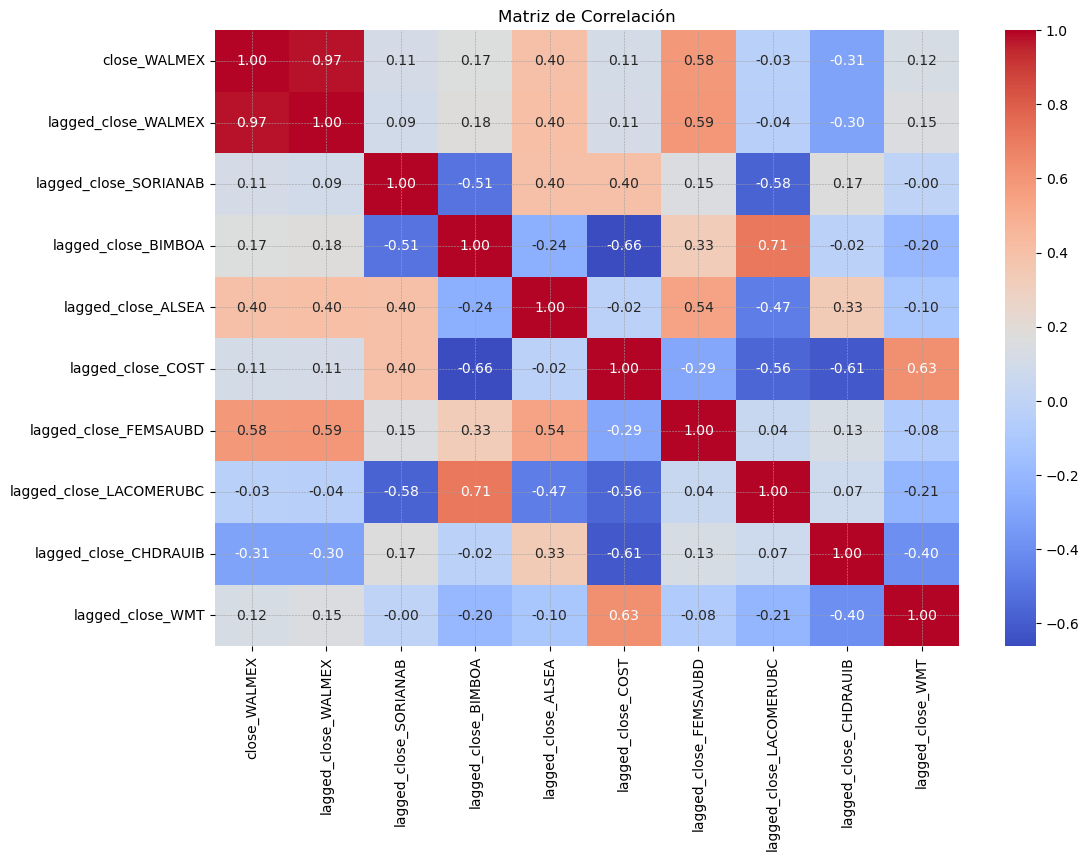

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generar el mapa de calor de la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

2. Modelo de Regresión para Predicción de Precios


Este modelo de regresión lineal intenta predecir el precio en función de otras variables.

In [88]:
from functools import reduce
from pyspark.sql import functions as F

# Crear una condición que verifique si alguna columna tiene un valor nulo
null_condition = reduce(lambda a, b: a | b, [F.col(c).isNull() for c in combined_df_filtered.columns])

# Filtrar filas con al menos un valor nulo en cualquier columna
df_with_any_nulls = combined_df_filtered.filter(null_condition)

df_with_any_nulls.orderBy("minute_start").show(5)

+-------------------+-------------------+------------+------+-------------------+-------------------+-------------+---------------------+-------------------+------------------+-----------------+---------------------+-----------------------+---------------------+----------------+
|       minute_start|      datetime_5min|close_WALMEX|volume|         minute_end|lagged_close_WALMEX|lagged_volume|lagged_close_SORIANAB|lagged_close_BIMBOA|lagged_close_ALSEA|lagged_close_COST|lagged_close_FEMSAUBD|lagged_close_LACOMERUBC|lagged_close_CHDRAUIB|lagged_close_WMT|
+-------------------+-------------------+------------+------+-------------------+-------------------+-------------+---------------------+-------------------+------------------+-----------------+---------------------+-----------------------+---------------------+----------------+
|2024-06-24 07:35:00|2024-06-24 07:35:00|       61.87|165811|2024-06-24 07:40:00|               61.6|        80481|                29.34|              68.39|   

In [89]:
from pyspark.sql import Window
from pyspark.sql import functions as F

# Define un esquema de ventana ordenado por "minute_start" para cada columna de la emisora.
window_spec = Window.orderBy("minute_start").rowsBetween(Window.unboundedPreceding, 0)

# Lista de columnas que contienen valores numéricos y requieren relleno hacia adelante
columns_to_fill = [col for col in combined_df_filtered.columns if "close" in col or "volume" in col]

# Aplica forward fill para cada columna en `columns_to_fill`
for col in columns_to_fill:
    combined_df_filtered = combined_df_filtered.withColumn(
        col, F.last(col, ignorenulls=True).over(window_spec)
    )

# Filtrar filas donde "close_WALMEX" es NULL o vacío
combined_df_filtered = combined_df_filtered.filter(F.col("close_WALMEX").isNotNull())

# Mostrar algunos registros después de aplicar el relleno
combined_df_filtered.orderBy("minute_start").show(5)

+-------------------+-------------------+------------+------+-------------------+-------------------+-------------+---------------------+-------------------+------------------+-----------------+---------------------+-----------------------+---------------------+----------------+
|       minute_start|      datetime_5min|close_WALMEX|volume|         minute_end|lagged_close_WALMEX|lagged_volume|lagged_close_SORIANAB|lagged_close_BIMBOA|lagged_close_ALSEA|lagged_close_COST|lagged_close_FEMSAUBD|lagged_close_LACOMERUBC|lagged_close_CHDRAUIB|lagged_close_WMT|
+-------------------+-------------------+------------+------+-------------------+-------------------+-------------+---------------------+-------------------+------------------+-----------------+---------------------+-----------------------+---------------------+----------------+
|2024-06-24 07:35:00|2024-06-24 07:35:00|       61.87|165811|2024-06-24 07:40:00|               61.6|        80481|                29.34|              68.39|   

In [90]:
from pyspark.sql import Window
from pyspark.sql import functions as F

# Lista de columnas que necesitan relleno hacia atrás
columns_to_fill = [col for col in combined_df_filtered.columns if "close" in col or "volume" in col]

# Hacer una copia temporal del DataFrame ordenado en orden descendente para simular un backward fill
df_desc = combined_df_filtered.orderBy(F.col("minute_start").desc())

# Aplicar el relleno hacia adelante en el DataFrame ordenado en forma descendente
for col in columns_to_fill:
    window_spec = Window.orderBy(F.col("minute_start").desc()).rowsBetween(Window.unboundedPreceding, 0)
    df_desc = df_desc.withColumn(col, F.last(col, ignorenulls=True).over(window_spec))

# Restaurar el orden ascendente original
combined_df_filled = df_desc.orderBy("minute_start")

# Mostrar algunos registros después de aplicar el relleno hacia atrás para verificar
combined_df_filled.show(5)

+-------------------+-------------------+------------+------+-------------------+-------------------+-------------+---------------------+-------------------+------------------+-----------------+---------------------+-----------------------+---------------------+----------------+
|       minute_start|      datetime_5min|close_WALMEX|volume|         minute_end|lagged_close_WALMEX|lagged_volume|lagged_close_SORIANAB|lagged_close_BIMBOA|lagged_close_ALSEA|lagged_close_COST|lagged_close_FEMSAUBD|lagged_close_LACOMERUBC|lagged_close_CHDRAUIB|lagged_close_WMT|
+-------------------+-------------------+------------+------+-------------------+-------------------+-------------+---------------------+-------------------+------------------+-----------------+---------------------+-----------------------+---------------------+----------------+
|2024-06-24 07:35:00|2024-06-24 07:35:00|       61.87|165811|2024-06-24 07:40:00|               61.6|        80481|                29.34|              68.39|   

In [91]:
# Mostrar algunos registros después de aplicar el relleno hacia atrás para verificar
combined_df_filtered.orderBy("minute_start").show(5)

+-------------------+-------------------+------------+------+-------------------+-------------------+-------------+---------------------+-------------------+------------------+-----------------+---------------------+-----------------------+---------------------+----------------+
|       minute_start|      datetime_5min|close_WALMEX|volume|         minute_end|lagged_close_WALMEX|lagged_volume|lagged_close_SORIANAB|lagged_close_BIMBOA|lagged_close_ALSEA|lagged_close_COST|lagged_close_FEMSAUBD|lagged_close_LACOMERUBC|lagged_close_CHDRAUIB|lagged_close_WMT|
+-------------------+-------------------+------------+------+-------------------+-------------------+-------------+---------------------+-------------------+------------------+-----------------+---------------------+-----------------------+---------------------+----------------+
|2024-06-24 07:35:00|2024-06-24 07:35:00|       61.87|165811|2024-06-24 07:40:00|               61.6|        80481|                29.34|              68.39|   

In [92]:
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor, LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
import pandas as pd

# Preparar los datos para los modelos de regresión
if "features" in combined_df_filtered.columns:
    combined_df_filtered = combined_df_filtered.drop("features")

# Seleccionar características y etiqueta
feature_cols = ["lagged_close_WALMEX", "lagged_close_SORIANAB", "lagged_close_FEMSAUBD", "lagged_close_LACOMERUBC", "lagged_close_CHDRAUIB", "lagged_close_WMT", "lagged_close_BIMBOA", "lagged_close_COST", "lagged_close_ALSEA"]

# Eliminar filas con valores nulos en las columnas de características y etiqueta
combined_df_filtered = combined_df_filtered.dropna(subset=feature_cols + ["close_WALMEX"])

# Ensamblar características en una columna vectorial
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
combined_df_filtered = assembler.transform(combined_df_filtered)

# Dividir los datos en conjunto de entrenamiento y prueba
train, test = combined_df_filtered.randomSplit([0.8, 0.2], seed=747)

# Definir evaluadores para RMSE, MAE y R2
evaluator_rmse = RegressionEvaluator(labelCol="close_WALMEX", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="close_WALMEX", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="close_WALMEX", predictionCol="prediction", metricName="r2")

# Lista para almacenar los resultados de las métricas de cada modelo
results = []

# -----------------------------------------------------------
# Modelo 1: LinearRegression
# -----------------------------------------------------------
lr = LinearRegression(featuresCol="features", labelCol="close_WALMEX", predictionCol="prediction")
lr_model = lr.fit(train)
lr_predictions = lr_model.transform(test)

# Evaluación del modelo de Linear Regression
lr_rmse = evaluator_rmse.evaluate(lr_predictions)
lr_mae = evaluator_mae.evaluate(lr_predictions)
lr_r2 = evaluator_r2.evaluate(lr_predictions)

# Guardar resultados
results.append({"Model": "LinearRegression", "RMSE": lr_rmse, "MAE": lr_mae, "R2": lr_r2})

# -----------------------------------------------------------
# Modelo 2: RandomForestRegressor
# -----------------------------------------------------------
rf = RandomForestRegressor(featuresCol="features", labelCol="close_WALMEX", predictionCol="prediction")
rf_model = rf.fit(train)
rf_predictions = rf_model.transform(test)

# Evaluación del modelo de Random Forest
rf_rmse = evaluator_rmse.evaluate(rf_predictions)
rf_mae = evaluator_mae.evaluate(rf_predictions)
rf_r2 = evaluator_r2.evaluate(rf_predictions)

# Guardar resultados
results.append({"Model": "RandomForestRegressor", "RMSE": rf_rmse, "MAE": rf_mae, "R2": rf_r2})

# -----------------------------------------------------------
# Modelo 3: Gradient-Boosted Tree Regressor
# -----------------------------------------------------------
gbt = GBTRegressor(featuresCol="features", labelCol="close_WALMEX", predictionCol="prediction")
gbt_model = gbt.fit(train)
gbt_predictions = gbt_model.transform(test)

# Evaluación del modelo de GBT
gbt_rmse = evaluator_rmse.evaluate(gbt_predictions)
gbt_mae = evaluator_mae.evaluate(gbt_predictions)
gbt_r2 = evaluator_r2.evaluate(gbt_predictions)

# Guardar resultados
results.append({"Model": "GBTRegressor", "RMSE": gbt_rmse, "MAE": gbt_mae, "R2": gbt_r2})

# -----------------------------------------------------------
# Crear un DataFrame de pandas con los resultados y ordenar por RMSE
# -----------------------------------------------------------
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="RMSE", ascending=True)

print("Resultados de las métricas para cada modelo:")
print(results_df)


Resultados de las métricas para cada modelo:
                   Model      RMSE       MAE        R2
0       LinearRegression  0.108654  0.074824  0.954414
2           GBTRegressor  0.117126  0.085092  0.947028
1  RandomForestRegressor  0.122030  0.094069  0.942500


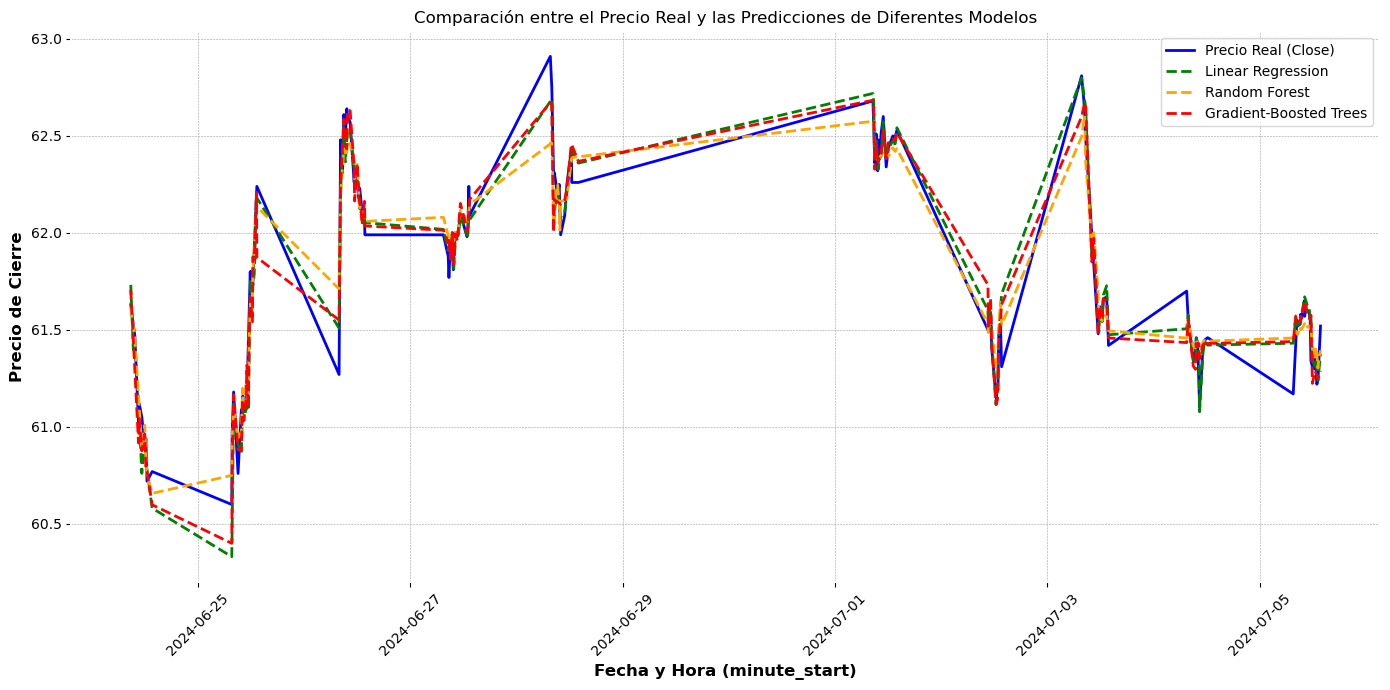

In [93]:
import matplotlib.pyplot as plt

# Convertir el conjunto de prueba y las predicciones de cada modelo en DataFrames de Pandas para la visualización
test_pd = test.select("minute_start", "close_WALMEX").toPandas()
lr_predictions_pd = lr_predictions.select("minute_start", "prediction").toPandas()
rf_predictions_pd = rf_predictions.select("minute_start", "prediction").toPandas()
gbt_predictions_pd = gbt_predictions.select("minute_start", "prediction").toPandas()

# Renombrar las columnas para cada modelo para evitar conflictos en el DataFrame combinado
lr_predictions_pd = lr_predictions_pd.rename(columns={"prediction": "predicted_close_lr"})
rf_predictions_pd = rf_predictions_pd.rename(columns={"prediction": "predicted_close_rf"})
gbt_predictions_pd = gbt_predictions_pd.rename(columns={"prediction": "predicted_close_gbt"})

# Combinar los resultados en un único DataFrame de Pandas para facilitar la comparación
comparison_df = test_pd.merge(lr_predictions_pd, on="minute_start", how="left")
comparison_df = comparison_df.merge(rf_predictions_pd, on="minute_start", how="left")
comparison_df = comparison_df.merge(gbt_predictions_pd, on="minute_start", how="left")

# Configuración de la gráfica
plt.figure(figsize=(14, 7))

# Graficar el precio real
plt.plot(comparison_df["minute_start"], comparison_df["close_WALMEX"], label="Precio Real (Close)", color="blue")

# Graficar las predicciones de cada modelo
plt.plot(comparison_df["minute_start"], comparison_df["predicted_close_lr"], label="Linear Regression", color="green", linestyle="--")
plt.plot(comparison_df["minute_start"], comparison_df["predicted_close_rf"], label="Random Forest", color="orange", linestyle="--")
plt.plot(comparison_df["minute_start"], comparison_df["predicted_close_gbt"], label="Gradient-Boosted Trees", color="red", linestyle="--")

# Etiquetas y título
plt.xlabel("Fecha y Hora (minute_start)")
plt.ylabel("Precio de Cierre")
plt.title("Comparación entre el Precio Real y las Predicciones de Diferentes Modelos")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar la gráfica
plt.show()

3. Clasificación para Determinar si el Precio Subirá o Bajará

Este modelo de clasificación utiliza LogisticRegression para clasificar el comportamiento del precio (sube o baja).


In [94]:
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType
from pyspark.sql import Window
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator

if "features" in combined_df_filtered.columns:
    combined_df_filtered = combined_df_filtered.drop("features")

# Crear columna que indique si el precio sube o baja en el siguiente intervalo
window_spec = Window.orderBy("minute_start")
combined_df_filtered = combined_df_filtered.withColumn("next_close_WALMEX", F.lead("close_WALMEX").over(window_spec))

# Crear la columna de clasificación 'price_direction': 1 si el precio sube, 0 si baja
combined_df_filtered = combined_df_filtered.withColumn(
    "price_direction",
    F.when(F.col("next_close_WALMEX") > F.col("close_WALMEX"), 1).otherwise(0)
)

# Convertir las columnas de características a DoubleType
for col in feature_cols:
    combined_df_filtered = combined_df_filtered.withColumn(col, F.col(col).cast(DoubleType()))

# Eliminar filas con valores nulos en las columnas de características y en la etiqueta
combined_df_filtered = combined_df_filtered.dropna(subset=feature_cols + ["price_direction"])

# Ensamblar las características en una columna vectorial
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
combined_df_filtered = assembler.transform(combined_df_filtered)

# Dividir los datos en conjunto de entrenamiento y prueba
train, test = combined_df_filtered.randomSplit([0.8, 0.2], seed=747)

# Definir el modelo de clasificación: Logistic Regression
lr = LogisticRegression(featuresCol="features", labelCol="price_direction", predictionCol="prediction")
lr_model = lr.fit(train)

# Realizar predicciones en el conjunto de prueba
lr_predictions = lr_model.transform(test)

# Evaluar el modelo de Logistic Regression usando el área bajo la curva ROC
evaluator = BinaryClassificationEvaluator(labelCol="price_direction", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(lr_predictions)

print(f"Área bajo la curva ROC para el modelo Logistic Regression = {roc_auc}")

# Mostrar algunas predicciones
lr_predictions.select("minute_start", "close_WALMEX", "price_direction", "prediction", "probability").show(5)

Área bajo la curva ROC para el modelo Logistic Regression = 0.4740428293316028
+-------------------+------------+---------------+----------+--------------------+
|       minute_start|close_WALMEX|price_direction|prediction|         probability|
+-------------------+------------+---------------+----------+--------------------+
|2024-06-24 08:50:00|       61.63|              1|       0.0|[0.69810642454301...|
|2024-06-24 09:25:00|       61.54|              1|       0.0|[0.66270072875156...|
|2024-06-24 09:45:00|       61.47|              0|       0.0|[0.63638500208266...|
|2024-06-24 10:35:00|       61.02|              1|       0.0|[0.61763074262136...|
|2024-06-24 10:45:00|       61.12|              0|       0.0|[0.61506998920113...|
+-------------------+------------+---------------+----------+--------------------+
only showing top 5 rows



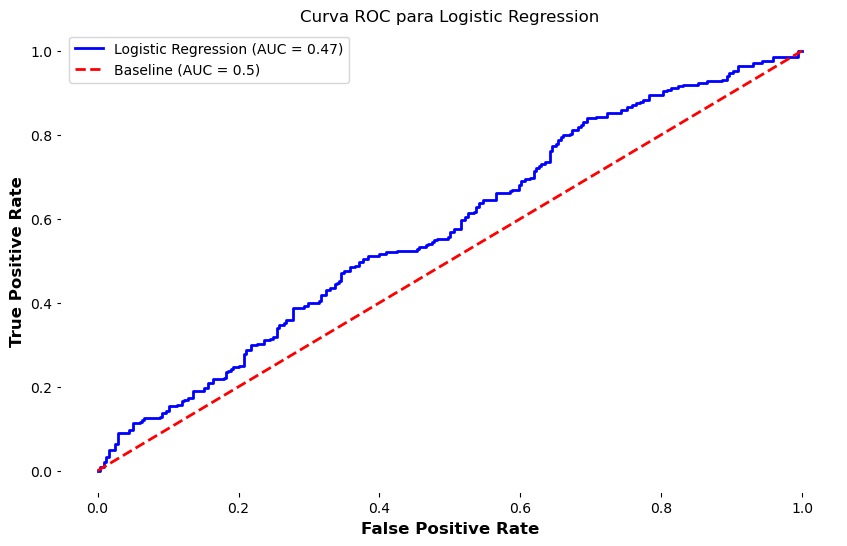

In [95]:
# Obtener los puntos de la curva ROC
training_summary = lr_model.summary
roc = training_summary.roc.toPandas()

# Graficar la curva ROC
plt.figure(figsize=(10, 6))
plt.plot(roc['FPR'], roc['TPR'], label=f'Logistic Regression (AUC = {roc_auc:.2f})', color="blue")
plt.plot([0, 1], [0, 1], 'r--', label="Baseline (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC para Logistic Regression")
plt.legend(loc="best")
plt.grid()
plt.show()

In [96]:
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier

if "features" in combined_df_filtered.columns:
    combined_df_filtered = combined_df_filtered.drop("features")

# Ejemplo de Random Forest
rf = RandomForestClassifier(featuresCol="features", labelCol="price_direction", predictionCol="prediction")
rf_model = rf.fit(train)
rf_predictions = rf_model.transform(test)

# Evaluación
rf_auc = evaluator.evaluate(rf_predictions)
print(f"Área bajo la curva ROC para el modelo Random Forest = {rf_auc}")

# Ejemplo de Gradient Boosted Trees
gbt = GBTClassifier(featuresCol="features", labelCol="price_direction", predictionCol="prediction")
gbt_model = gbt.fit(train)
gbt_predictions = gbt_model.transform(test)

# Evaluación
gbt_auc = evaluator.evaluate(gbt_predictions)
print(f"Área bajo la curva ROC para el modelo Gradient Boosted Trees = {gbt_auc}")


Área bajo la curva ROC para el modelo Random Forest = 0.5187378325762493
Área bajo la curva ROC para el modelo Gradient Boosted Trees = 0.4484912394548994


In [97]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql import functions as F
from pyspark.ml.functions import vector_to_array
from sklearn.metrics import roc_curve

# Evaluador AUC
evaluator = BinaryClassificationEvaluator(labelCol="price_direction", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Entrenar el modelo Random Forest y evaluar AUC
rf = RandomForestClassifier(featuresCol="features", labelCol="price_direction", predictionCol="prediction", probabilityCol="probability")
rf_model = rf.fit(train)
rf_predictions = rf_model.transform(test)
rf_auc = evaluator.evaluate(rf_predictions)
print(f"Área bajo la curva ROC para el modelo Random Forest = {rf_auc}")

# Convertir el vector de probabilidad a un arreglo para obtener la probabilidad de la clase positiva
rf_roc = rf_predictions.withColumn("prob_positive", vector_to_array("probability")[1])

# Entrenar el modelo Gradient Boosted Trees (sin el argumento `rawPredictionCol` o `probabilityCol`)
gbt = GBTClassifier(featuresCol="features", labelCol="price_direction", predictionCol="prediction")
gbt_model = gbt.fit(train)
gbt_predictions = gbt_model.transform(test)
gbt_auc = evaluator.evaluate(gbt_predictions)
print(f"Área bajo la curva ROC para el modelo Gradient Boosted Trees = {gbt_auc}")

Área bajo la curva ROC para el modelo Random Forest = 0.5187378325762493
Área bajo la curva ROC para el modelo Gradient Boosted Trees = 0.4484912394548994


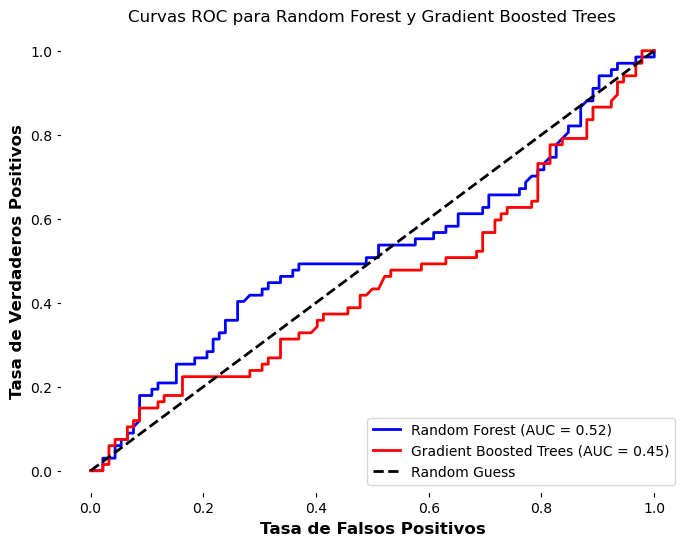

In [98]:
# Extraer la probabilidad para la clase positiva desde `rawPrediction` en el modelo GBT
gbt_roc = gbt_predictions.withColumn("prob_positive", vector_to_array("rawPrediction")[1])

# Convertir a Pandas para graficar
rf_roc_pd = rf_roc.select("prob_positive", "price_direction").toPandas()
gbt_roc_pd = gbt_roc.select("prob_positive", "price_direction").toPandas()

# Generar FPR y TPR para diferentes umbrales
# Curva ROC para Random Forest
rf_fpr, rf_tpr, _ = roc_curve(rf_roc_pd["price_direction"], rf_roc_pd["prob_positive"])

# Curva ROC para Gradient Boosted Trees
gbt_fpr, gbt_tpr, _ = roc_curve(gbt_roc_pd["price_direction"], gbt_roc_pd["prob_positive"])

# Graficar las curvas ROC
plt.figure(figsize=(8, 6))
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC = {rf_auc:.2f})", color="blue")
plt.plot(gbt_fpr, gbt_tpr, label=f"Gradient Boosted Trees (AUC = {gbt_auc:.2f})", color="red")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")

plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curvas ROC para Random Forest y Gradient Boosted Trees")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [99]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml.feature import VectorAssembler

# Assuming `combined_df_filtered` has been prepared with feature columns and label
if "features" in combined_df_filtered.columns:
    combined_df_filtered = combined_df_filtered.drop("features")

# Specify feature columns
feature_cols = ["lagged_close_WALMEX", "lagged_close_SORIANAB", "lagged_close_FEMSAUBD", 
                "lagged_close_LACOMERUBC", "lagged_close_CHDRAUIB", "lagged_close_WMT",
                "lagged_close_BIMBOA", "lagged_close_COST", "lagged_close_ALSEA"]

# Assemble features
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
combined_df_filtered = assembler.transform(combined_df_filtered)

# Split data into training and testing
train, test = combined_df_filtered.randomSplit([0.8, 0.2], seed=747)

# Initialize models
rf = RandomForestClassifier(featuresCol="features", labelCol="price_direction", predictionCol="prediction")
gbt = GBTClassifier(featuresCol="features", labelCol="price_direction", predictionCol="prediction")

# Train the models
rf_model = rf.fit(train)
gbt_model = gbt.fit(train)

# Extract feature importances
rf_feature_importances = rf_model.featureImportances.toArray()
gbt_feature_importances = gbt_model.featureImportances.toArray()

# Convert to DataFrames for easier plotting
importance_df = pd.DataFrame({
    "Feature": feature_cols,
    "RandomForest Importance": rf_feature_importances,
    "GBT Importance": gbt_feature_importances
})

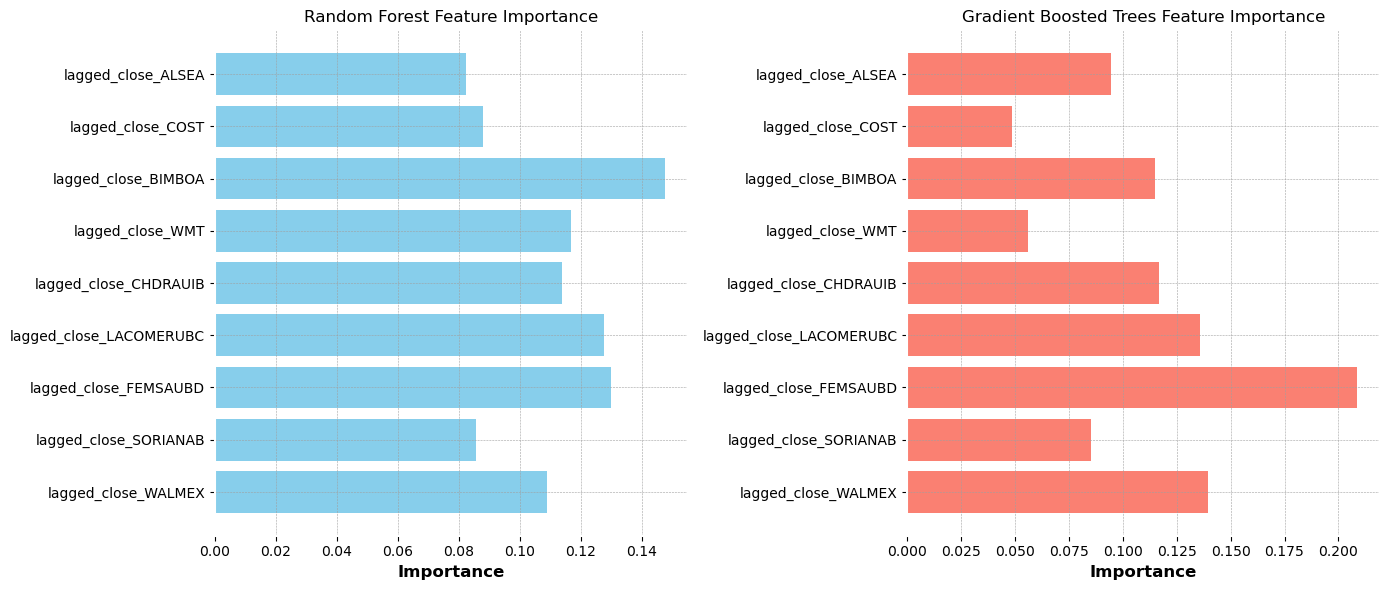

In [100]:
# Plot feature importances
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Random Forest feature importance
ax[0].barh(importance_df["Feature"], importance_df["RandomForest Importance"], color="skyblue")
ax[0].set_title("Random Forest Feature Importance")
ax[0].set_xlabel("Importance")

# Gradient Boosted Trees feature importance
ax[1].barh(importance_df["Feature"], importance_df["GBT Importance"], color="salmon")
ax[1].set_title("Gradient Boosted Trees Feature Importance")
ax[1].set_xlabel("Importance")

plt.tight_layout()
plt.show()


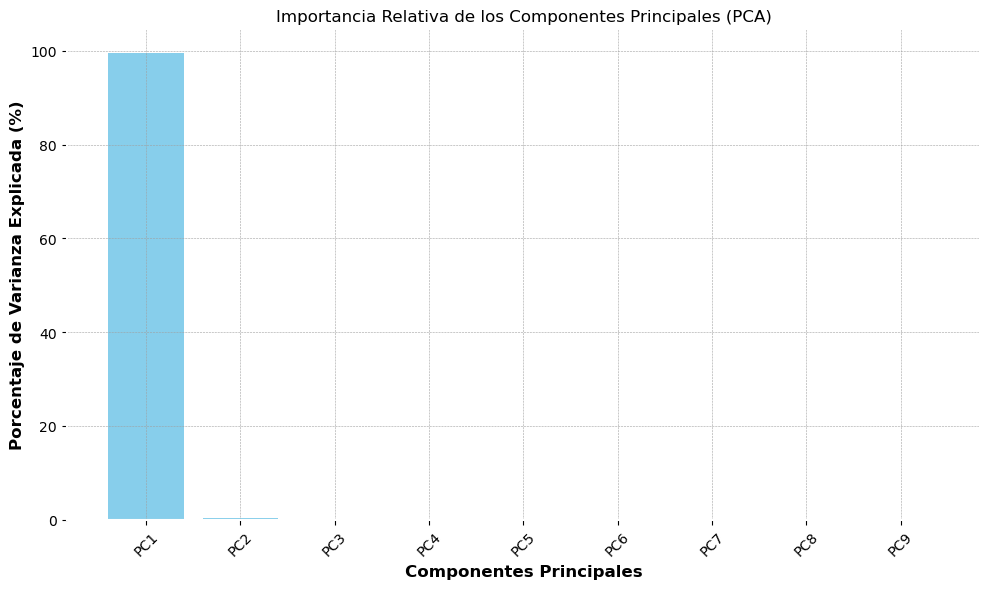

  Componente Principal  Varianza Explicada (%)  Varianza Acumulada (%)
0                  PC1               99.594358               99.594358
1                  PC2                0.380991               99.975349
2                  PC3                0.014806               99.990155
3                  PC4                0.005489               99.995643
4                  PC5                0.001795               99.997439
5                  PC6                0.001123               99.998562
6                  PC7                0.000622               99.999184
7                  PC8                0.000530               99.999713
8                  PC9                0.000287              100.000000


In [101]:
from pyspark.ml.feature import PCA, VectorAssembler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

if "features" in combined_df_filtered.columns:
    combined_df_filtered = combined_df_filtered.drop("features")

# Seleccionar características para PCA
feature_cols = ["lagged_close_WALMEX", "lagged_close_SORIANAB", "lagged_close_FEMSAUBD", 
                "lagged_close_LACOMERUBC", "lagged_close_CHDRAUIB", "lagged_close_WMT",
                "lagged_close_BIMBOA", "lagged_close_COST", "lagged_close_ALSEA"]

# Ensamblar características en una columna vectorial
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
combined_df_filtered = assembler.transform(combined_df_filtered)

# Configurar y ajustar el modelo de PCA
pca = PCA(k=len(feature_cols), inputCol="features", outputCol="pca_features")
pca_model = pca.fit(combined_df_filtered)

# Extraer la importancia de cada componente
explained_variance = pca_model.explainedVariance.toArray()

# Crear una gráfica de barras para mostrar la varianza explicada por cada componente principal
plt.figure(figsize=(10, 6))
components = [f'PC{i+1}' for i in range(len(explained_variance))]
plt.bar(components, explained_variance * 100, color="skyblue")

# Etiquetas y título
plt.xlabel("Componentes Principales")
plt.ylabel("Porcentaje de Varianza Explicada (%)")
plt.title("Importancia Relativa de los Componentes Principales (PCA)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Mostrar la varianza acumulada para cada componente principal en un DataFrame
cumulative_variance = np.cumsum(explained_variance)
variance_df = pd.DataFrame({"Componente Principal": components, 
                            "Varianza Explicada (%)": explained_variance * 100, 
                            "Varianza Acumulada (%)": cumulative_variance * 100})
print(variance_df)

In [102]:
# Obtener las cargas de los componentes principales
loadings = pca_model.pc.toArray()

# Crear un DataFrame para las cargas
loadings_df = pd.DataFrame(loadings, columns=feature_cols, index=[f"PC{i+1}" for i in range(len(feature_cols))])
print("Cargas de los Componentes Principales:")
print(loadings_df)

Cargas de los Componentes Principales:
     lagged_close_WALMEX  lagged_close_SORIANAB  lagged_close_FEMSAUBD  \
PC1            -0.000742              -0.001303              -0.163739   
PC2            -0.001136              -0.005580              -0.052518   
PC3             0.001117               0.000874              -0.934943   
PC4             0.002139               0.018049               0.006085   
PC5             0.001971              -0.001470              -0.037756   
PC6            -0.044746               0.998248               0.001426   
PC7             0.003935               0.030096              -0.177006   
PC8            -0.998985              -0.044540              -0.001527   
PC9            -0.000633              -0.015795              -0.252023   

     lagged_close_LACOMERUBC  lagged_close_CHDRAUIB  lagged_close_WMT  \
PC1                -0.087500               0.156158         -0.206606   
PC2                 0.287338               0.107603         -0.182070   
P

In [103]:
from pyspark.ml.feature import PCA, VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import functions as F
from pyspark.sql.types import ArrayType, DoubleType
from pyspark.sql import SparkSession

if "features" in combined_df_filtered.columns:
    combined_df_filtered = combined_df_filtered.drop("features")

# Función UDF para convertir un vector en un array
def vector_to_array_udf(v):
    return v.toArray().tolist()

vector_to_array = F.udf(vector_to_array_udf, ArrayType(DoubleType()))

# Paso 1: Preparar los datos para PCA
feature_cols = ["lagged_close_WALMEX", "lagged_close_SORIANAB", "lagged_close_FEMSAUBD",
                "lagged_close_LACOMERUBC", "lagged_close_CHDRAUIB", "lagged_close_WMT",
                "lagged_close_BIMBOA", "lagged_close_COST", "lagged_close_ALSEA"]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_df = assembler.transform(combined_df_filtered)

# Paso 2: Aplicar PCA para reducir a dos componentes principales
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(assembled_df)
pca_df = pca_model.transform(assembled_df)

# Convertir el vector de PCA a un array para facilitar la extracción de PC1 y PC2
pca_df = pca_df.withColumn("pca_array", vector_to_array(F.col("pca_features"))) \
               .withColumn("PC1", F.col("pca_array")[0]) \
               .withColumn("PC2", F.col("pca_array")[1])

# Paso 3: Aplicar K-means en el espacio de los componentes principales
kmeans_assembler = VectorAssembler(inputCols=["PC1", "PC2"], outputCol="pca_features_kmeans")
kmeans_input_df = kmeans_assembler.transform(pca_df)

kmeans = KMeans(featuresCol="pca_features_kmeans", k=3, seed=1)
kmeans_model = kmeans.fit(kmeans_input_df)
kmeans_predictions = kmeans_model.transform(kmeans_input_df)

Silhouette Score para el modelo de K-means: 0.8306907611640852
Centros de los clústeres:
[-15627.48196488    546.15031262]
[-15304.14497514    551.95181767]
[-15933.17214686    547.71721083]


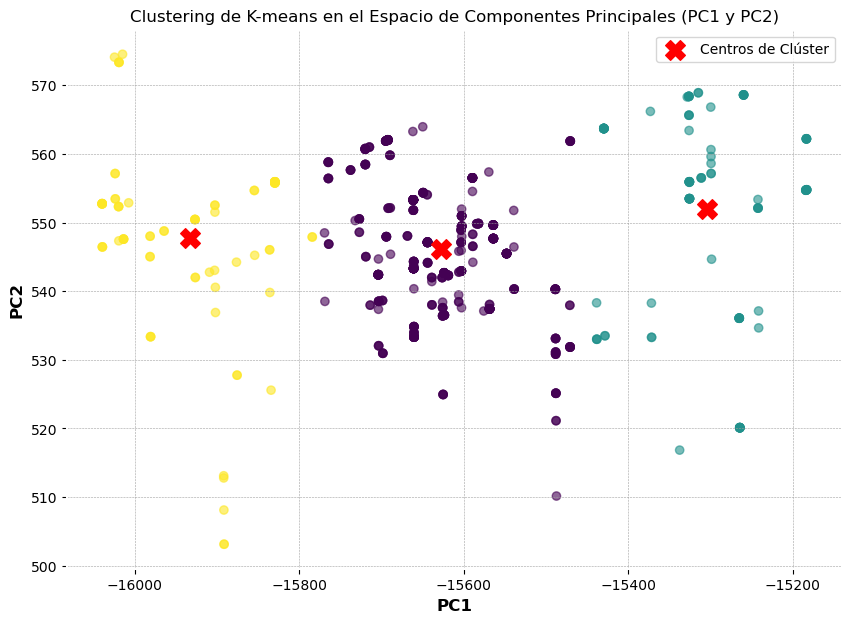

In [104]:
# Evaluar la calidad del modelo K-means
evaluator = ClusteringEvaluator(featuresCol="pca_features_kmeans", predictionCol="prediction", metricName="silhouette")
silhouette_score = evaluator.evaluate(kmeans_predictions)
print(f"Silhouette Score para el modelo de K-means: {silhouette_score}")

# Extraer centros de los clústeres
centers = kmeans_model.clusterCenters()
print("Centros de los clústeres:")
for center in centers:
    print(center)

# Paso 4: Visualización de los clústeres en el espacio de los componentes principales
kmeans_predictions_pd = kmeans_predictions.select("PC1", "PC2", "prediction").toPandas()

plt.figure(figsize=(10, 7))
plt.scatter(kmeans_predictions_pd["PC1"], kmeans_predictions_pd["PC2"], c=kmeans_predictions_pd["prediction"], cmap="viridis", alpha=0.6)
plt.scatter([center[0] for center in centers], [center[1] for center in centers], c="red", marker="X", s=200, label="Centros de Clúster")
plt.title("Clustering de K-means en el Espacio de Componentes Principales (PC1 y PC2)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

Para k = 2, Coeficiente de Silhouette = 0.7663304812583079
Para k = 3, Coeficiente de Silhouette = 0.8306907611640852
Para k = 4, Coeficiente de Silhouette = 0.759221463665402
Para k = 5, Coeficiente de Silhouette = 0.7320900136797283
Para k = 6, Coeficiente de Silhouette = 0.7219122752135139


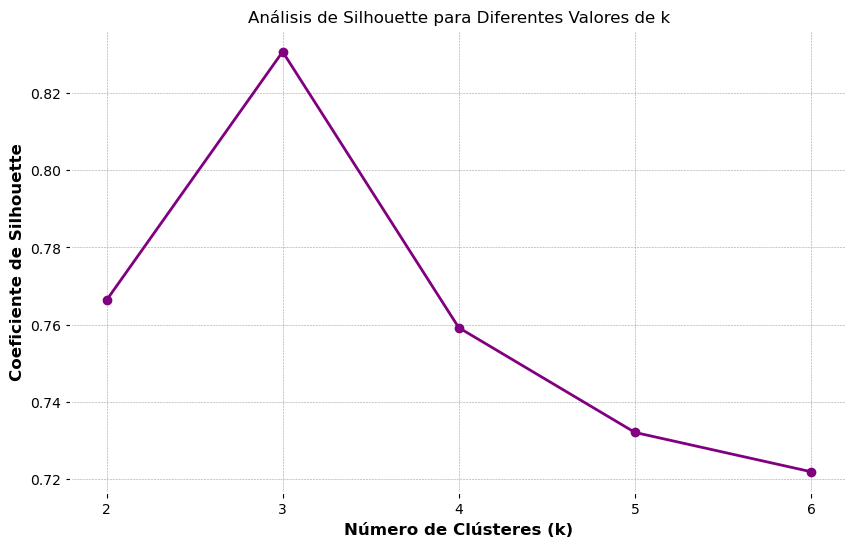

In [105]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt

# Verificar y preparar las columnas PCA para clustering
if "features" in pca_df.columns:
    pca_df = pca_df.drop("features")

# Seleccionar las características para el clustering (PC1 y PC2)
feature_cols = ["PC1", "PC2"]

# VectorAssembler para agrupar PC1 y PC2 en una columna de características para el modelo K-means
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
pca_df = assembler.transform(pca_df)

# Configuración de valores de k y cálculo del coeficiente de Silhouette
silhouette_scores = []
ks = range(2, 7)  # Rango de valores de k
for k in ks:
    kmeans = KMeans(featuresCol="features", k=k, seed=1)
    
    # Ajuste del modelo y predicción
    model = kmeans.fit(pca_df)
    predictions = model.transform(pca_df)
    
    # Evaluación de la calidad del agrupamiento con el coeficiente de Silhouette
    evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="prediction", metricName="silhouette")
    silhouette_score = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette_score)
    print(f"Para k = {k}, Coeficiente de Silhouette = {silhouette_score}")

# Visualización del coeficiente de Silhouette para cada valor de k
plt.figure(figsize=(10, 6))
plt.plot(ks, silhouette_scores, marker='o', color='purple')
plt.xlabel("Número de Clústeres (k)")
plt.ylabel("Coeficiente de Silhouette")
plt.title("Análisis de Silhouette para Diferentes Valores de k")
plt.xticks(ks)
plt.grid(True)
plt.show()


Área bajo la curva ROC para el modelo SVM: 0.5
Precisión del modelo SVM: 0.5786163522012578


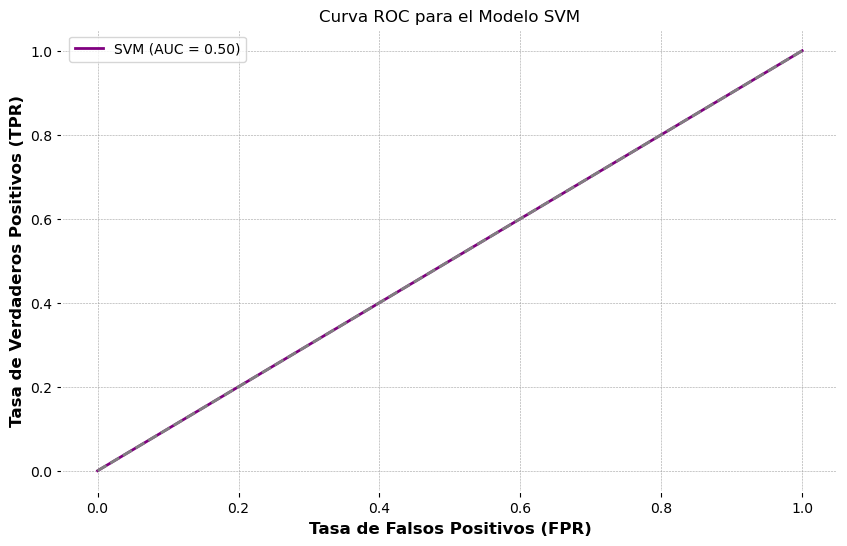

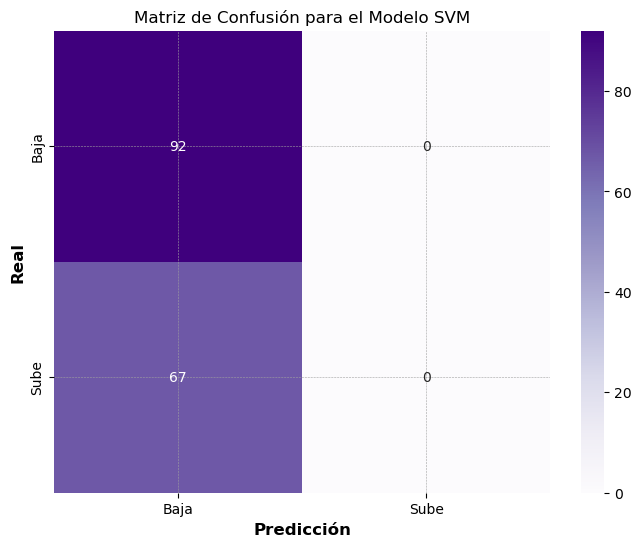

In [106]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Preparar los datos
if "features" in combined_df_filtered.columns:
    combined_df_filtered = combined_df_filtered.drop("features")

# Seleccionar características y definir la etiqueta de clasificación binaria
feature_cols = ["lagged_close_WALMEX", "lagged_close_SORIANAB", "lagged_close_FEMSAUBD", "lagged_close_LACOMERUBC", "lagged_close_CHDRAUIB", 
                "lagged_close_WMT", "lagged_close_BIMBOA", "lagged_close_COST", "lagged_close_ALSEA"]

# Crear una ventana para obtener el valor del próximo precio
window_spec = Window.orderBy("minute_start")

# Usar `lead` para obtener el próximo valor de `close_WALMEX` y determinar si sube o baja
combined_df_filtered = combined_df_filtered.withColumn("next_close_WALMEX", F.lead("close_WALMEX").over(window_spec))
combined_df_filtered = combined_df_filtered.withColumn(
    "price_direction", F.when(F.col("next_close_WALMEX") > F.col("close_WALMEX"), 1).otherwise(0)
).drop("next_close_WALMEX")

# VectorAssembler para transformar las características en un vector para el modelo SVM
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
combined_df_filtered = assembler.transform(combined_df_filtered)

# Dividir los datos en conjunto de entrenamiento y prueba
train, test = combined_df_filtered.randomSplit([0.8, 0.2], seed=747)

# Configuración y entrenamiento del modelo Linear SVC
svm = LinearSVC(featuresCol="features", labelCol="price_direction", predictionCol="prediction", maxIter=10, regParam=0.1)
svm_model = svm.fit(train)
svm_predictions = svm_model.transform(test)

# Evaluación del modelo SVM
evaluator = BinaryClassificationEvaluator(labelCol="price_direction", rawPredictionCol="prediction", metricName="areaUnderROC")
svm_auc = evaluator.evaluate(svm_predictions)
print(f"Área bajo la curva ROC para el modelo SVM: {svm_auc}")

# Obtener precisión adicional
accuracy = svm_predictions.filter(svm_predictions.price_direction == svm_predictions.prediction).count() / float(svm_predictions.count())
print(f"Precisión del modelo SVM: {accuracy}")

# Visualización de la curva ROC y matriz de confusión
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, confusion_matrix

# Curva ROC
svm_roc_df = svm_predictions.select("price_direction", "prediction").toPandas()
fpr, tpr, thresholds = roc_curve(svm_roc_df["price_direction"], svm_roc_df["prediction"])
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'SVM (AUC = {svm_auc:.2f})', color="purple")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC para el Modelo SVM")
plt.legend(loc="best")
plt.show()

# Matriz de Confusión
conf_matrix = confusion_matrix(svm_roc_df["price_direction"], svm_roc_df["prediction"])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Purples", xticklabels=["Baja", "Sube"], yticklabels=["Baja", "Sube"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión para el Modelo SVM")
plt.show()


In [107]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import functions as F

if "features" in combined_df_filtered.columns:
    combined_df_filtered = combined_df_filtered.drop("features")

# Crear una columna binaria 'price_direction' como etiqueta de clasificación
# price_direction = 1 si el precio sube en la siguiente fila, de lo contrario 0
combined_df_filtered = combined_df_filtered.withColumn(
    "price_direction",
    F.when(F.lead("close_WALMEX").over(Window.orderBy("minute_start")) > F.col("close_WALMEX"), 1).otherwise(0)
)

# Eliminar filas con valores nulos en las columnas de características y en la etiqueta
combined_df_filtered = combined_df_filtered.dropna(subset=["lagged_close_WALMEX", "lagged_close_SORIANAB", 
                                                           "lagged_close_FEMSAUBD", "lagged_close_LACOMERUBC", 
                                                           "lagged_close_CHDRAUIB", "lagged_close_WMT", 
                                                           "lagged_close_BIMBOA", "lagged_close_COST", "lagged_close_ALSEA",
                                                           "price_direction"])

# Seleccionar las columnas de características
feature_cols = ["lagged_close_WALMEX", "lagged_close_SORIANAB", "lagged_close_FEMSAUBD",
                "lagged_close_LACOMERUBC", "lagged_close_CHDRAUIB", "lagged_close_WMT",
                "lagged_close_BIMBOA", "lagged_close_COST", "lagged_close_ALSEA"]

# Ensamblar las características en una columna de vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(combined_df_filtered)

# Dividir los datos en conjunto de entrenamiento y prueba
train, test = data.randomSplit([0.8, 0.2], seed=42)

# Crear el modelo de árbol de decisión
dt = DecisionTreeClassifier(featuresCol="features", labelCol="price_direction", predictionCol="prediction")
dt_model = dt.fit(train)

# Hacer predicciones en el conjunto de prueba
predictions = dt_model.transform(test)

# Evaluar el modelo con el área bajo la curva ROC
evaluator = BinaryClassificationEvaluator(labelCol="price_direction", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print(f"Área bajo la curva ROC para el modelo de Árbol de Decisión: {auc}")

# Ver las primeras predicciones
predictions.select("minute_start", "close_WALMEX", "price_direction", "prediction", "probability").show(5)


Área bajo la curva ROC para el modelo de Árbol de Decisión: 0.40429573348918757
+-------------------+------------+---------------+----------+--------------------+
|       minute_start|close_WALMEX|price_direction|prediction|         probability|
+-------------------+------------+---------------+----------+--------------------+
|2024-06-24 08:50:00|       61.63|              1|       0.0|[0.67179487179487...|
|2024-06-24 09:10:00|       61.56|              0|       0.0|[0.59793814432989...|
|2024-06-24 09:20:00|       61.41|              1|       0.0|[0.59793814432989...|
|2024-06-24 09:45:00|       61.47|              0|       1.0|[0.33333333333333...|
|2024-06-24 10:15:00|       61.23|              0|       0.0|[0.59793814432989...|
+-------------------+------------+---------------+----------+--------------------+
only showing top 5 rows



                   Feature  Importance
5         lagged_close_WMT    0.258562
2    lagged_close_FEMSAUBD    0.248375
3  lagged_close_LACOMERUBC    0.185542
0      lagged_close_WALMEX    0.114079
4    lagged_close_CHDRAUIB    0.054925
1    lagged_close_SORIANAB    0.053290
6      lagged_close_BIMBOA    0.048020
7        lagged_close_COST    0.037207
8       lagged_close_ALSEA    0.000000


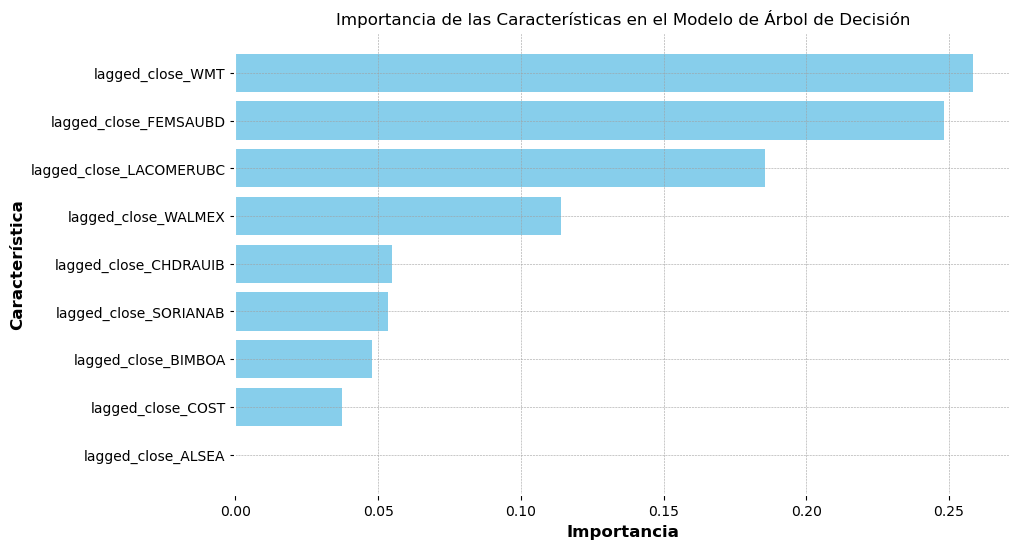

In [108]:
import matplotlib.pyplot as plt
import pandas as pd

# Obtener la importancia de las características del modelo
feature_importances = dt_model.featureImportances.toArray()

# Crear un DataFrame para organizar la información
feature_importance_df = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

# Mostrar la tabla de importancia
print(feature_importance_df)

# Visualizar la importancia de las características con una gráfica de barras
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="skyblue")
plt.xlabel("Importancia")
plt.ylabel("Característica")
plt.title("Importancia de las Características en el Modelo de Árbol de Decisión")
plt.gca().invert_yaxis()  # Invertir el eje y para que las características más importantes estén en la parte superior
plt.show()
